Code based on GitHub repository https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

# Imports

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, Reshape, Dropout, UpSampling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

# Dataset Load

We download MNIST dataset, consisting of 60.000 images of 28x28 pixels resolution. Each image defines a handwritten number in greyscale.

(60000, 28, 28)


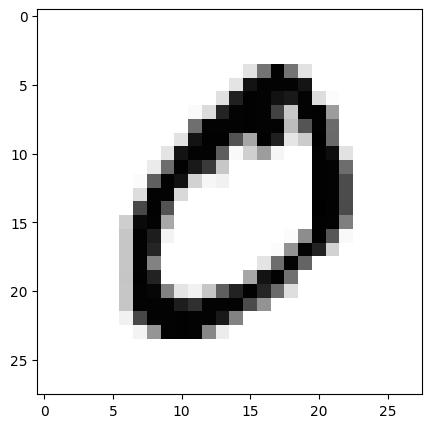

In [26]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
plt.imshow(X_train[1], cmap = 'Greys')
print(X_train.shape)

## Preprocessing data

The pixels in the source image are within the range [0, 256] we will normalize this range to [-1, 1] in order to treat this information with neural networks.

In [27]:
X_train = X_train.astype('float32')/127.5 -1

X_train = np.expand_dims(X_train, axis=3)

# Generator definition

## Responda a las siguientes cuestiones:

* Describa el diseño de las red neuronal Generativa, justificando los hiperparámetros utilizados en la medida de lo posible.

* Existen una serie de capas que pueden ser beneficiosas para el entrenamiento de redes GAN, algunas de ellas son las capas de Dropout o BatchNormalization. En caso de utilizar dichas capas justifique su uso. Se **valorará positivamente** responder a este apartado.

### RESPUESTA
  1. Primero se utiliza una capa densa para expandir el vector de entrada.
  2. Después se utiliza la capa reshape para darle la forma (7, 7, 128) para poder utilizar las capas convolucionales.
  3. Se utilizan capas UpSampling2D para aumentar las dimenstiones de la imagen pasando de 7x7 a 14x14 y acabar con un 28x28 que es el tamaño de imagen que buscamos.
  4. A continuación de las capas UpSampling, se utilizan capas convolucionales con activaciones ReLU en las que variamos el numero de filtros (128 y 64) para aprender características en diferentes niveles de escalas.
  5. Se utilizan capas BatchNormalization para estabilizar el entrenamiento y acelerar la calidad de las imagenes, además utilizamos un momentum del 0.8 para darle un 80% de importancia a las estadísticas anteriores.
  6. Finalmente, se utiliza una capa de activación 'tanh' en la salida para garantizar que esta se encuentre en el rango [-1, 1].

In [28]:
def create_generator():
    input = Input(shape=(100))

    # Rellene con la red neuronal convolucional deseada
    x = Dense(7*7*128)(input)
    x = Reshape((7,7,128))(x)

    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation('relu')(x)

    x = Conv2D(1, kernel_size=3, padding='same')(x)
    output = Activation('tanh')(x)

    generator = Model(input, output)

    return generator

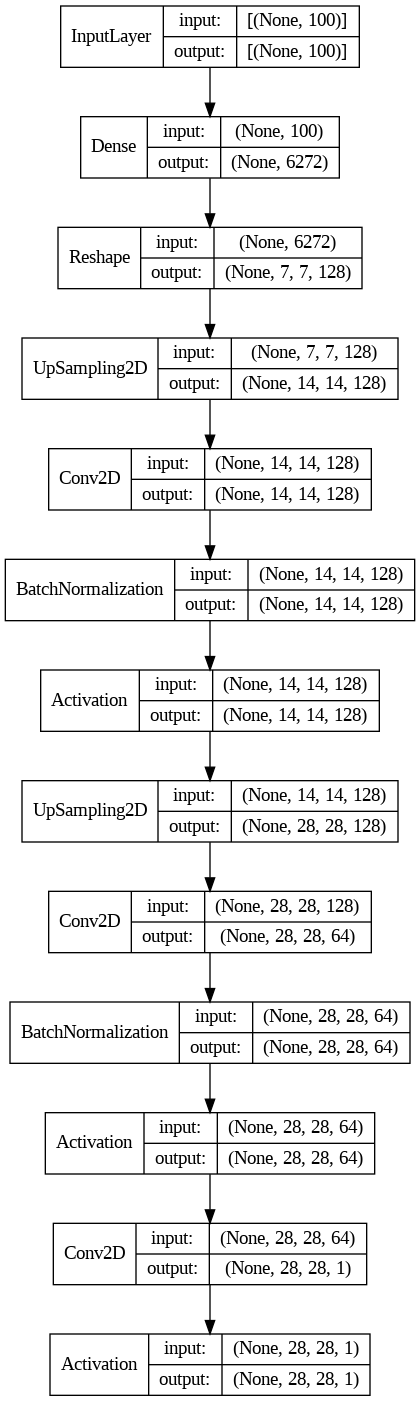

In [29]:
generator = create_generator()
plot_model(generator, show_shapes=True, show_layer_names=False)

# Discriminator definition

## Responda a las siguientes cuestiones:

* Describa el diseño de las red neuronal Discriminadora, justificando los hiperparámetros utilizados en la medida de lo posible.

* Existen una serie de capas que pueden ser beneficiosas para el entrenamiento de redes GAN, algunas de ellas son las capas de Dropout o BatchNormalization. En caso de utilizar dichas capas justifique su uso. Se **valorará positivamente** responder a este apartado.

### RESPUESTA

  1. Se utilizan tres capas Conv2D con strides=2 para ir reduciendo el tamaño de la imagen de entrada. Además, el número de filtros va aumentando (32, 64, 128) a medida que se reduce  la imagen para aumentar el numero de características extraídas.
  2. Después de cada capa convolucional, se utiliza una capa LeakyReLU con un alpha=0.2 para diferenciarla un poco mas de una capa ReLU.
  3. Después de cada capa LeakyReLU, se utiliza una capa Dropout con un valor del 0.25 para introducir regularización en el discriminador, desactivando capas con un 25% de probabilidad.
  4. Después de los tres conjuntos de capas anteriores, se utiliza una capa flaten para transformar los resultados a un vector unidimensional.
  5. Finalmente se utiliza la capa Densa

In [30]:
def create_discriminator():
    input = Input(shape=(28, 28, 1))

    # Rellene con la red neuronal convolucional deseada
    x = Conv2D(32, kernel_size=3, strides=2, padding='same')(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    output = Dense(1, activation='sigmoid')(x)

    discriminator = Model(input, output)

    return discriminator

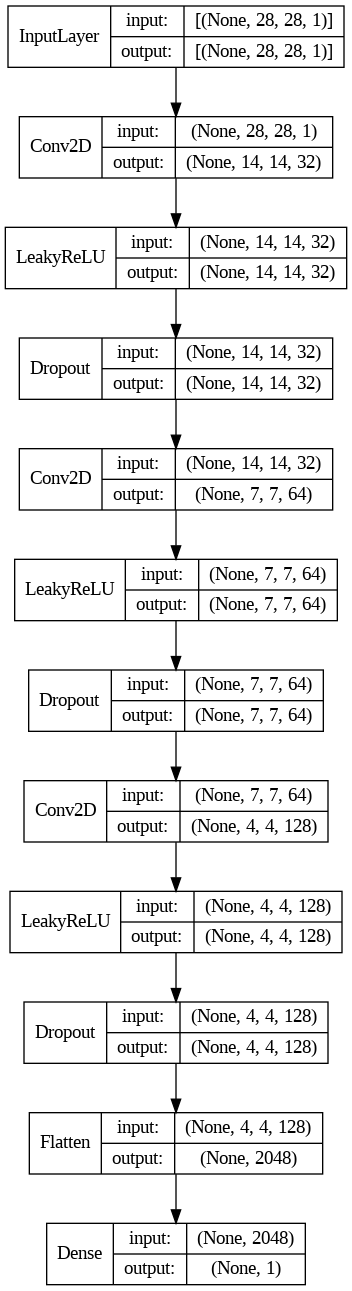

In [31]:
discriminator = create_discriminator()
plot_model(discriminator, show_shapes=True, show_layer_names=False)

# GAN model definition

In [32]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
discriminator.trainable = False

z = Input(shape=(100,))
img = generator(z)
validity = discriminator(img)

combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

# Training

In [33]:
def train(X_train, generator, discriminator, combined, epochs, batch_size=32, sample_interval=100):
    # Adversarial ground truths (-1 fake and 1 real)
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    history = {
        'd_loss' : [],
        'd_acc' : [],
        'g_loss' : []
    }

    for epoch in range(epochs):
        print("----EPOCH " + str(epoch) + '-----')
        for batch in range(int(len(X_train)/batch_size)):
            #  Train the Discriminator
            noise = np.random.normal(0, 1, (batch_size, 100))
            gen_imgs = generator.predict(noise, verbose=0)
            imgs = X_train[batch*batch_size : (batch+1)*batch_size]

            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the Generator
            noise = np.random.normal(0, 1, (batch_size, 100))
            g_loss = combined.train_on_batch(noise, valid)

            # Save losses
            history['d_loss'].append(d_loss[0])
            history['d_acc'].append(d_loss[1])
            history['g_loss'].append(g_loss)

            # Plot the progress
            if batch % 50 == 0:
                print ("%d [D loss: %.4f,\t acc.: %.2f%%]\t[G loss: %.4f]" % (batch, d_loss[0], 100*d_loss[1], g_loss))

            if batch % 500 == 0:
                sample_images(epoch, batch, gen_imgs, imgs)

        plot_losses(history)

## Plotting functions

In [34]:
def sample_images(epoch, batch, gen_imgs, imgs):
    plt.rcParams['figure.figsize'] = [15, 5]
    fig, axs = plt.subplots(2, 5)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)
    for i in range(5):
        axs[0,i].imshow(gen_imgs[i,:,:,0], cmap='Greys')
        axs[0,i].axis('off')

    for i in range(5):
        axs[1,i].imshow(imgs[i,:,:,0], cmap='Greys')
        axs[1,i].axis('off')
    plt.show()
    plt.close()

In [35]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()

    ax1.plot(history['d_loss'], label='D loss')
    ax1.plot(history['g_loss'], label='G loss')
    ax1.legend()

    ax2.set_title('D accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()

    ax2.plot(history['d_acc'], label='Accuracy')
    ax2.legend()

    plt.show()

## Responda a las siguientes cuestiones:

* Analice los resultados del entrenamiento realizado, identifique posibles problemas que hayan podido surgir en sus redes. En caso de que sea necesario haga más pruebas en otra celda, justificando la evolución y cambios de una a otra.

----EPOCH 0-----
0 [D loss: 0.6950,	 acc.: 29.69%]	[G loss: 0.6279]


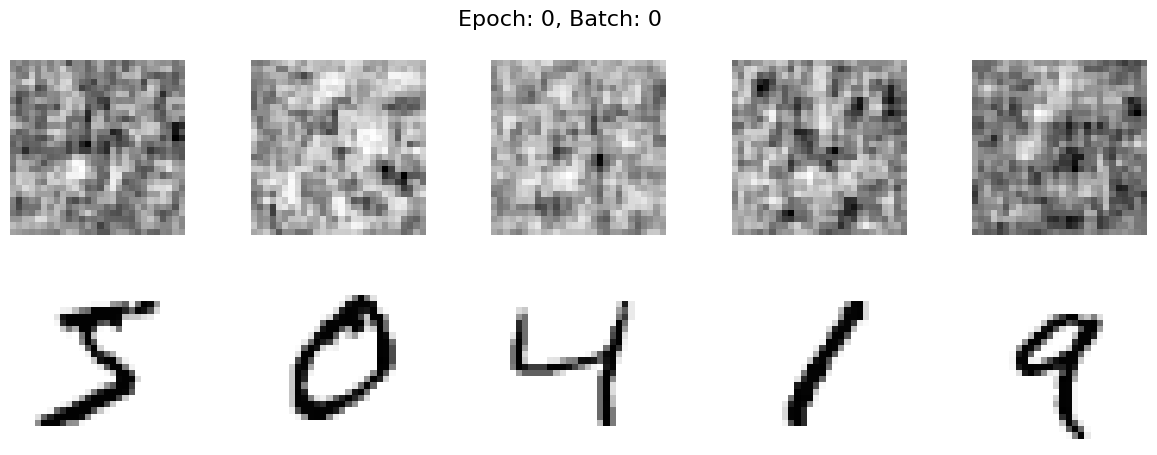

50 [D loss: 0.5079,	 acc.: 78.12%]	[G loss: 1.1190]
100 [D loss: 0.6230,	 acc.: 67.19%]	[G loss: 0.7880]
150 [D loss: 0.6973,	 acc.: 64.06%]	[G loss: 1.0304]
200 [D loss: 0.4660,	 acc.: 84.38%]	[G loss: 1.0006]
250 [D loss: 0.4642,	 acc.: 81.25%]	[G loss: 1.3955]
300 [D loss: 0.4123,	 acc.: 87.50%]	[G loss: 0.7814]
350 [D loss: 0.7500,	 acc.: 53.12%]	[G loss: 0.8257]
400 [D loss: 0.4779,	 acc.: 79.69%]	[G loss: 1.2284]
450 [D loss: 0.6177,	 acc.: 68.75%]	[G loss: 1.3803]
500 [D loss: 0.6050,	 acc.: 64.06%]	[G loss: 1.1074]


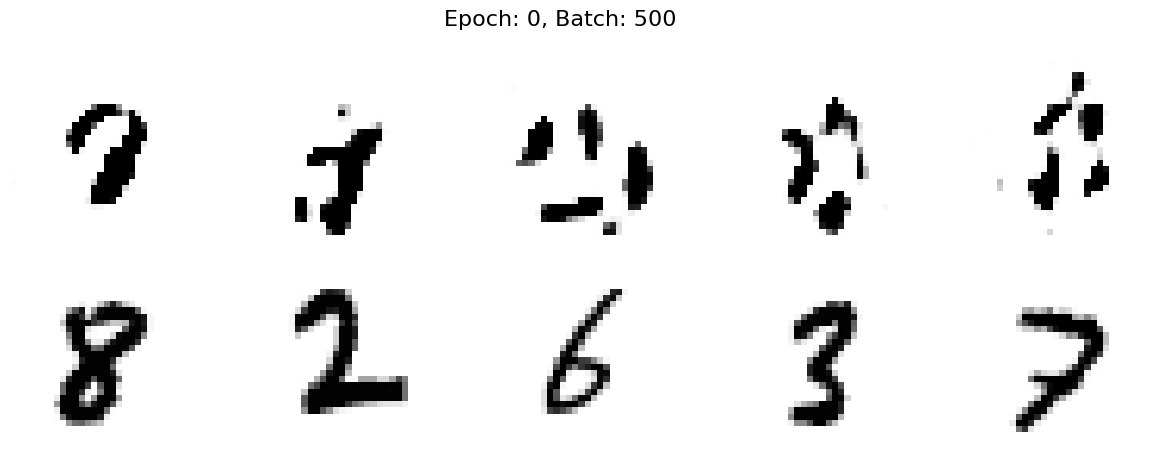

550 [D loss: 1.0011,	 acc.: 32.81%]	[G loss: 0.8441]
600 [D loss: 0.4237,	 acc.: 84.38%]	[G loss: 1.4250]
650 [D loss: 0.2652,	 acc.: 92.19%]	[G loss: 1.4250]
700 [D loss: 0.2370,	 acc.: 90.62%]	[G loss: 2.7436]
750 [D loss: 0.9056,	 acc.: 60.94%]	[G loss: 1.7788]
800 [D loss: 0.3257,	 acc.: 89.06%]	[G loss: 1.4769]
850 [D loss: 0.4476,	 acc.: 81.25%]	[G loss: 1.6162]
900 [D loss: 0.4415,	 acc.: 76.56%]	[G loss: 1.6561]
950 [D loss: 1.1953,	 acc.: 34.38%]	[G loss: 0.6663]
1000 [D loss: 0.5086,	 acc.: 76.56%]	[G loss: 1.3067]


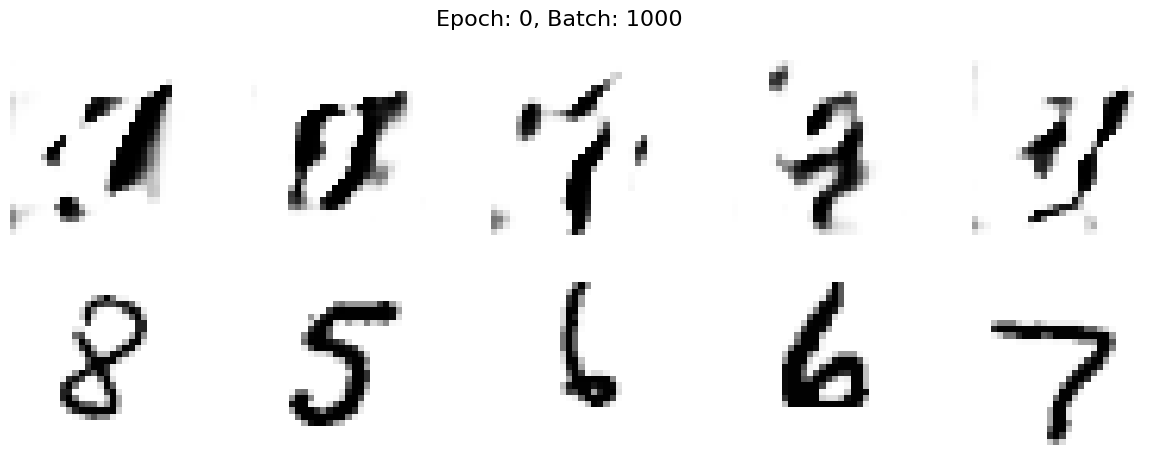

1050 [D loss: 0.7084,	 acc.: 56.25%]	[G loss: 0.9346]
1100 [D loss: 0.7675,	 acc.: 54.69%]	[G loss: 0.8924]
1150 [D loss: 0.4181,	 acc.: 85.94%]	[G loss: 1.3771]
1200 [D loss: 0.3715,	 acc.: 87.50%]	[G loss: 1.7330]
1250 [D loss: 0.4456,	 acc.: 75.00%]	[G loss: 1.7992]
1300 [D loss: 0.3700,	 acc.: 85.94%]	[G loss: 1.1064]
1350 [D loss: 0.6339,	 acc.: 62.50%]	[G loss: 1.1062]
1400 [D loss: 0.5673,	 acc.: 76.56%]	[G loss: 1.0434]
1450 [D loss: 0.5534,	 acc.: 71.88%]	[G loss: 1.0901]
1500 [D loss: 0.6778,	 acc.: 60.94%]	[G loss: 1.0033]


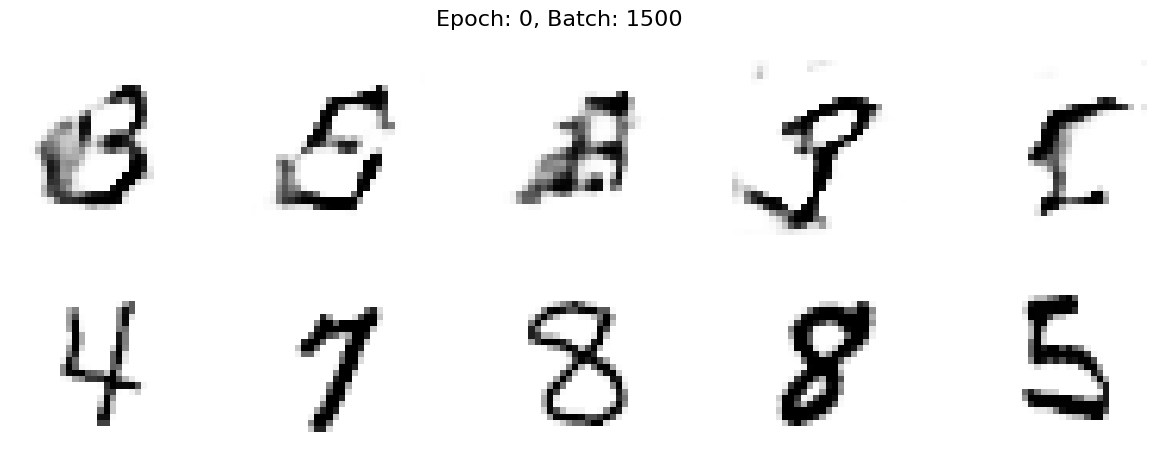

1550 [D loss: 0.6719,	 acc.: 60.94%]	[G loss: 1.1423]
1600 [D loss: 0.7172,	 acc.: 57.81%]	[G loss: 0.8470]
1650 [D loss: 0.5961,	 acc.: 64.06%]	[G loss: 0.9664]
1700 [D loss: 0.7006,	 acc.: 51.56%]	[G loss: 1.1335]
1750 [D loss: 0.8115,	 acc.: 50.00%]	[G loss: 0.7876]
1800 [D loss: 0.5484,	 acc.: 73.44%]	[G loss: 1.0522]
1850 [D loss: 0.7625,	 acc.: 54.69%]	[G loss: 0.9440]


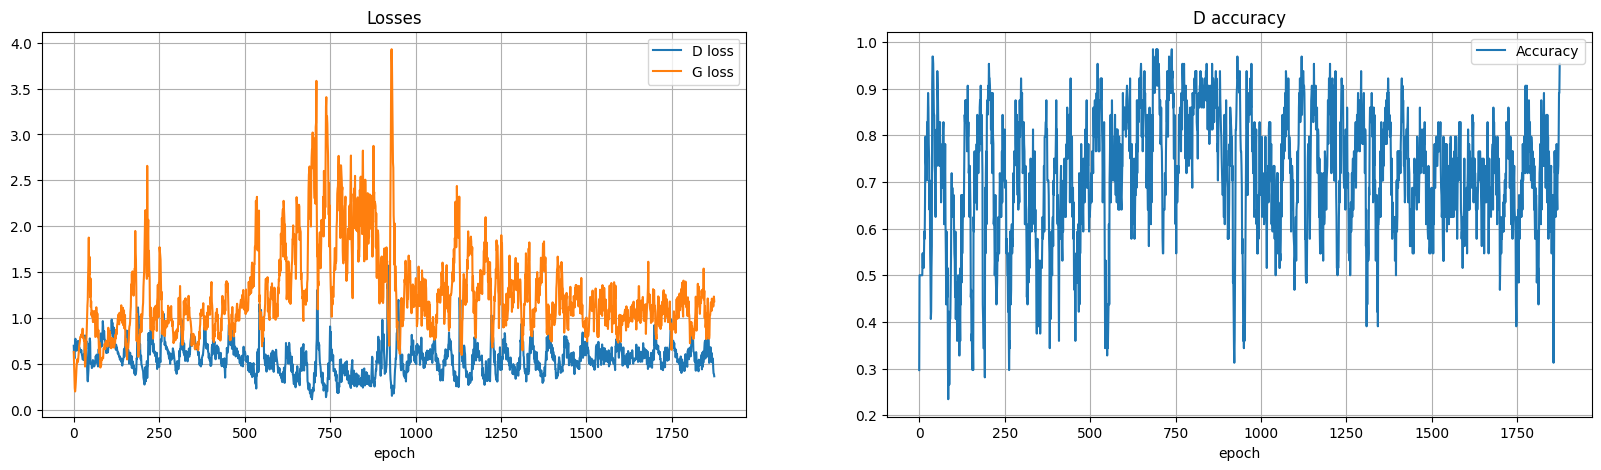

----EPOCH 1-----
0 [D loss: 0.5129,	 acc.: 73.44%]	[G loss: 1.2182]


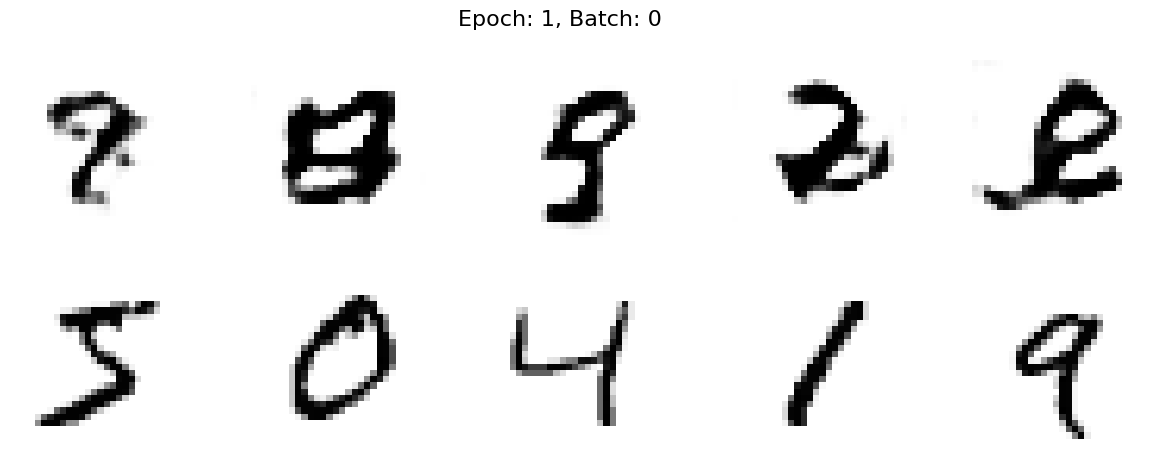

50 [D loss: 0.5513,	 acc.: 67.19%]	[G loss: 1.1851]
100 [D loss: 0.3241,	 acc.: 90.62%]	[G loss: 1.5323]
150 [D loss: 0.4388,	 acc.: 81.25%]	[G loss: 1.1768]
200 [D loss: 0.6276,	 acc.: 64.06%]	[G loss: 1.0852]
250 [D loss: 0.4457,	 acc.: 82.81%]	[G loss: 1.2504]
300 [D loss: 0.4106,	 acc.: 81.25%]	[G loss: 1.2860]
350 [D loss: 0.4736,	 acc.: 79.69%]	[G loss: 0.9766]
400 [D loss: 0.6577,	 acc.: 59.38%]	[G loss: 1.0239]
450 [D loss: 0.4927,	 acc.: 73.44%]	[G loss: 0.9368]
500 [D loss: 0.6282,	 acc.: 64.06%]	[G loss: 1.0252]


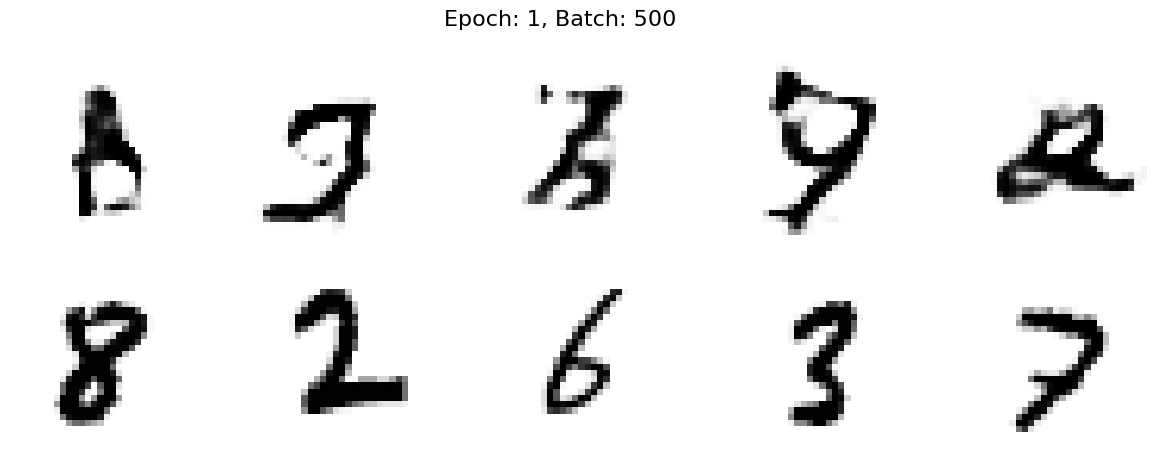

550 [D loss: 0.6771,	 acc.: 57.81%]	[G loss: 1.0601]
600 [D loss: 0.6455,	 acc.: 68.75%]	[G loss: 0.8381]
650 [D loss: 0.5611,	 acc.: 71.88%]	[G loss: 0.9413]
700 [D loss: 0.5735,	 acc.: 76.56%]	[G loss: 0.9494]
750 [D loss: 0.6184,	 acc.: 71.88%]	[G loss: 1.1529]
800 [D loss: 0.6108,	 acc.: 70.31%]	[G loss: 0.8581]
850 [D loss: 0.7111,	 acc.: 56.25%]	[G loss: 0.8862]
900 [D loss: 0.6050,	 acc.: 68.75%]	[G loss: 0.8818]
950 [D loss: 0.5631,	 acc.: 68.75%]	[G loss: 0.8479]
1000 [D loss: 0.6618,	 acc.: 60.94%]	[G loss: 0.9382]


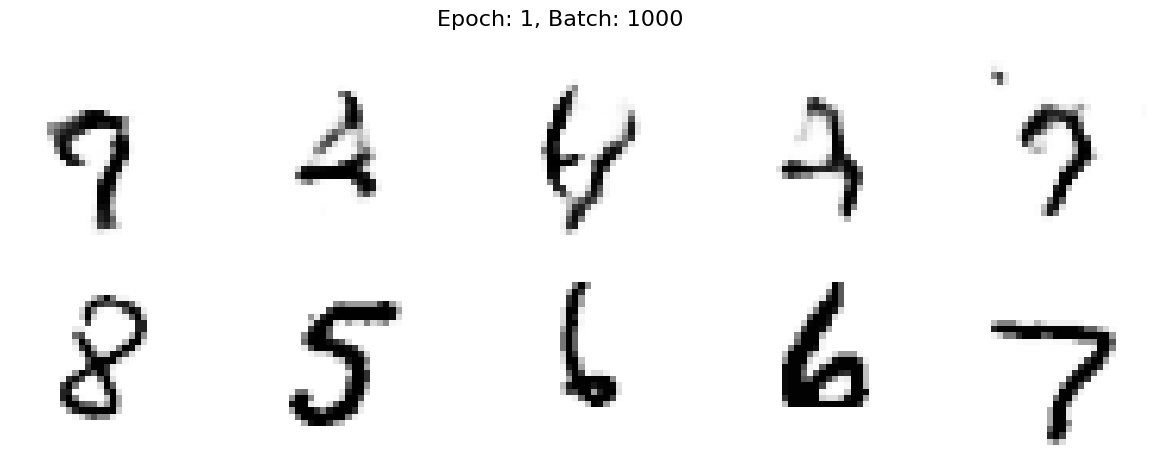

1050 [D loss: 0.6763,	 acc.: 60.94%]	[G loss: 0.9549]
1100 [D loss: 0.5291,	 acc.: 70.31%]	[G loss: 0.9948]
1150 [D loss: 0.5950,	 acc.: 67.19%]	[G loss: 1.0395]
1200 [D loss: 0.5978,	 acc.: 70.31%]	[G loss: 0.9613]
1250 [D loss: 0.6696,	 acc.: 60.94%]	[G loss: 0.7663]
1300 [D loss: 0.5020,	 acc.: 78.12%]	[G loss: 0.9519]
1350 [D loss: 0.5439,	 acc.: 73.44%]	[G loss: 0.9901]
1400 [D loss: 0.4669,	 acc.: 85.94%]	[G loss: 1.0894]
1450 [D loss: 0.3877,	 acc.: 84.38%]	[G loss: 1.4227]
1500 [D loss: 0.6348,	 acc.: 68.75%]	[G loss: 0.9020]


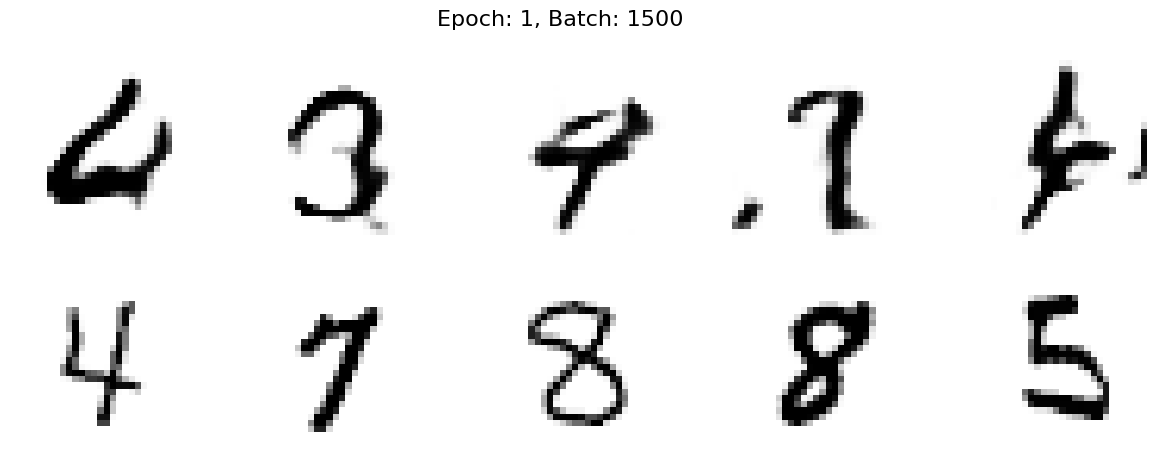

1550 [D loss: 0.5431,	 acc.: 68.75%]	[G loss: 1.1713]
1600 [D loss: 0.4650,	 acc.: 81.25%]	[G loss: 1.4113]
1650 [D loss: 0.5028,	 acc.: 76.56%]	[G loss: 1.0130]
1700 [D loss: 0.6968,	 acc.: 57.81%]	[G loss: 0.9907]
1750 [D loss: 0.5928,	 acc.: 62.50%]	[G loss: 0.9777]
1800 [D loss: 0.5672,	 acc.: 67.19%]	[G loss: 0.9192]
1850 [D loss: 0.6790,	 acc.: 62.50%]	[G loss: 0.8995]


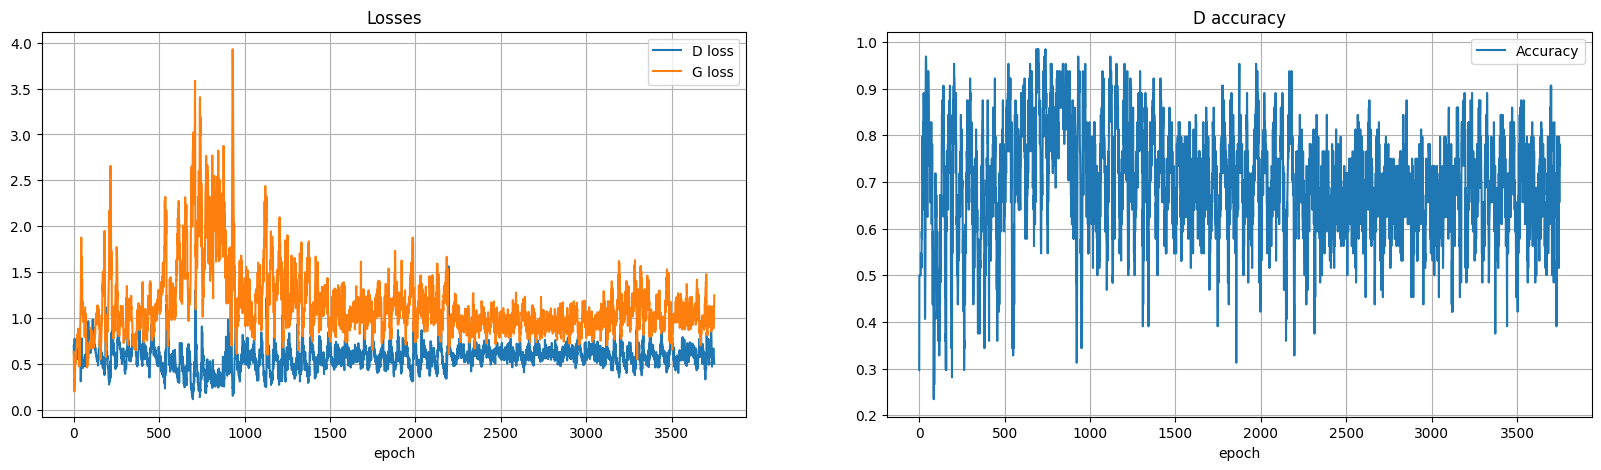

----EPOCH 2-----
0 [D loss: 0.6006,	 acc.: 65.62%]	[G loss: 1.1872]


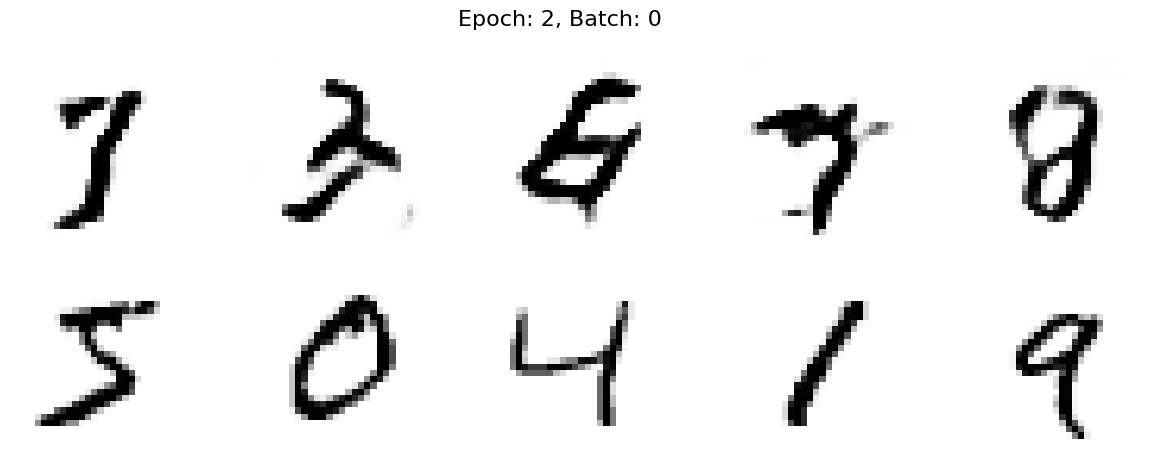

50 [D loss: 0.5471,	 acc.: 73.44%]	[G loss: 1.1068]
100 [D loss: 0.5317,	 acc.: 71.88%]	[G loss: 1.2252]
150 [D loss: 0.5438,	 acc.: 76.56%]	[G loss: 1.2192]
200 [D loss: 0.5984,	 acc.: 65.62%]	[G loss: 0.9577]
250 [D loss: 0.6207,	 acc.: 62.50%]	[G loss: 1.1808]
300 [D loss: 0.5359,	 acc.: 71.88%]	[G loss: 1.3565]
350 [D loss: 0.6741,	 acc.: 57.81%]	[G loss: 0.6198]
400 [D loss: 0.6036,	 acc.: 68.75%]	[G loss: 1.0712]
450 [D loss: 0.6256,	 acc.: 62.50%]	[G loss: 1.2232]
500 [D loss: 0.6273,	 acc.: 64.06%]	[G loss: 0.9809]


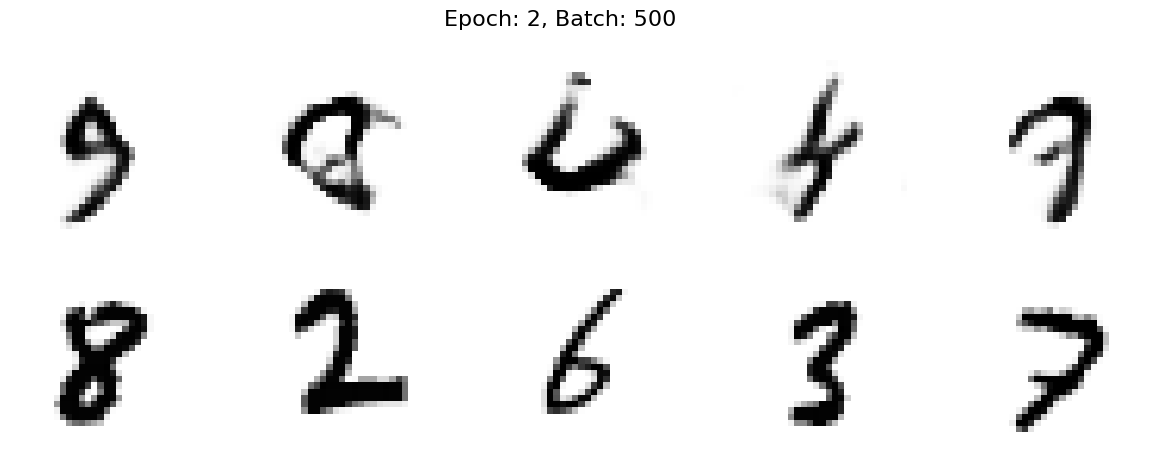

550 [D loss: 0.6123,	 acc.: 64.06%]	[G loss: 0.9836]
600 [D loss: 0.6992,	 acc.: 57.81%]	[G loss: 0.9561]
650 [D loss: 0.4698,	 acc.: 76.56%]	[G loss: 1.0649]
700 [D loss: 0.5345,	 acc.: 73.44%]	[G loss: 1.0692]
750 [D loss: 0.5181,	 acc.: 78.12%]	[G loss: 1.3590]
800 [D loss: 0.5624,	 acc.: 62.50%]	[G loss: 1.2949]
850 [D loss: 0.6280,	 acc.: 65.62%]	[G loss: 0.9177]
900 [D loss: 0.6442,	 acc.: 67.19%]	[G loss: 1.0718]
950 [D loss: 0.5413,	 acc.: 76.56%]	[G loss: 1.0574]
1000 [D loss: 0.5090,	 acc.: 76.56%]	[G loss: 1.3173]


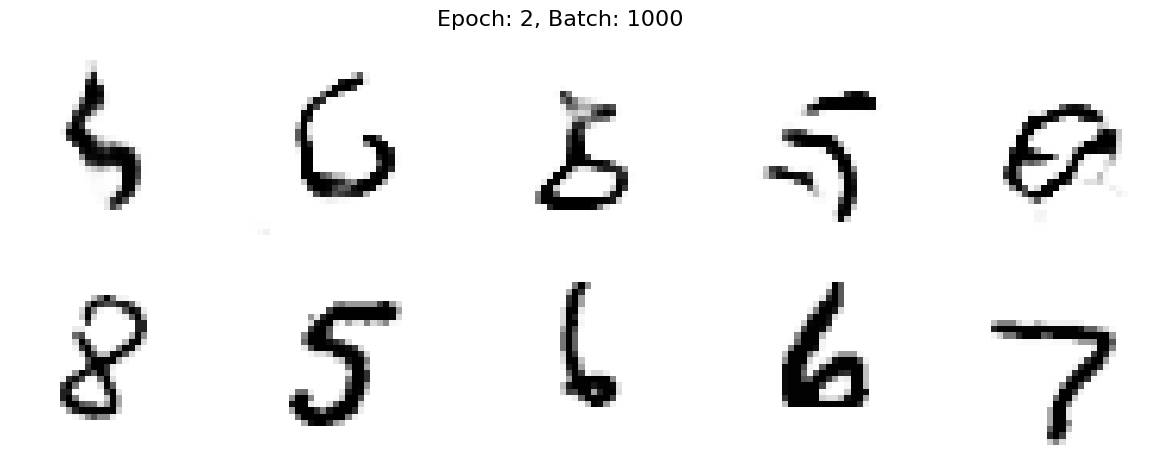

1050 [D loss: 0.4650,	 acc.: 84.38%]	[G loss: 1.4978]
1100 [D loss: 0.6653,	 acc.: 60.94%]	[G loss: 1.5174]
1150 [D loss: 0.5446,	 acc.: 70.31%]	[G loss: 1.0530]
1200 [D loss: 0.6503,	 acc.: 64.06%]	[G loss: 0.9021]
1250 [D loss: 0.6276,	 acc.: 65.62%]	[G loss: 1.0198]
1300 [D loss: 0.6644,	 acc.: 60.94%]	[G loss: 1.0324]
1350 [D loss: 0.6523,	 acc.: 60.94%]	[G loss: 1.0518]
1400 [D loss: 0.5895,	 acc.: 67.19%]	[G loss: 1.0917]
1450 [D loss: 0.6738,	 acc.: 59.38%]	[G loss: 0.9718]
1500 [D loss: 0.6381,	 acc.: 57.81%]	[G loss: 1.0074]


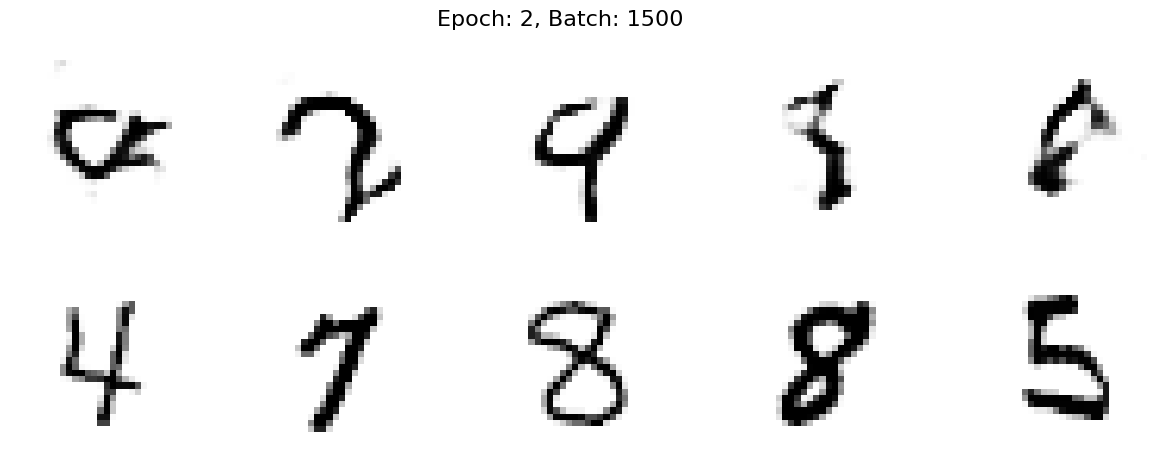

1550 [D loss: 0.4508,	 acc.: 78.12%]	[G loss: 1.2040]
1600 [D loss: 0.3608,	 acc.: 87.50%]	[G loss: 1.5521]
1650 [D loss: 0.4948,	 acc.: 81.25%]	[G loss: 1.0870]
1700 [D loss: 0.6583,	 acc.: 60.94%]	[G loss: 1.0319]
1750 [D loss: 0.6390,	 acc.: 67.19%]	[G loss: 0.9825]
1800 [D loss: 0.5961,	 acc.: 70.31%]	[G loss: 1.1801]
1850 [D loss: 0.6009,	 acc.: 73.44%]	[G loss: 0.9602]


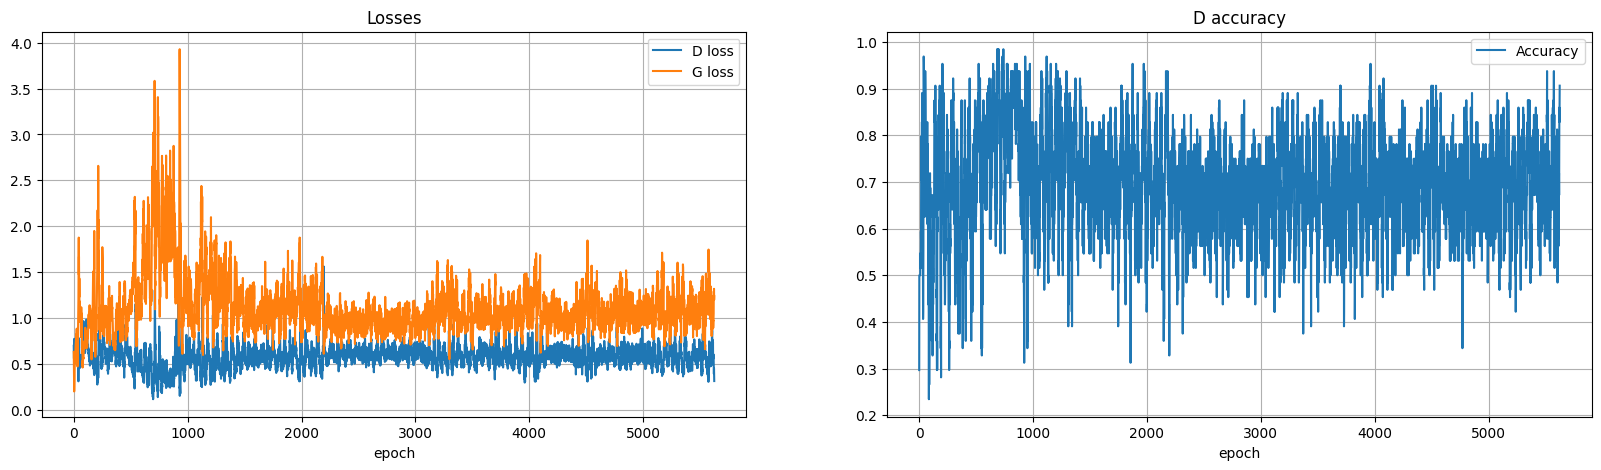

----EPOCH 3-----
0 [D loss: 0.4875,	 acc.: 78.12%]	[G loss: 1.2353]


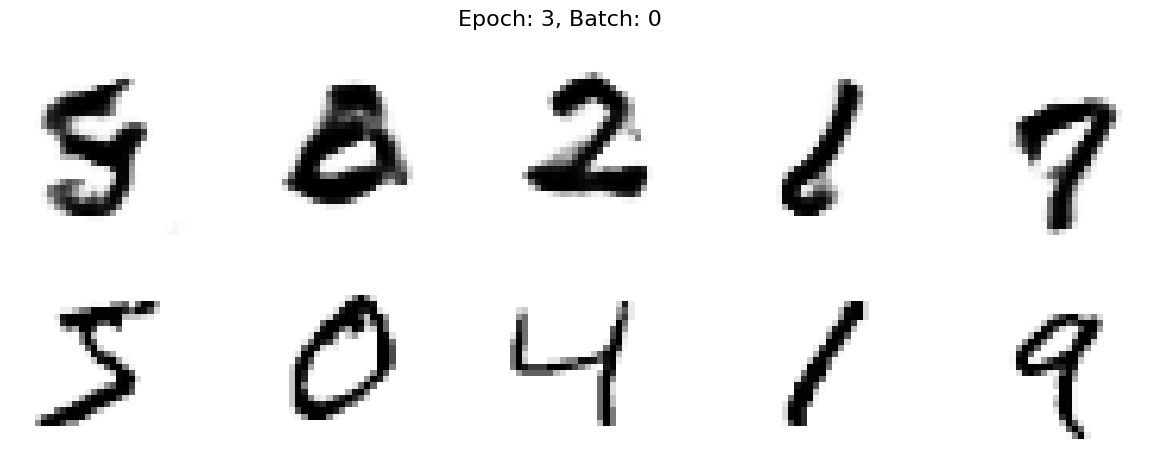

50 [D loss: 0.5429,	 acc.: 76.56%]	[G loss: 1.4732]
100 [D loss: 0.5121,	 acc.: 76.56%]	[G loss: 1.3199]
150 [D loss: 0.6341,	 acc.: 62.50%]	[G loss: 1.1390]
200 [D loss: 0.7504,	 acc.: 56.25%]	[G loss: 0.7104]
250 [D loss: 0.6790,	 acc.: 62.50%]	[G loss: 0.8330]
300 [D loss: 0.4574,	 acc.: 79.69%]	[G loss: 1.5791]
350 [D loss: 0.5543,	 acc.: 75.00%]	[G loss: 0.9993]
400 [D loss: 0.5998,	 acc.: 68.75%]	[G loss: 1.1050]
450 [D loss: 0.6147,	 acc.: 64.06%]	[G loss: 0.8605]
500 [D loss: 0.7491,	 acc.: 54.69%]	[G loss: 0.8943]


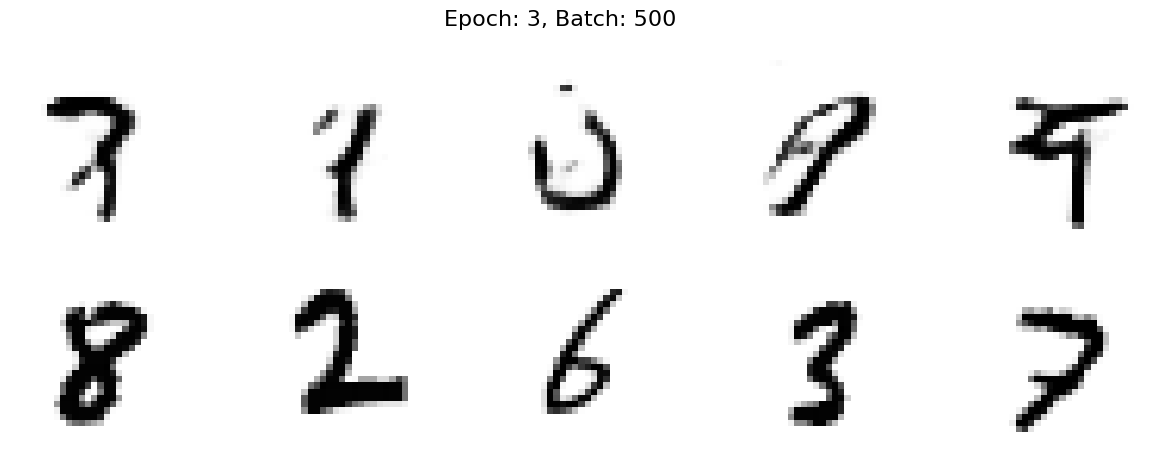

550 [D loss: 0.5330,	 acc.: 73.44%]	[G loss: 1.0763]
600 [D loss: 0.5714,	 acc.: 71.88%]	[G loss: 1.1441]
650 [D loss: 0.5502,	 acc.: 70.31%]	[G loss: 1.4192]
700 [D loss: 0.5600,	 acc.: 67.19%]	[G loss: 0.9394]
750 [D loss: 0.8500,	 acc.: 54.69%]	[G loss: 0.9585]
800 [D loss: 0.4971,	 acc.: 68.75%]	[G loss: 1.0839]
850 [D loss: 0.6803,	 acc.: 59.38%]	[G loss: 1.1645]
900 [D loss: 0.6006,	 acc.: 70.31%]	[G loss: 0.9703]
950 [D loss: 0.6683,	 acc.: 60.94%]	[G loss: 1.1531]
1000 [D loss: 0.5018,	 acc.: 71.88%]	[G loss: 1.0566]


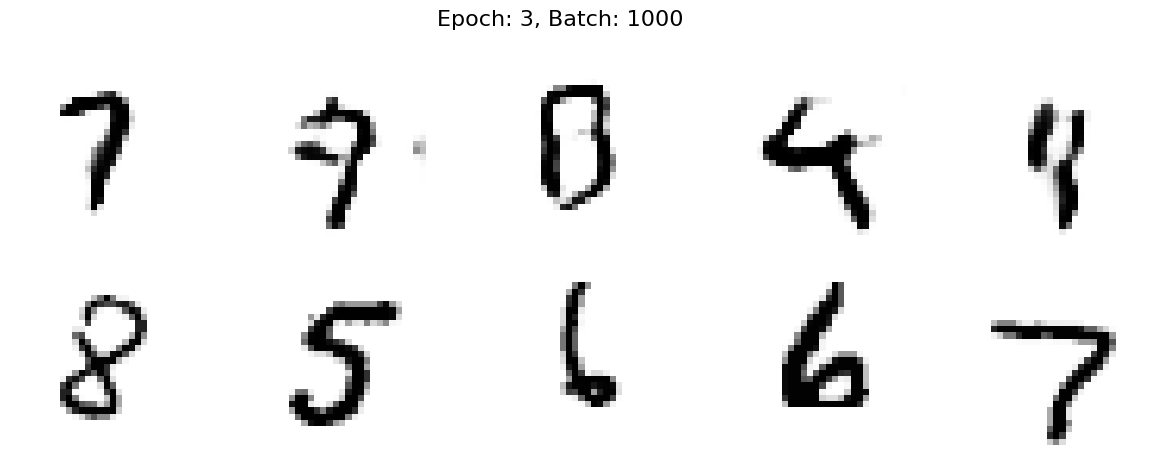

1050 [D loss: 0.5035,	 acc.: 71.88%]	[G loss: 1.1457]
1100 [D loss: 0.5587,	 acc.: 64.06%]	[G loss: 1.1427]
1150 [D loss: 0.6107,	 acc.: 67.19%]	[G loss: 0.9402]
1200 [D loss: 0.5758,	 acc.: 68.75%]	[G loss: 0.9482]
1250 [D loss: 0.7225,	 acc.: 54.69%]	[G loss: 0.9219]
1300 [D loss: 0.5177,	 acc.: 71.88%]	[G loss: 1.1920]
1350 [D loss: 0.5341,	 acc.: 73.44%]	[G loss: 0.9365]
1400 [D loss: 0.5358,	 acc.: 70.31%]	[G loss: 1.0500]
1450 [D loss: 0.5816,	 acc.: 68.75%]	[G loss: 0.9249]
1500 [D loss: 0.5558,	 acc.: 70.31%]	[G loss: 1.0018]


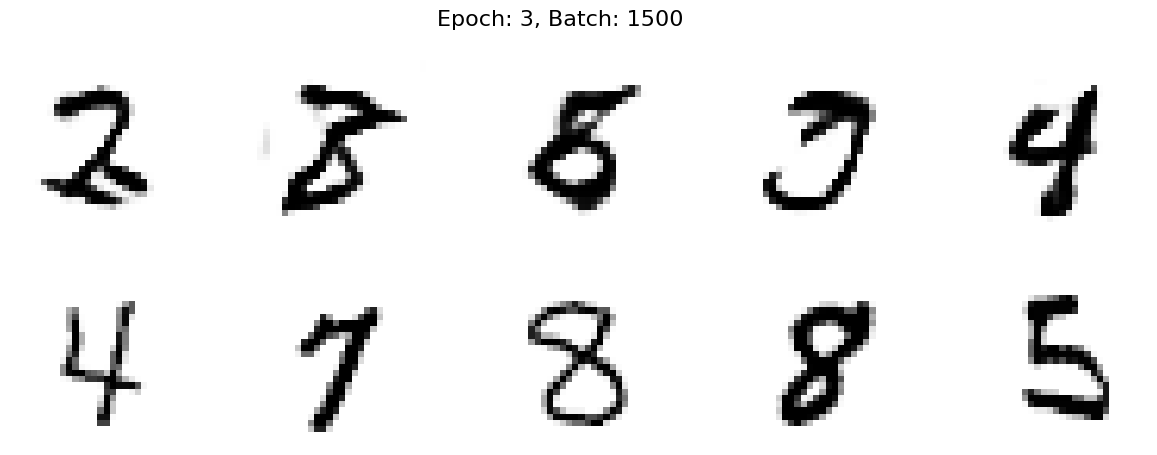

1550 [D loss: 0.6043,	 acc.: 68.75%]	[G loss: 1.2043]
1600 [D loss: 0.6025,	 acc.: 64.06%]	[G loss: 1.0570]
1650 [D loss: 0.6552,	 acc.: 64.06%]	[G loss: 1.2626]
1700 [D loss: 0.5194,	 acc.: 73.44%]	[G loss: 1.2297]
1750 [D loss: 0.5165,	 acc.: 76.56%]	[G loss: 1.2084]
1800 [D loss: 0.5090,	 acc.: 73.44%]	[G loss: 1.3510]
1850 [D loss: 0.6155,	 acc.: 67.19%]	[G loss: 1.3184]


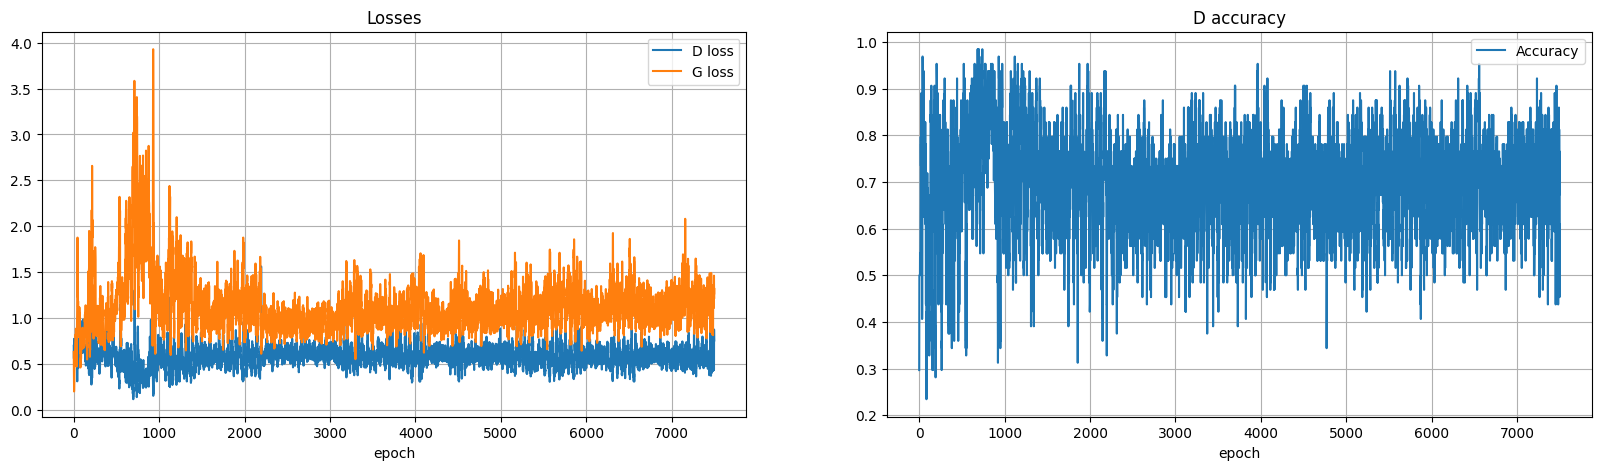

----EPOCH 4-----
0 [D loss: 0.6621,	 acc.: 64.06%]	[G loss: 0.9376]


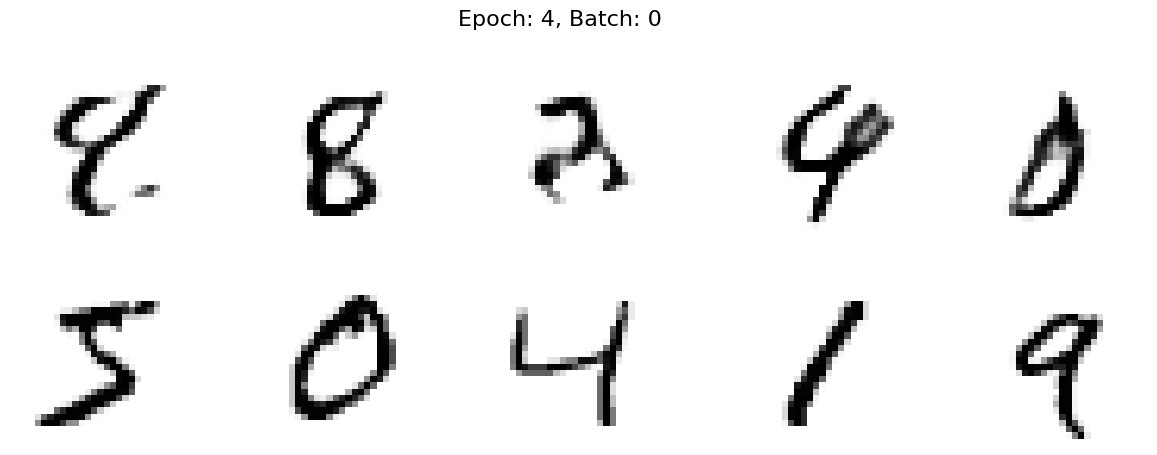

50 [D loss: 0.6112,	 acc.: 68.75%]	[G loss: 1.2807]
100 [D loss: 0.6464,	 acc.: 62.50%]	[G loss: 1.1331]
150 [D loss: 0.5510,	 acc.: 78.12%]	[G loss: 0.9461]
200 [D loss: 0.5735,	 acc.: 65.62%]	[G loss: 1.3535]
250 [D loss: 0.4845,	 acc.: 76.56%]	[G loss: 1.2317]
300 [D loss: 0.6229,	 acc.: 70.31%]	[G loss: 1.3754]
350 [D loss: 0.7004,	 acc.: 57.81%]	[G loss: 1.0692]
400 [D loss: 0.6305,	 acc.: 65.62%]	[G loss: 1.0877]
450 [D loss: 0.6045,	 acc.: 64.06%]	[G loss: 1.1107]
500 [D loss: 0.6781,	 acc.: 59.38%]	[G loss: 0.9721]


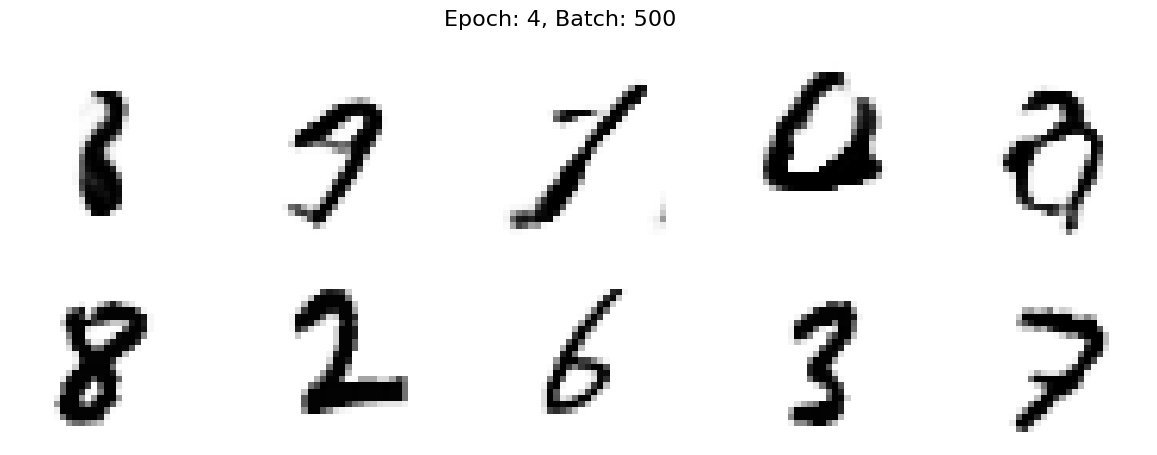

550 [D loss: 0.6246,	 acc.: 67.19%]	[G loss: 1.1598]
600 [D loss: 0.5001,	 acc.: 73.44%]	[G loss: 0.9967]
650 [D loss: 0.5476,	 acc.: 68.75%]	[G loss: 1.1299]
700 [D loss: 0.6008,	 acc.: 67.19%]	[G loss: 0.9684]
750 [D loss: 0.6475,	 acc.: 64.06%]	[G loss: 1.2066]
800 [D loss: 0.6771,	 acc.: 57.81%]	[G loss: 0.7503]
850 [D loss: 0.5181,	 acc.: 75.00%]	[G loss: 1.4038]
900 [D loss: 0.4730,	 acc.: 73.44%]	[G loss: 1.2056]
950 [D loss: 0.5763,	 acc.: 73.44%]	[G loss: 1.3170]
1000 [D loss: 0.7134,	 acc.: 59.38%]	[G loss: 1.1686]


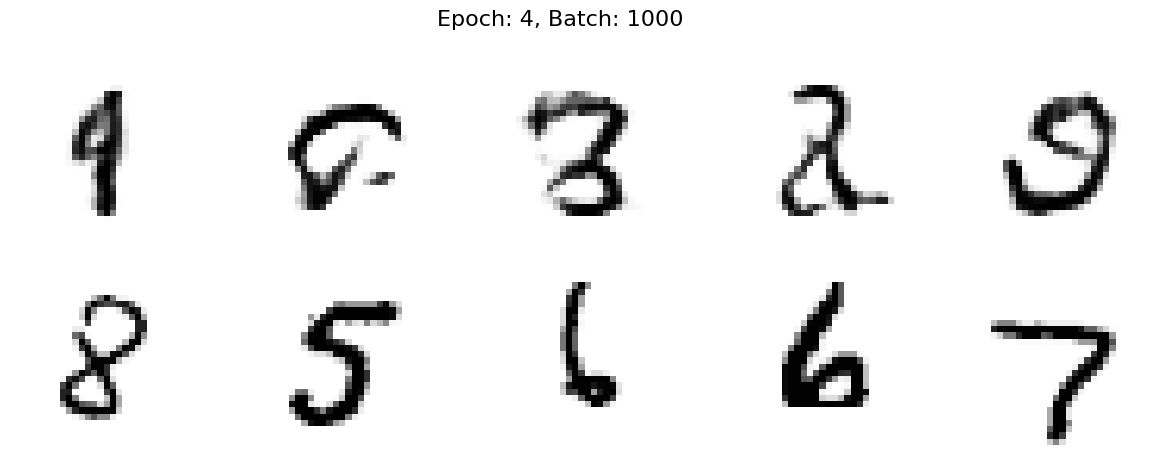

1050 [D loss: 0.4408,	 acc.: 81.25%]	[G loss: 1.3516]
1100 [D loss: 0.4963,	 acc.: 76.56%]	[G loss: 1.3126]
1150 [D loss: 0.6635,	 acc.: 62.50%]	[G loss: 1.0574]
1200 [D loss: 0.6206,	 acc.: 70.31%]	[G loss: 1.2067]
1250 [D loss: 0.5533,	 acc.: 67.19%]	[G loss: 1.1499]
1300 [D loss: 0.5483,	 acc.: 70.31%]	[G loss: 1.1556]
1350 [D loss: 0.5659,	 acc.: 70.31%]	[G loss: 0.9822]
1400 [D loss: 0.5444,	 acc.: 67.19%]	[G loss: 1.0671]
1450 [D loss: 0.5363,	 acc.: 70.31%]	[G loss: 1.2189]
1500 [D loss: 0.5333,	 acc.: 75.00%]	[G loss: 1.0855]


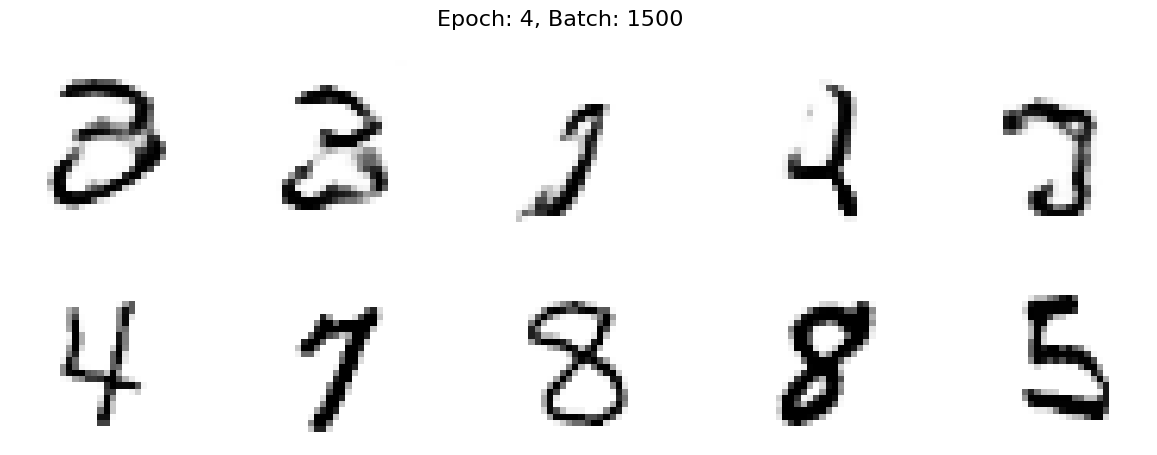

1550 [D loss: 0.5804,	 acc.: 65.62%]	[G loss: 1.3489]
1600 [D loss: 0.6830,	 acc.: 67.19%]	[G loss: 0.9502]
1650 [D loss: 0.6651,	 acc.: 62.50%]	[G loss: 1.0618]
1700 [D loss: 0.5194,	 acc.: 75.00%]	[G loss: 0.8722]
1750 [D loss: 0.5211,	 acc.: 75.00%]	[G loss: 1.2460]
1800 [D loss: 0.4477,	 acc.: 81.25%]	[G loss: 1.1755]
1850 [D loss: 0.6526,	 acc.: 67.19%]	[G loss: 1.5133]


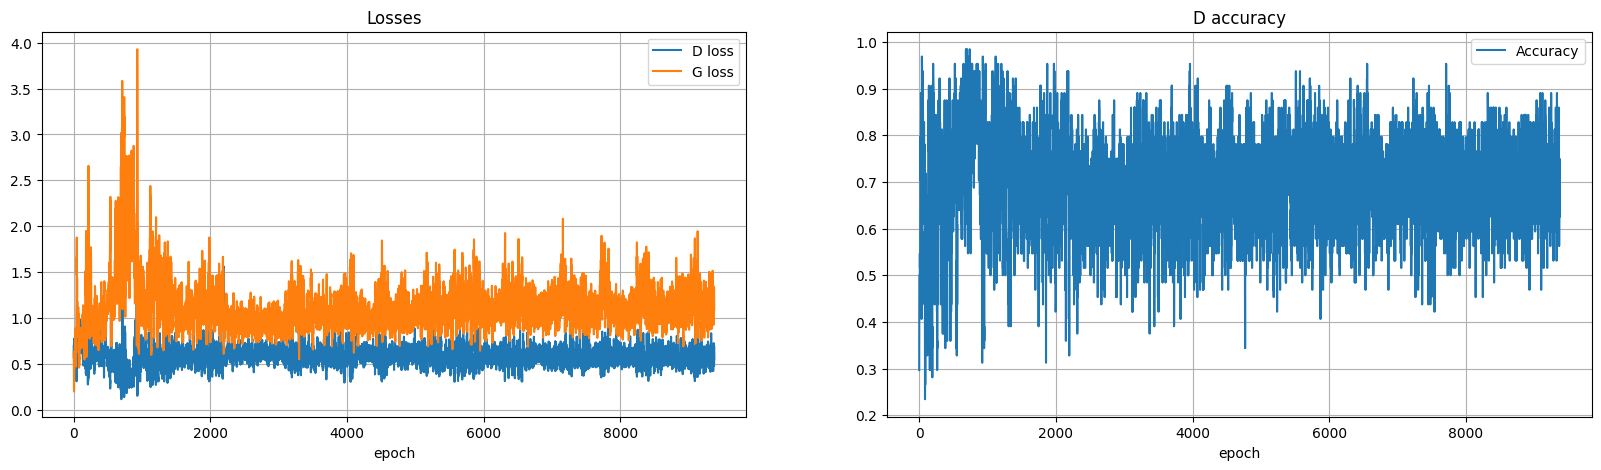

----EPOCH 5-----
0 [D loss: 0.6769,	 acc.: 60.94%]	[G loss: 1.1110]


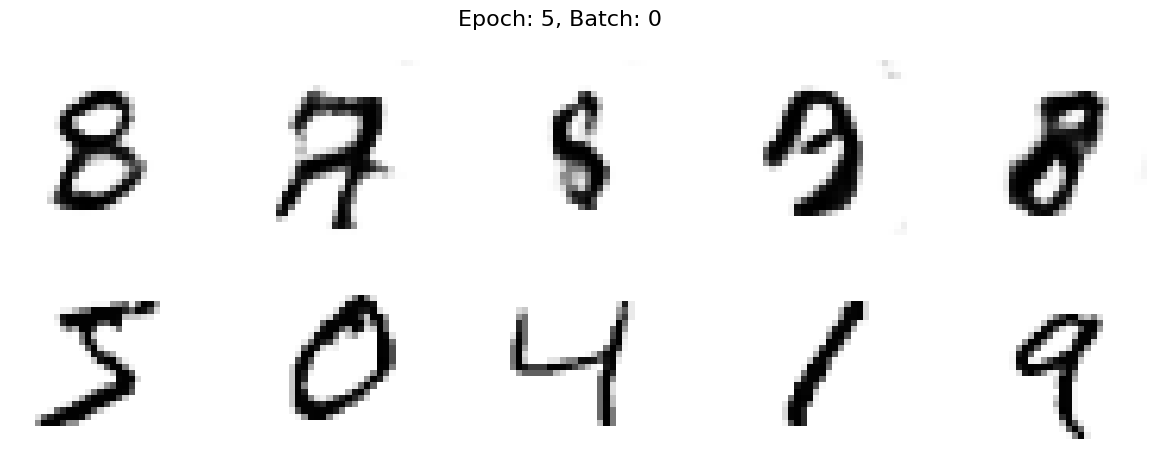

50 [D loss: 0.5034,	 acc.: 76.56%]	[G loss: 1.2434]
100 [D loss: 0.4360,	 acc.: 84.38%]	[G loss: 1.2945]
150 [D loss: 0.6528,	 acc.: 68.75%]	[G loss: 1.4200]
200 [D loss: 0.5000,	 acc.: 73.44%]	[G loss: 1.1176]
250 [D loss: 0.4950,	 acc.: 73.44%]	[G loss: 1.1063]
300 [D loss: 0.4771,	 acc.: 79.69%]	[G loss: 1.2523]
350 [D loss: 0.8967,	 acc.: 54.69%]	[G loss: 0.8974]
400 [D loss: 0.5244,	 acc.: 75.00%]	[G loss: 1.1701]
450 [D loss: 0.6690,	 acc.: 71.88%]	[G loss: 0.9194]
500 [D loss: 0.6504,	 acc.: 65.62%]	[G loss: 1.0639]


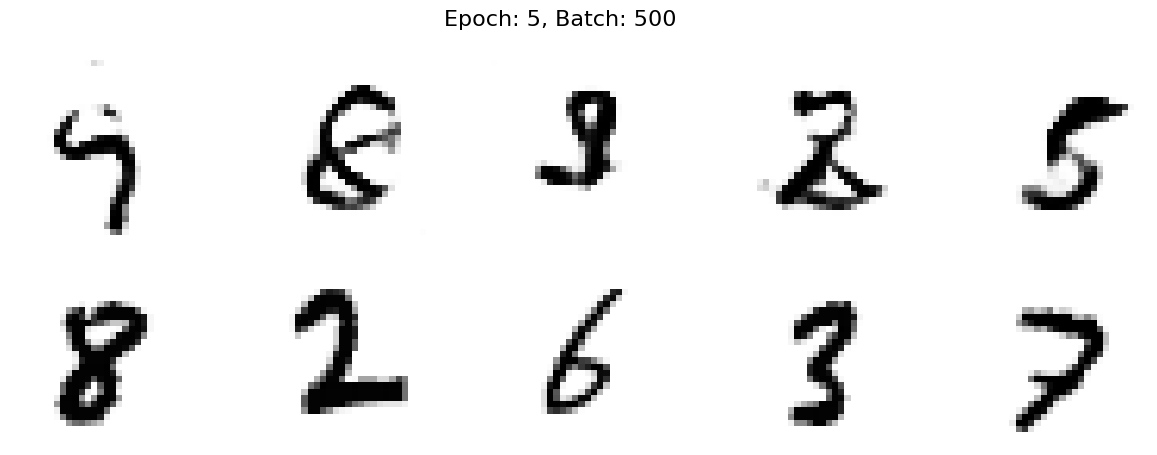

550 [D loss: 0.5372,	 acc.: 75.00%]	[G loss: 0.9297]
600 [D loss: 0.5763,	 acc.: 70.31%]	[G loss: 1.1060]
650 [D loss: 0.6059,	 acc.: 64.06%]	[G loss: 1.1266]
700 [D loss: 0.6232,	 acc.: 68.75%]	[G loss: 1.1107]
750 [D loss: 0.6695,	 acc.: 70.31%]	[G loss: 1.1328]
800 [D loss: 0.6290,	 acc.: 62.50%]	[G loss: 0.9961]
850 [D loss: 0.5310,	 acc.: 73.44%]	[G loss: 1.0856]
900 [D loss: 0.6130,	 acc.: 68.75%]	[G loss: 1.1229]
950 [D loss: 0.6552,	 acc.: 64.06%]	[G loss: 0.9638]
1000 [D loss: 0.5361,	 acc.: 71.88%]	[G loss: 1.2214]


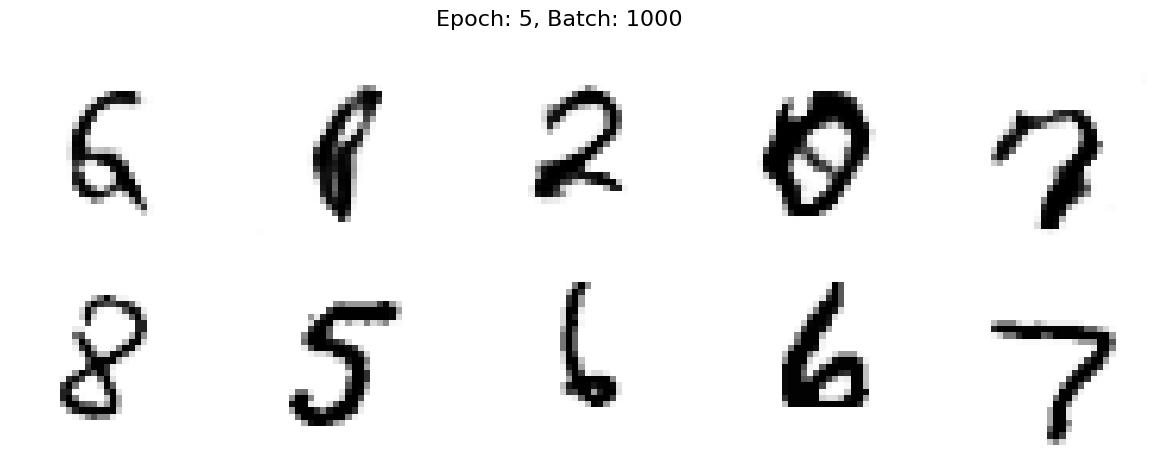

1050 [D loss: 0.5540,	 acc.: 71.88%]	[G loss: 1.2124]
1100 [D loss: 0.5160,	 acc.: 71.88%]	[G loss: 1.2840]
1150 [D loss: 0.7013,	 acc.: 62.50%]	[G loss: 1.0196]
1200 [D loss: 0.6546,	 acc.: 64.06%]	[G loss: 1.0713]
1250 [D loss: 0.6421,	 acc.: 70.31%]	[G loss: 1.0693]
1300 [D loss: 0.5315,	 acc.: 73.44%]	[G loss: 1.3811]
1350 [D loss: 0.5108,	 acc.: 78.12%]	[G loss: 1.1469]
1400 [D loss: 0.4595,	 acc.: 84.38%]	[G loss: 1.2348]
1450 [D loss: 0.6150,	 acc.: 65.62%]	[G loss: 0.9830]
1500 [D loss: 0.7085,	 acc.: 65.62%]	[G loss: 0.8509]


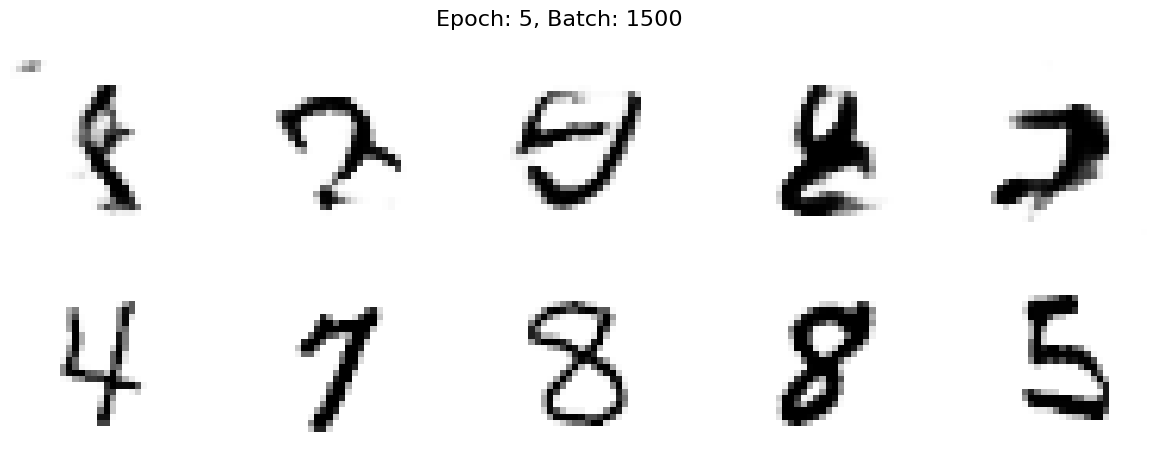

1550 [D loss: 0.6674,	 acc.: 62.50%]	[G loss: 1.1482]
1600 [D loss: 0.6915,	 acc.: 57.81%]	[G loss: 0.7525]
1650 [D loss: 0.6204,	 acc.: 65.62%]	[G loss: 0.9810]
1700 [D loss: 0.6021,	 acc.: 68.75%]	[G loss: 1.1482]
1750 [D loss: 0.5173,	 acc.: 67.19%]	[G loss: 1.0418]
1800 [D loss: 0.5748,	 acc.: 70.31%]	[G loss: 1.0207]
1850 [D loss: 0.5594,	 acc.: 71.88%]	[G loss: 1.1688]


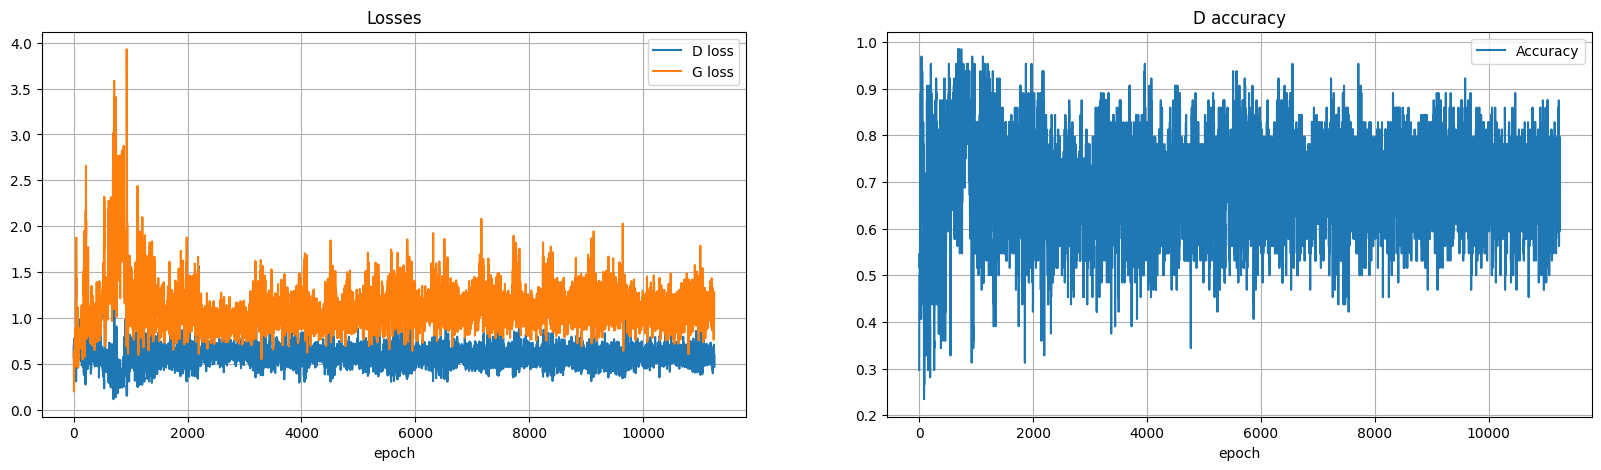

----EPOCH 6-----
0 [D loss: 0.5390,	 acc.: 67.19%]	[G loss: 1.5070]


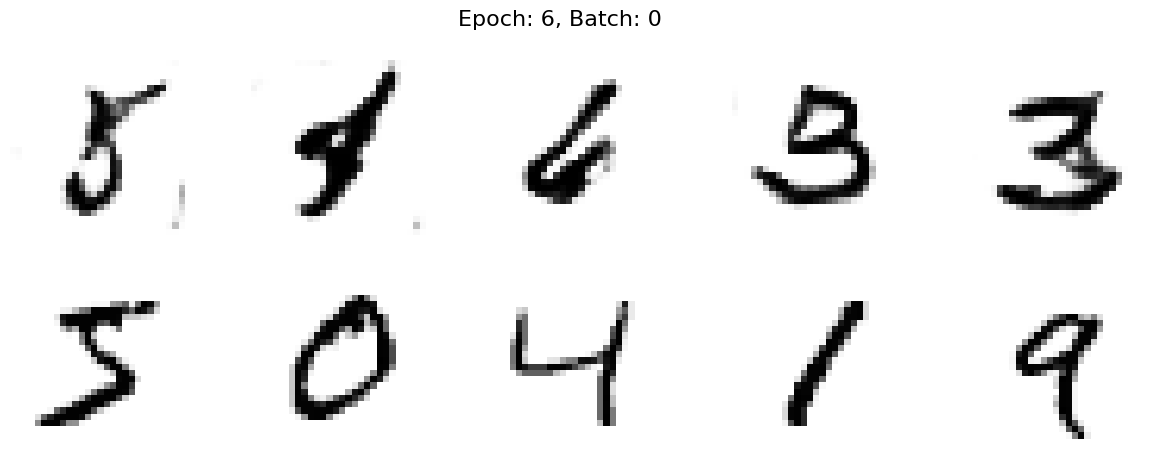

50 [D loss: 0.6845,	 acc.: 64.06%]	[G loss: 0.9331]
100 [D loss: 0.5259,	 acc.: 75.00%]	[G loss: 1.2259]
150 [D loss: 0.5428,	 acc.: 70.31%]	[G loss: 1.2483]
200 [D loss: 0.5238,	 acc.: 67.19%]	[G loss: 1.1140]
250 [D loss: 0.5905,	 acc.: 67.19%]	[G loss: 1.1214]
300 [D loss: 0.5479,	 acc.: 75.00%]	[G loss: 1.2641]
350 [D loss: 0.6131,	 acc.: 65.62%]	[G loss: 1.1276]
400 [D loss: 0.5244,	 acc.: 68.75%]	[G loss: 0.8411]
450 [D loss: 0.5771,	 acc.: 67.19%]	[G loss: 0.8867]
500 [D loss: 0.6573,	 acc.: 67.19%]	[G loss: 1.0805]


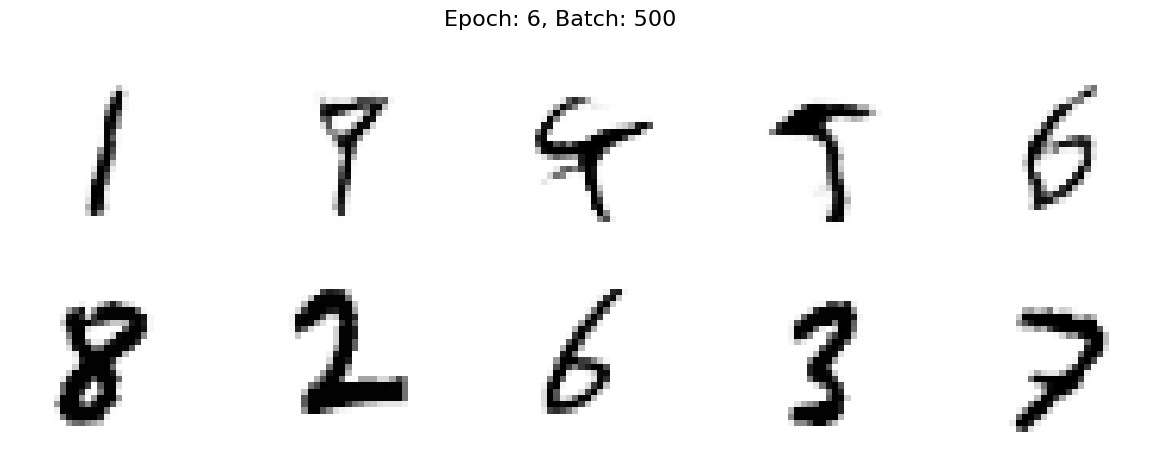

550 [D loss: 0.5928,	 acc.: 62.50%]	[G loss: 1.0178]
600 [D loss: 0.5562,	 acc.: 68.75%]	[G loss: 1.1632]
650 [D loss: 0.5211,	 acc.: 75.00%]	[G loss: 0.9773]
700 [D loss: 0.5118,	 acc.: 76.56%]	[G loss: 1.1219]
750 [D loss: 0.5684,	 acc.: 68.75%]	[G loss: 1.3620]
800 [D loss: 0.6014,	 acc.: 67.19%]	[G loss: 1.3142]
850 [D loss: 0.4957,	 acc.: 78.12%]	[G loss: 1.1139]
900 [D loss: 0.6530,	 acc.: 67.19%]	[G loss: 1.0806]
950 [D loss: 0.6585,	 acc.: 64.06%]	[G loss: 1.1255]
1000 [D loss: 0.7117,	 acc.: 56.25%]	[G loss: 0.9019]


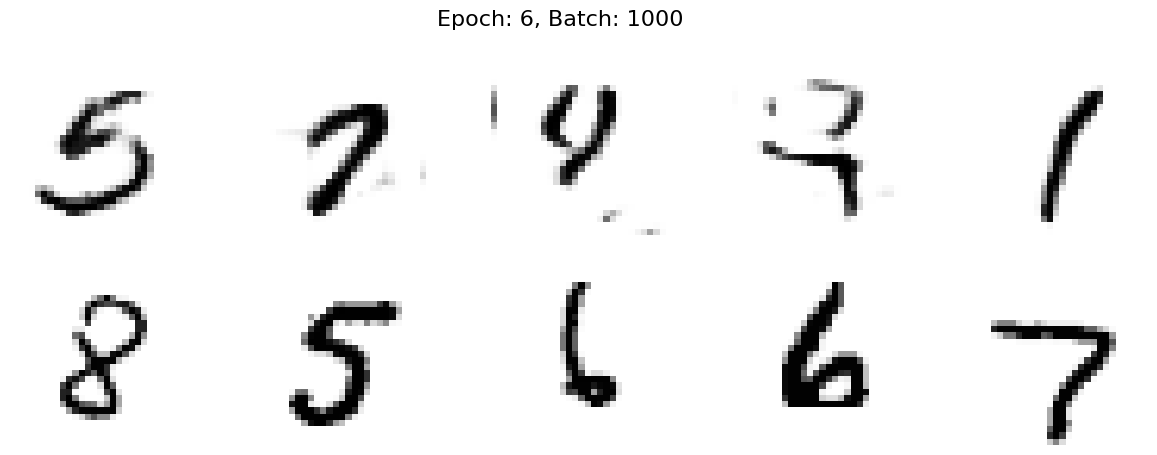

1050 [D loss: 0.5318,	 acc.: 78.12%]	[G loss: 1.1061]
1100 [D loss: 0.7217,	 acc.: 56.25%]	[G loss: 1.1054]
1150 [D loss: 0.5790,	 acc.: 62.50%]	[G loss: 1.2173]
1200 [D loss: 0.6603,	 acc.: 57.81%]	[G loss: 1.0360]
1250 [D loss: 0.6531,	 acc.: 64.06%]	[G loss: 1.1200]
1300 [D loss: 0.5937,	 acc.: 67.19%]	[G loss: 1.0739]
1350 [D loss: 0.5658,	 acc.: 67.19%]	[G loss: 0.9547]
1400 [D loss: 0.6203,	 acc.: 65.62%]	[G loss: 1.1373]
1450 [D loss: 0.4465,	 acc.: 79.69%]	[G loss: 1.2649]
1500 [D loss: 0.4783,	 acc.: 73.44%]	[G loss: 1.1909]


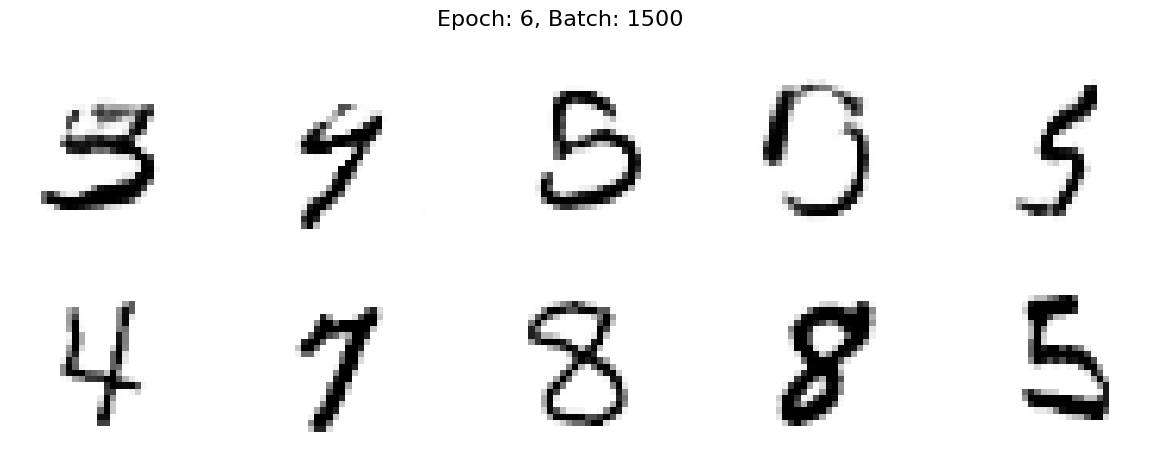

1550 [D loss: 0.5470,	 acc.: 71.88%]	[G loss: 1.0877]
1600 [D loss: 0.6060,	 acc.: 67.19%]	[G loss: 1.3229]
1650 [D loss: 0.6590,	 acc.: 59.38%]	[G loss: 1.1893]
1700 [D loss: 0.5336,	 acc.: 75.00%]	[G loss: 1.1068]
1750 [D loss: 0.5387,	 acc.: 76.56%]	[G loss: 1.0540]
1800 [D loss: 0.4738,	 acc.: 78.12%]	[G loss: 1.1730]
1850 [D loss: 0.5454,	 acc.: 73.44%]	[G loss: 1.2214]


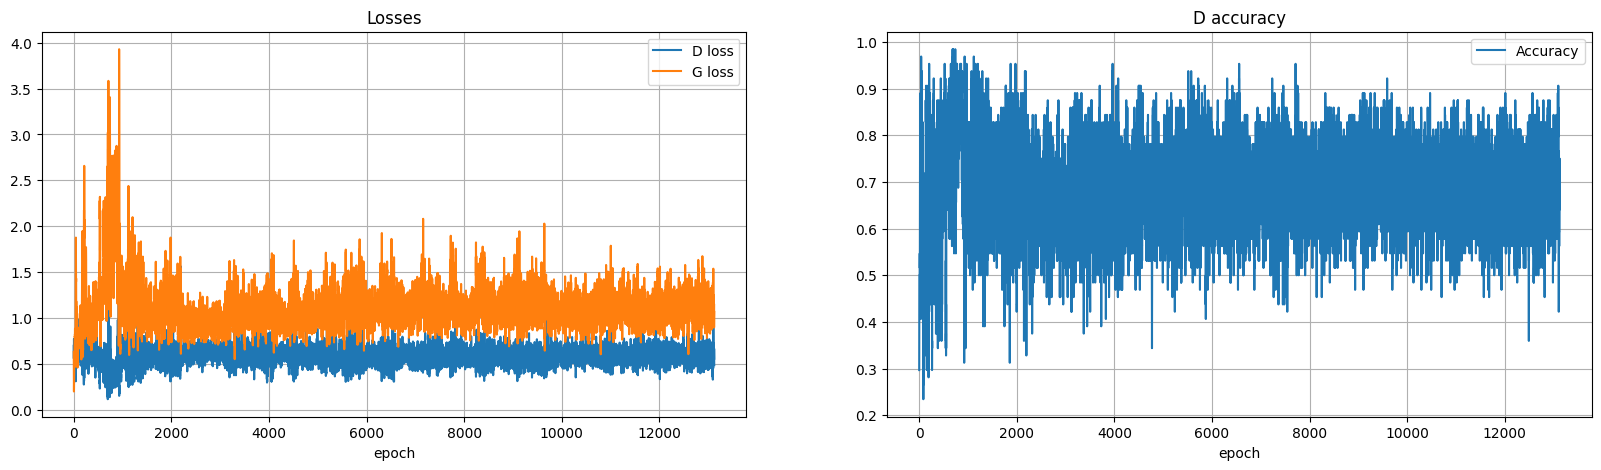

----EPOCH 7-----
0 [D loss: 0.7023,	 acc.: 57.81%]	[G loss: 1.1345]


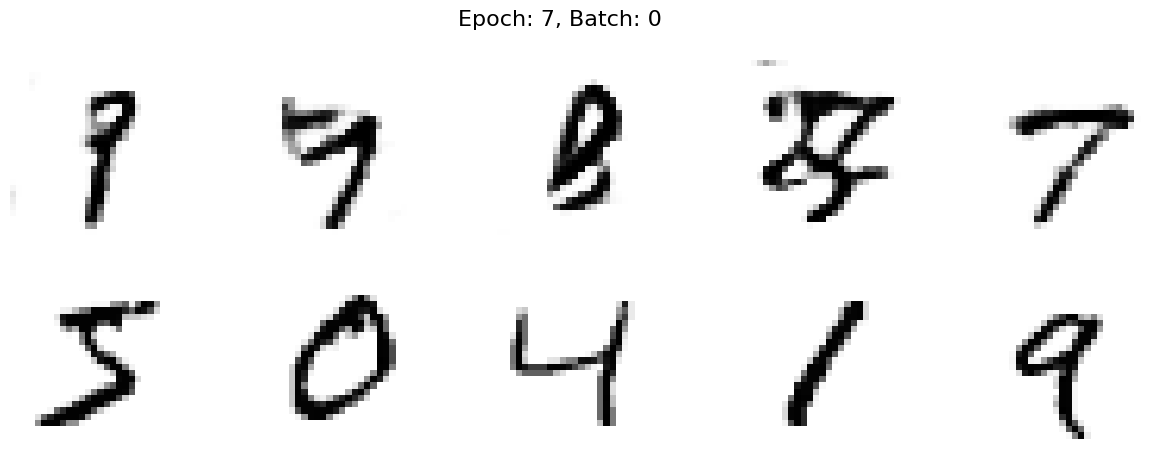

50 [D loss: 0.6973,	 acc.: 64.06%]	[G loss: 1.1262]
100 [D loss: 0.5921,	 acc.: 73.44%]	[G loss: 1.1616]
150 [D loss: 0.5980,	 acc.: 67.19%]	[G loss: 1.0428]
200 [D loss: 0.5643,	 acc.: 65.62%]	[G loss: 0.9540]
250 [D loss: 0.5445,	 acc.: 71.88%]	[G loss: 0.9959]
300 [D loss: 0.4668,	 acc.: 73.44%]	[G loss: 1.4201]
350 [D loss: 0.5920,	 acc.: 68.75%]	[G loss: 0.9932]
400 [D loss: 0.5278,	 acc.: 76.56%]	[G loss: 1.3943]
450 [D loss: 0.5794,	 acc.: 70.31%]	[G loss: 0.9530]
500 [D loss: 0.7576,	 acc.: 50.00%]	[G loss: 0.8466]


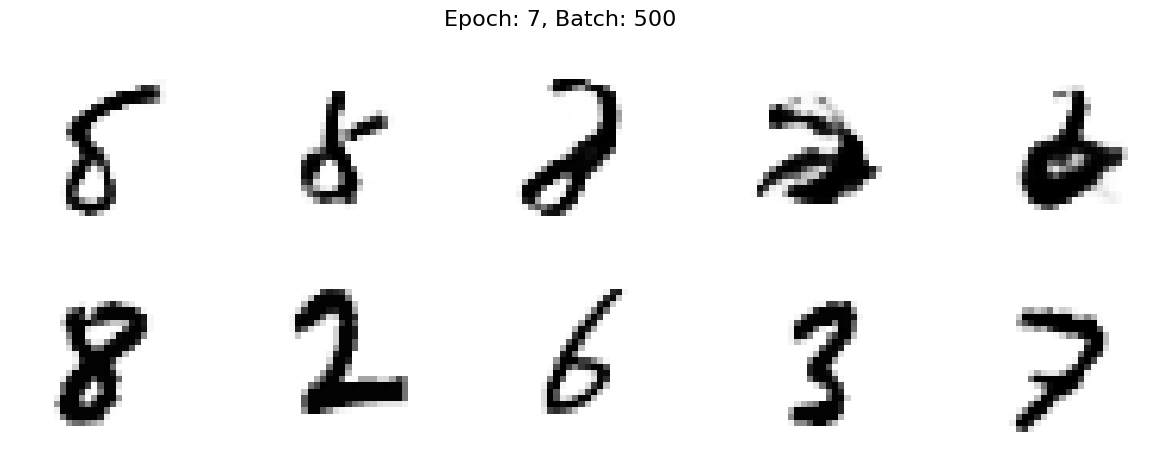

550 [D loss: 0.5996,	 acc.: 64.06%]	[G loss: 0.9094]
600 [D loss: 0.7360,	 acc.: 50.00%]	[G loss: 1.3550]
650 [D loss: 0.5435,	 acc.: 71.88%]	[G loss: 1.0385]
700 [D loss: 0.6161,	 acc.: 70.31%]	[G loss: 1.0915]
750 [D loss: 0.7056,	 acc.: 59.38%]	[G loss: 1.1075]
800 [D loss: 0.6085,	 acc.: 67.19%]	[G loss: 1.0734]
850 [D loss: 0.6238,	 acc.: 68.75%]	[G loss: 1.0957]
900 [D loss: 0.6373,	 acc.: 60.94%]	[G loss: 0.9457]
950 [D loss: 0.5994,	 acc.: 59.38%]	[G loss: 1.0713]
1000 [D loss: 0.6988,	 acc.: 60.94%]	[G loss: 1.1164]


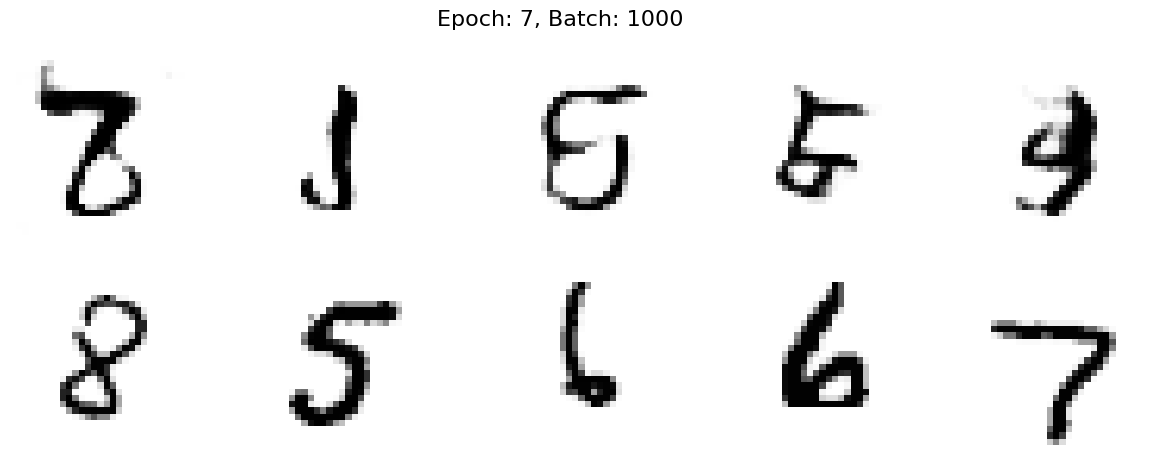

1050 [D loss: 0.5801,	 acc.: 75.00%]	[G loss: 1.1832]
1100 [D loss: 0.6635,	 acc.: 64.06%]	[G loss: 1.0872]
1150 [D loss: 0.6124,	 acc.: 68.75%]	[G loss: 1.1686]
1200 [D loss: 0.5638,	 acc.: 68.75%]	[G loss: 0.8308]
1250 [D loss: 0.5597,	 acc.: 76.56%]	[G loss: 1.0460]
1300 [D loss: 0.6640,	 acc.: 62.50%]	[G loss: 1.1080]
1350 [D loss: 0.5619,	 acc.: 65.62%]	[G loss: 1.0104]
1400 [D loss: 0.5888,	 acc.: 70.31%]	[G loss: 1.2039]
1450 [D loss: 0.6325,	 acc.: 62.50%]	[G loss: 1.3411]
1500 [D loss: 0.6911,	 acc.: 59.38%]	[G loss: 1.0103]


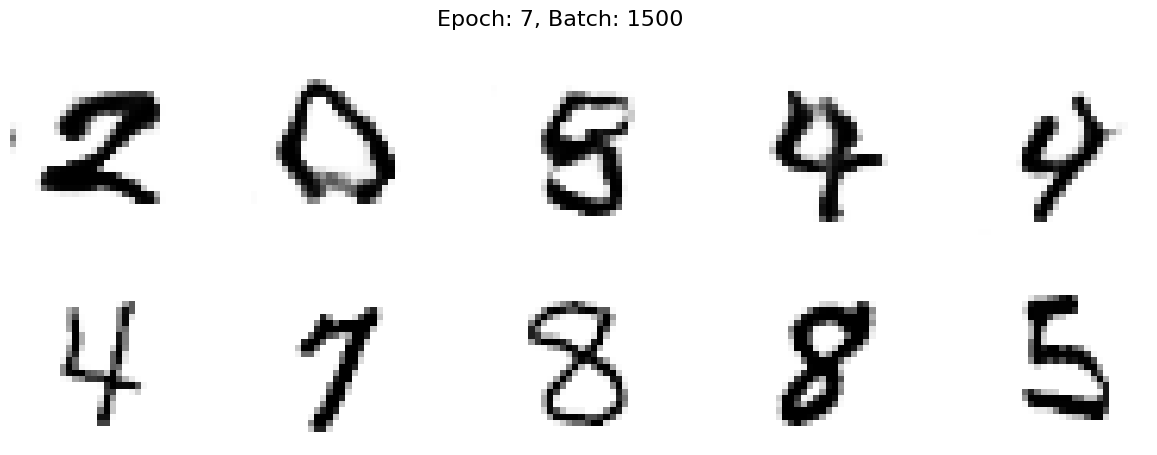

1550 [D loss: 0.7084,	 acc.: 64.06%]	[G loss: 0.8948]
1600 [D loss: 0.6808,	 acc.: 64.06%]	[G loss: 1.0709]
1650 [D loss: 0.5876,	 acc.: 68.75%]	[G loss: 1.1400]
1700 [D loss: 0.6550,	 acc.: 65.62%]	[G loss: 1.2016]
1750 [D loss: 0.5866,	 acc.: 70.31%]	[G loss: 1.1287]
1800 [D loss: 0.5848,	 acc.: 65.62%]	[G loss: 0.8945]
1850 [D loss: 0.5835,	 acc.: 68.75%]	[G loss: 1.0020]


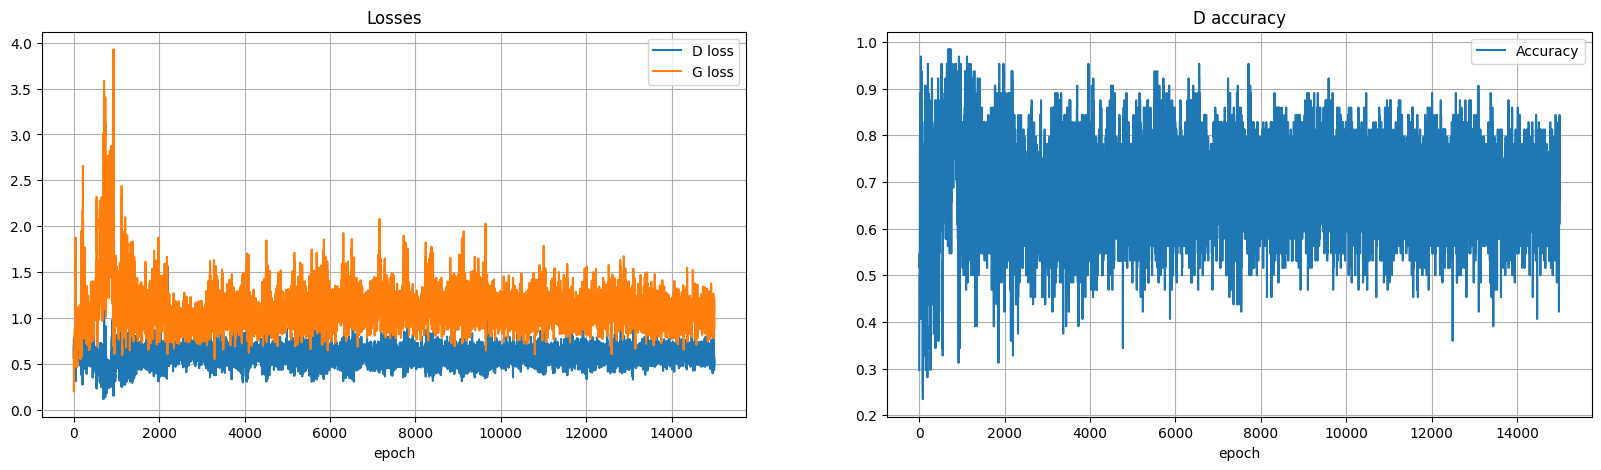

----EPOCH 8-----
0 [D loss: 0.6222,	 acc.: 65.62%]	[G loss: 1.0439]


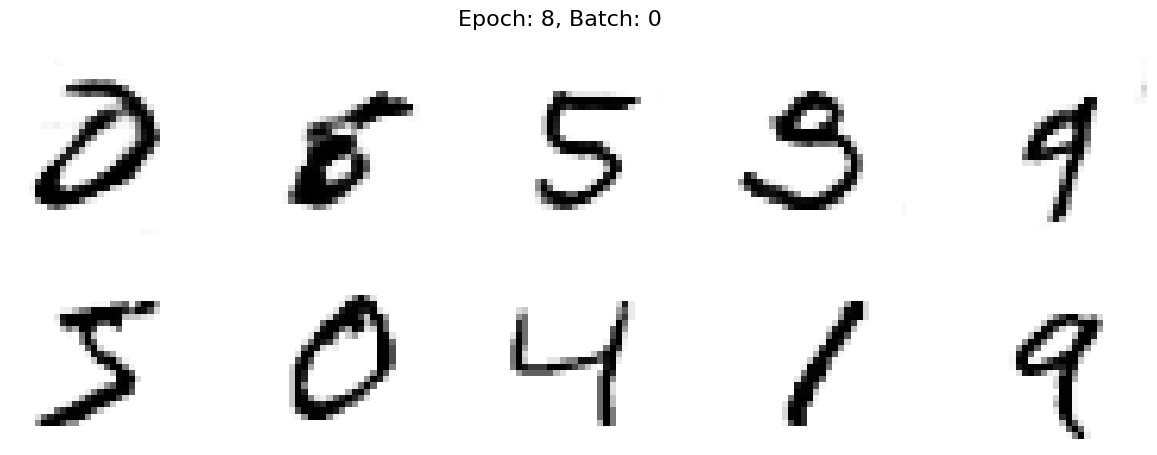

50 [D loss: 0.6143,	 acc.: 68.75%]	[G loss: 1.0060]
100 [D loss: 0.6442,	 acc.: 64.06%]	[G loss: 0.9842]
150 [D loss: 0.6196,	 acc.: 64.06%]	[G loss: 0.9127]
200 [D loss: 0.5458,	 acc.: 76.56%]	[G loss: 1.0331]
250 [D loss: 0.5904,	 acc.: 67.19%]	[G loss: 1.0426]
300 [D loss: 0.3782,	 acc.: 84.38%]	[G loss: 1.1963]
350 [D loss: 0.5598,	 acc.: 71.88%]	[G loss: 1.0469]
400 [D loss: 0.5256,	 acc.: 73.44%]	[G loss: 1.0527]
450 [D loss: 0.6471,	 acc.: 50.00%]	[G loss: 1.0508]
500 [D loss: 0.7458,	 acc.: 53.12%]	[G loss: 0.8154]


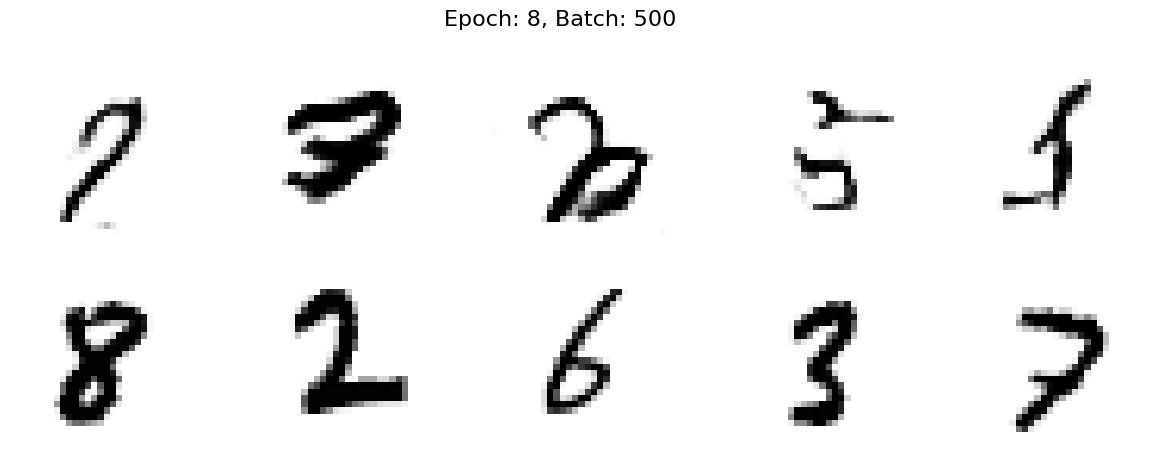

550 [D loss: 0.5439,	 acc.: 75.00%]	[G loss: 0.8235]
600 [D loss: 0.6815,	 acc.: 60.94%]	[G loss: 0.9533]
650 [D loss: 0.6318,	 acc.: 62.50%]	[G loss: 1.1209]
700 [D loss: 0.5770,	 acc.: 67.19%]	[G loss: 0.9560]
750 [D loss: 0.7562,	 acc.: 53.12%]	[G loss: 0.9931]
800 [D loss: 0.5919,	 acc.: 65.62%]	[G loss: 1.0396]
850 [D loss: 0.7090,	 acc.: 62.50%]	[G loss: 1.1997]
900 [D loss: 0.5918,	 acc.: 64.06%]	[G loss: 1.0831]
950 [D loss: 0.6050,	 acc.: 62.50%]	[G loss: 0.9429]
1000 [D loss: 0.6994,	 acc.: 59.38%]	[G loss: 1.0498]


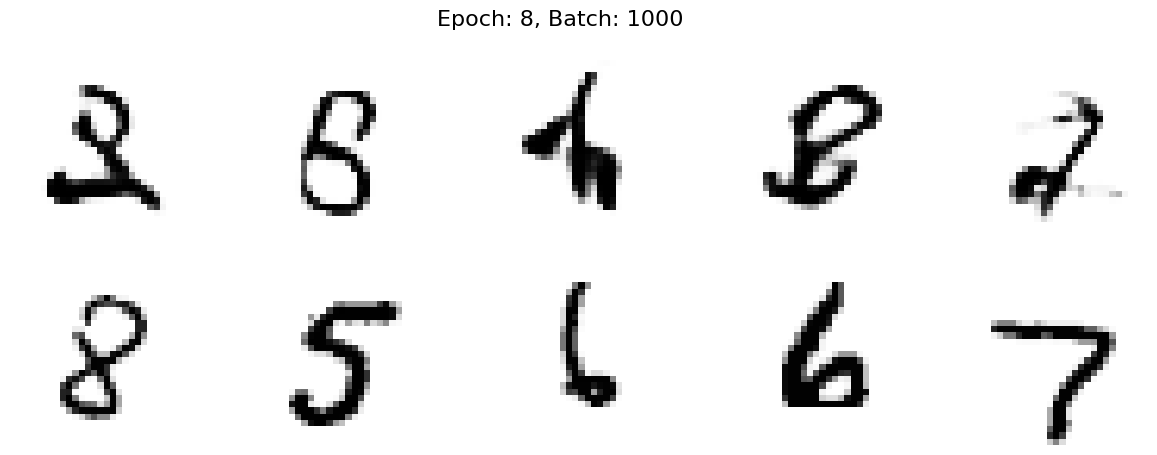

1050 [D loss: 0.5733,	 acc.: 68.75%]	[G loss: 1.0540]
1100 [D loss: 0.7207,	 acc.: 60.94%]	[G loss: 1.0380]
1150 [D loss: 0.6589,	 acc.: 67.19%]	[G loss: 1.2015]
1200 [D loss: 0.5362,	 acc.: 76.56%]	[G loss: 0.9504]
1250 [D loss: 0.6077,	 acc.: 67.19%]	[G loss: 0.8560]
1300 [D loss: 0.6454,	 acc.: 60.94%]	[G loss: 1.0600]
1350 [D loss: 0.6560,	 acc.: 59.38%]	[G loss: 0.8623]
1400 [D loss: 0.5641,	 acc.: 70.31%]	[G loss: 1.0937]
1450 [D loss: 0.6298,	 acc.: 65.62%]	[G loss: 1.3954]
1500 [D loss: 0.6974,	 acc.: 65.62%]	[G loss: 0.7893]


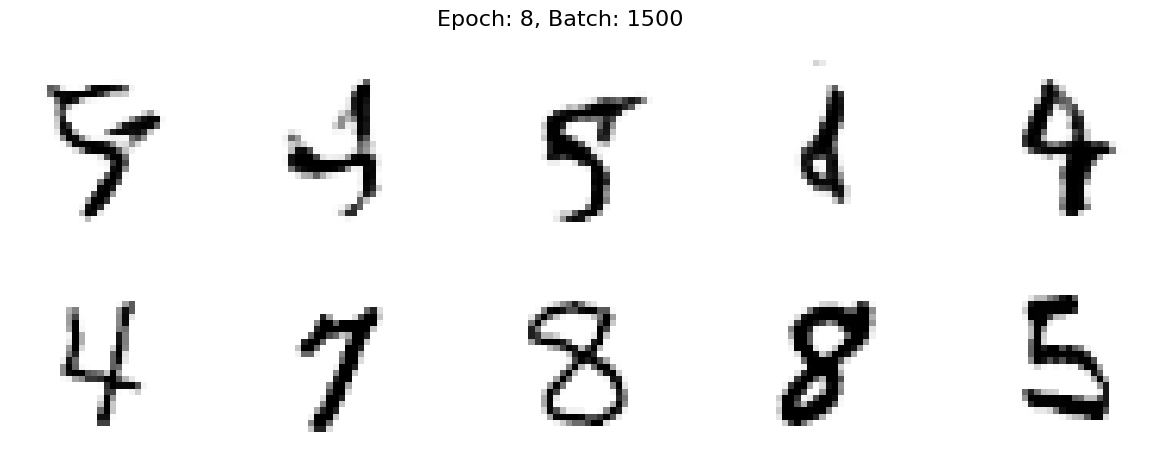

1550 [D loss: 0.7819,	 acc.: 57.81%]	[G loss: 0.9740]
1600 [D loss: 0.7936,	 acc.: 51.56%]	[G loss: 0.9013]
1650 [D loss: 0.7525,	 acc.: 53.12%]	[G loss: 1.1132]
1700 [D loss: 0.6856,	 acc.: 67.19%]	[G loss: 0.9861]
1750 [D loss: 0.6728,	 acc.: 59.38%]	[G loss: 0.8492]
1800 [D loss: 0.5722,	 acc.: 68.75%]	[G loss: 1.1537]
1850 [D loss: 0.6545,	 acc.: 73.44%]	[G loss: 1.1979]


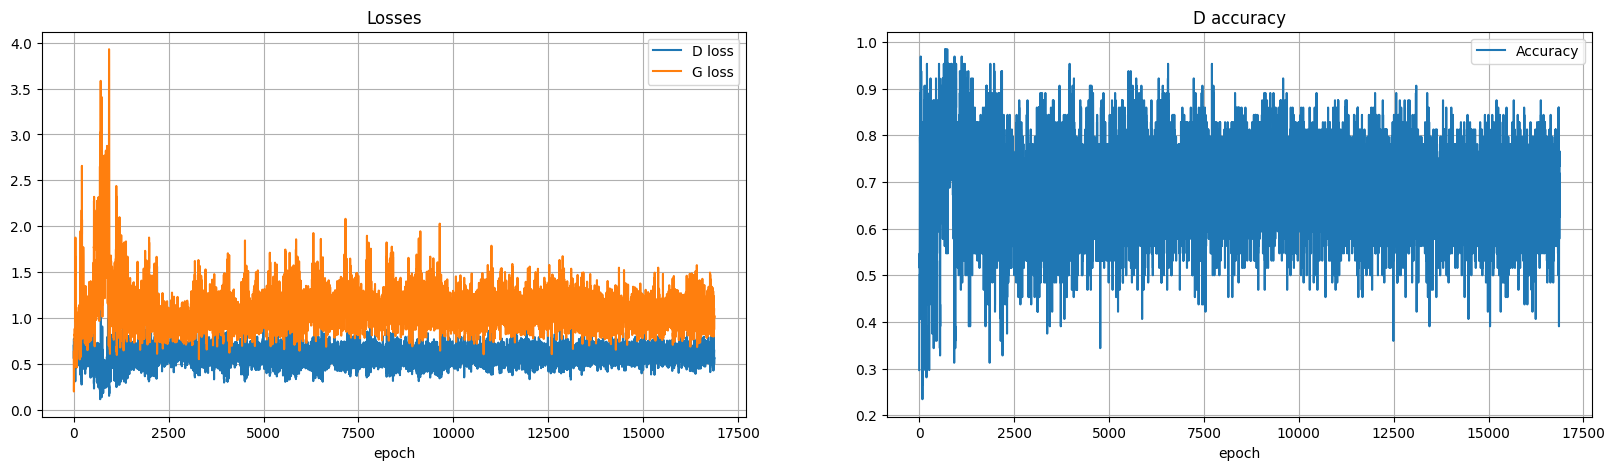

----EPOCH 9-----
0 [D loss: 0.6430,	 acc.: 62.50%]	[G loss: 1.1457]


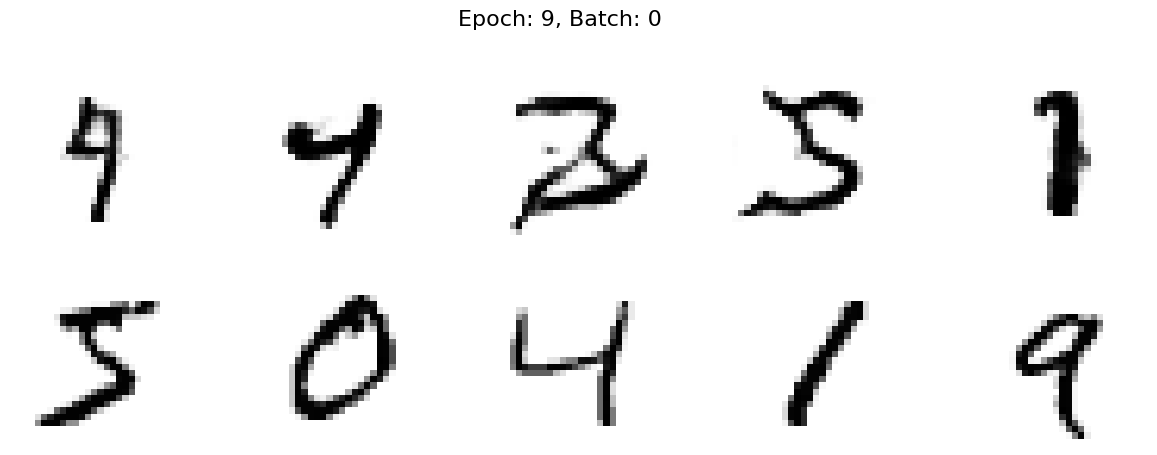

50 [D loss: 0.6214,	 acc.: 64.06%]	[G loss: 1.0838]
100 [D loss: 0.6162,	 acc.: 67.19%]	[G loss: 1.2346]
150 [D loss: 0.6539,	 acc.: 62.50%]	[G loss: 0.9930]
200 [D loss: 0.6048,	 acc.: 71.88%]	[G loss: 0.9854]
250 [D loss: 0.5370,	 acc.: 75.00%]	[G loss: 0.9442]
300 [D loss: 0.4731,	 acc.: 79.69%]	[G loss: 1.3674]
350 [D loss: 0.7449,	 acc.: 57.81%]	[G loss: 1.0302]
400 [D loss: 0.5251,	 acc.: 75.00%]	[G loss: 1.0973]
450 [D loss: 0.6389,	 acc.: 65.62%]	[G loss: 0.8211]
500 [D loss: 0.7461,	 acc.: 51.56%]	[G loss: 1.0623]


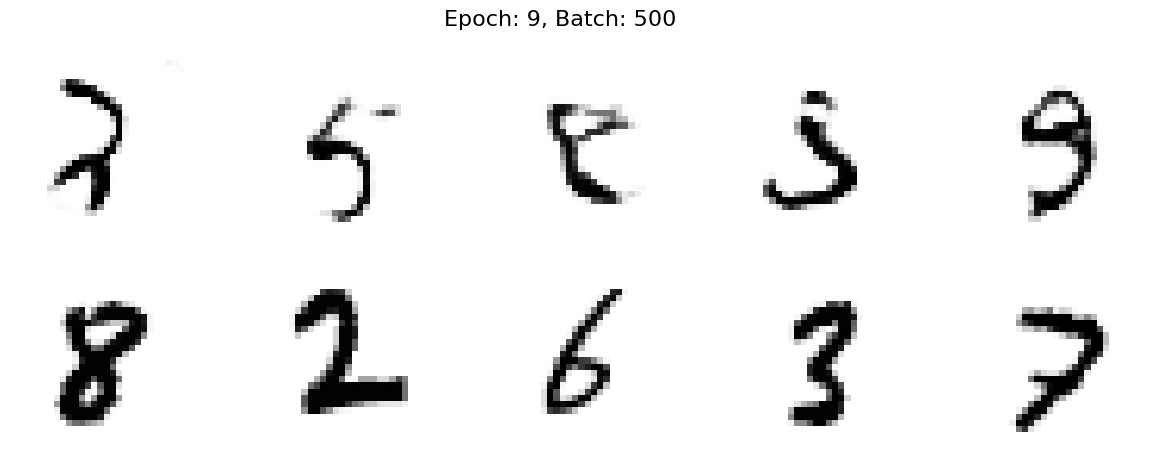

550 [D loss: 0.6128,	 acc.: 59.38%]	[G loss: 0.6859]
600 [D loss: 0.6560,	 acc.: 56.25%]	[G loss: 1.0505]
650 [D loss: 0.5851,	 acc.: 68.75%]	[G loss: 1.0163]
700 [D loss: 0.7875,	 acc.: 50.00%]	[G loss: 0.9586]
750 [D loss: 0.7479,	 acc.: 51.56%]	[G loss: 1.3182]
800 [D loss: 0.6686,	 acc.: 59.38%]	[G loss: 1.0701]
850 [D loss: 0.6108,	 acc.: 60.94%]	[G loss: 0.9061]
900 [D loss: 0.6307,	 acc.: 60.94%]	[G loss: 0.8859]
950 [D loss: 0.5880,	 acc.: 67.19%]	[G loss: 1.0800]
1000 [D loss: 0.6530,	 acc.: 62.50%]	[G loss: 1.0464]


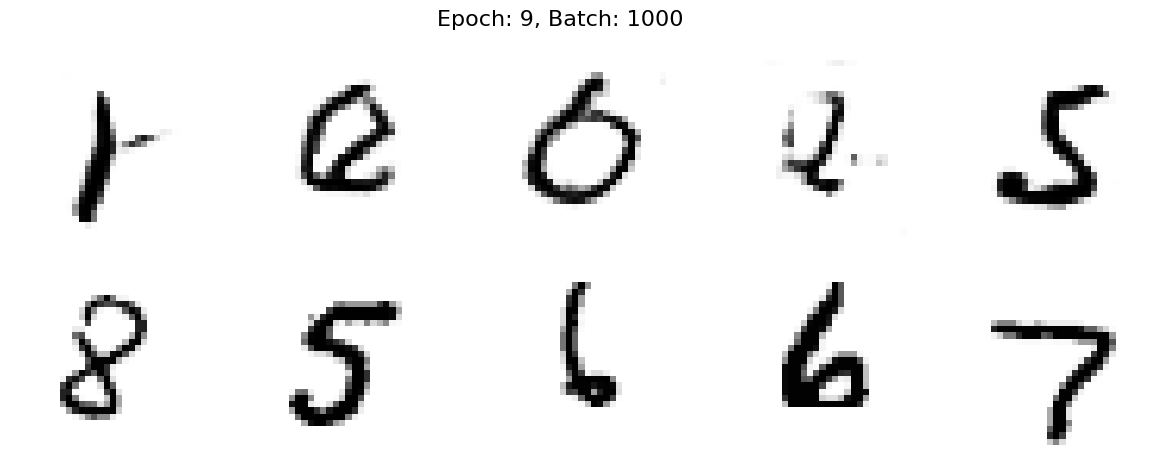

1050 [D loss: 0.5191,	 acc.: 81.25%]	[G loss: 0.9898]
1100 [D loss: 0.5825,	 acc.: 64.06%]	[G loss: 1.0026]
1150 [D loss: 0.7127,	 acc.: 54.69%]	[G loss: 0.8457]
1200 [D loss: 0.6124,	 acc.: 64.06%]	[G loss: 1.0160]
1250 [D loss: 0.6282,	 acc.: 68.75%]	[G loss: 0.8893]
1300 [D loss: 0.6428,	 acc.: 65.62%]	[G loss: 1.0779]
1350 [D loss: 0.5208,	 acc.: 68.75%]	[G loss: 0.9870]
1400 [D loss: 0.6292,	 acc.: 65.62%]	[G loss: 1.0220]
1450 [D loss: 0.6247,	 acc.: 64.06%]	[G loss: 0.8300]
1500 [D loss: 0.6451,	 acc.: 62.50%]	[G loss: 0.7504]


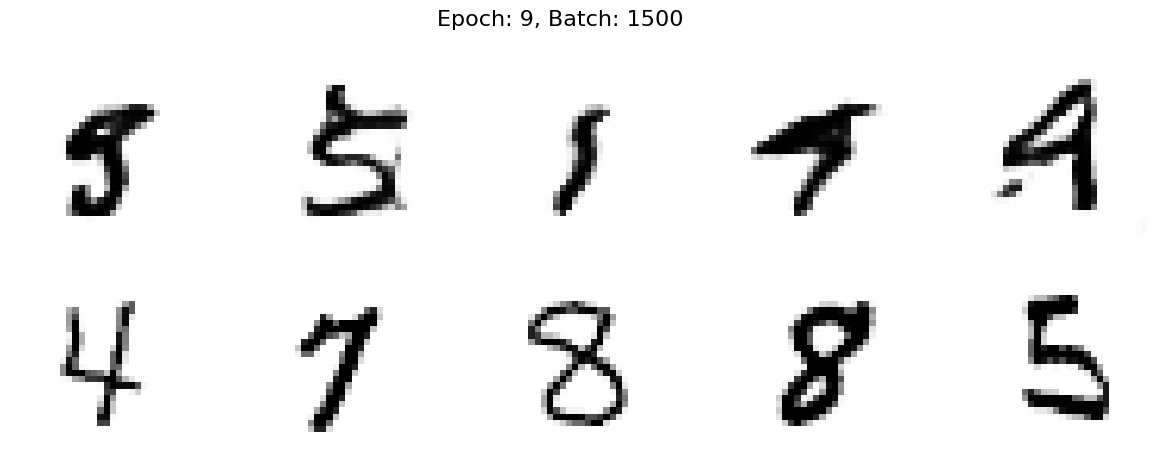

1550 [D loss: 0.5950,	 acc.: 65.62%]	[G loss: 1.0463]
1600 [D loss: 0.4806,	 acc.: 79.69%]	[G loss: 1.0990]
1650 [D loss: 0.6174,	 acc.: 62.50%]	[G loss: 1.0767]
1700 [D loss: 0.7086,	 acc.: 53.12%]	[G loss: 1.2091]
1750 [D loss: 0.6462,	 acc.: 59.38%]	[G loss: 0.8411]
1800 [D loss: 0.4731,	 acc.: 79.69%]	[G loss: 0.8026]
1850 [D loss: 0.5001,	 acc.: 78.12%]	[G loss: 1.0547]


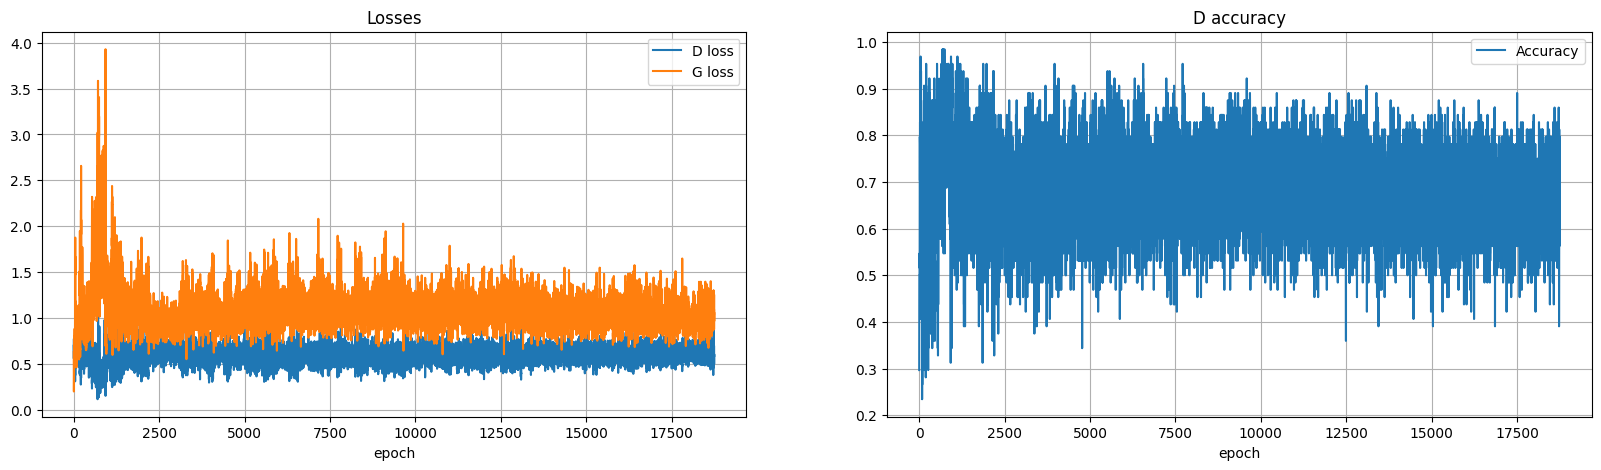

In [36]:
train(X_train, generator, discriminator, combined, epochs=10, batch_size=32, sample_interval=100)

----EPOCH 0-----
0 [D loss: 0.5873,	 acc.: 70.31%]	[G loss: 1.0313]


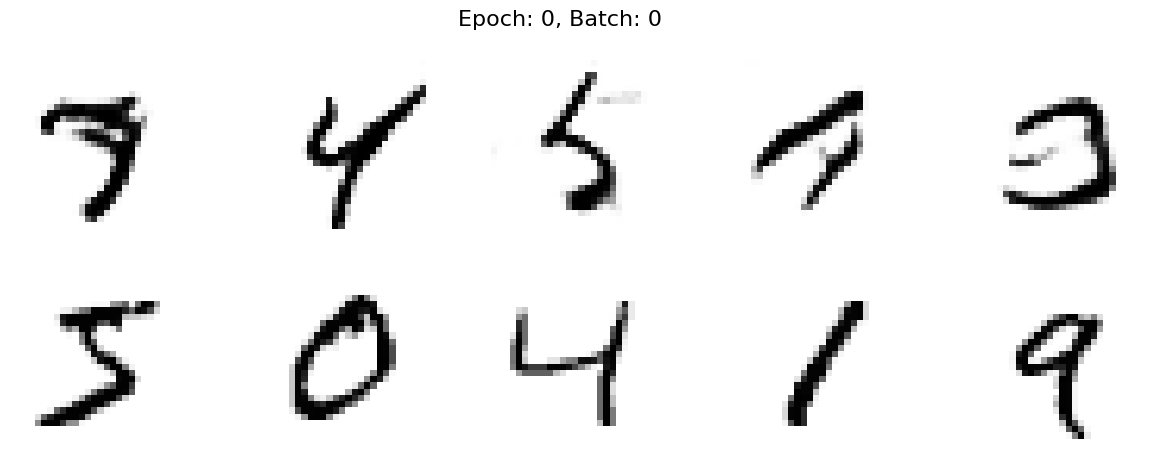

50 [D loss: 0.5977,	 acc.: 62.50%]	[G loss: 1.2229]
100 [D loss: 0.6373,	 acc.: 59.38%]	[G loss: 1.0835]
150 [D loss: 0.6549,	 acc.: 65.62%]	[G loss: 0.9310]
200 [D loss: 0.5606,	 acc.: 70.31%]	[G loss: 1.0325]
250 [D loss: 0.6314,	 acc.: 65.62%]	[G loss: 1.0294]
300 [D loss: 0.5167,	 acc.: 73.44%]	[G loss: 1.2114]
350 [D loss: 0.5888,	 acc.: 70.31%]	[G loss: 1.0286]
400 [D loss: 0.5111,	 acc.: 78.12%]	[G loss: 0.9314]
450 [D loss: 0.6129,	 acc.: 67.19%]	[G loss: 1.0214]
500 [D loss: 0.8159,	 acc.: 46.88%]	[G loss: 0.9695]


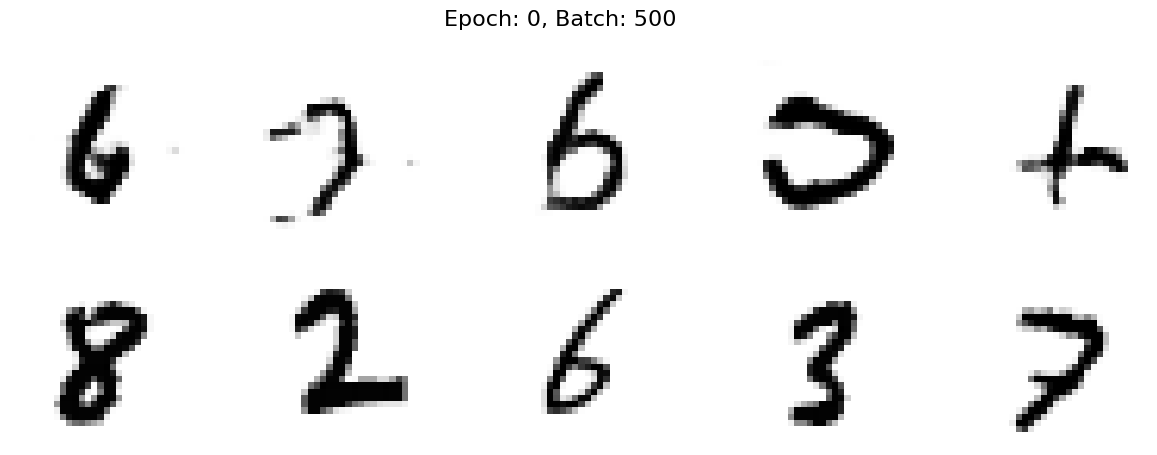

550 [D loss: 0.5914,	 acc.: 65.62%]	[G loss: 0.8965]
600 [D loss: 0.7278,	 acc.: 51.56%]	[G loss: 0.9101]
650 [D loss: 0.4959,	 acc.: 76.56%]	[G loss: 1.1098]
700 [D loss: 0.5911,	 acc.: 65.62%]	[G loss: 1.1451]
750 [D loss: 0.5497,	 acc.: 70.31%]	[G loss: 1.0260]
800 [D loss: 0.5778,	 acc.: 64.06%]	[G loss: 0.9976]
850 [D loss: 0.6368,	 acc.: 59.38%]	[G loss: 0.9929]
900 [D loss: 0.6499,	 acc.: 54.69%]	[G loss: 0.9662]
950 [D loss: 0.6770,	 acc.: 53.12%]	[G loss: 0.8323]
1000 [D loss: 0.8064,	 acc.: 50.00%]	[G loss: 0.8149]


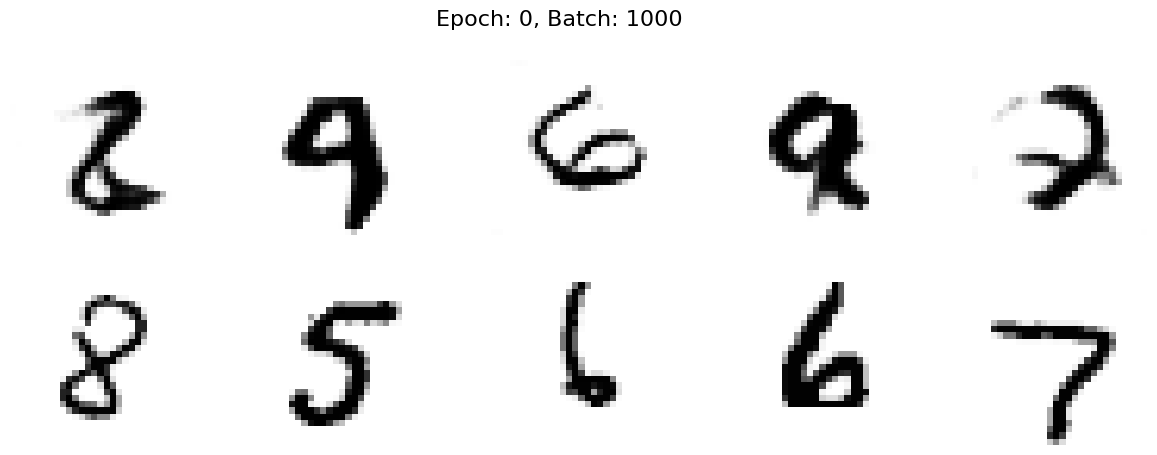

1050 [D loss: 0.5448,	 acc.: 71.88%]	[G loss: 1.0030]
1100 [D loss: 0.5577,	 acc.: 75.00%]	[G loss: 1.0838]
1150 [D loss: 0.6194,	 acc.: 65.62%]	[G loss: 1.0674]
1200 [D loss: 0.5596,	 acc.: 76.56%]	[G loss: 0.8937]
1250 [D loss: 0.6243,	 acc.: 60.94%]	[G loss: 0.9559]
1300 [D loss: 0.5990,	 acc.: 75.00%]	[G loss: 1.0699]
1350 [D loss: 0.5316,	 acc.: 70.31%]	[G loss: 0.9411]
1400 [D loss: 0.5418,	 acc.: 65.62%]	[G loss: 0.9535]
1450 [D loss: 0.6498,	 acc.: 56.25%]	[G loss: 0.9552]
1500 [D loss: 0.6947,	 acc.: 54.69%]	[G loss: 0.9253]


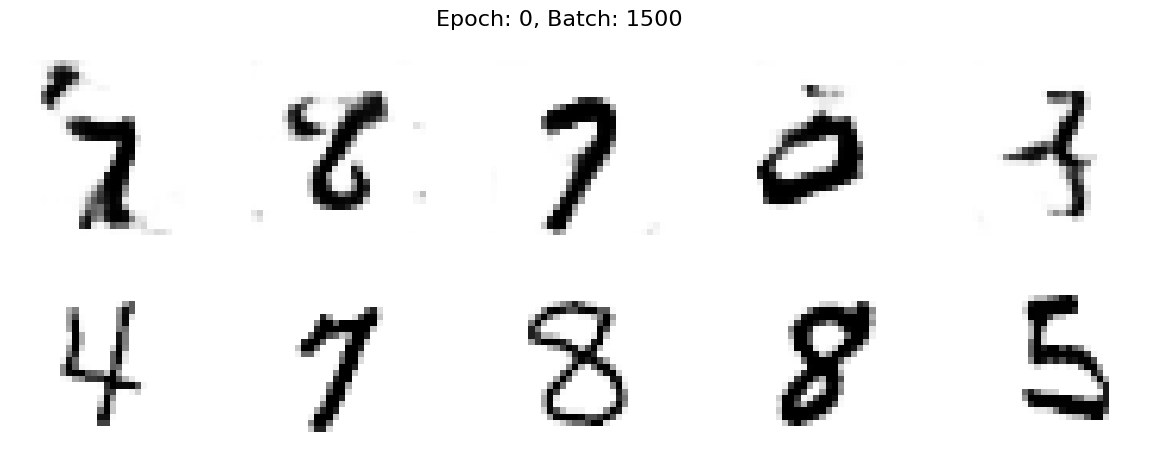

1550 [D loss: 0.5908,	 acc.: 68.75%]	[G loss: 0.9446]
1600 [D loss: 0.6159,	 acc.: 70.31%]	[G loss: 0.9272]
1650 [D loss: 0.5771,	 acc.: 65.62%]	[G loss: 0.9931]
1700 [D loss: 0.7712,	 acc.: 51.56%]	[G loss: 1.0722]
1750 [D loss: 0.6670,	 acc.: 64.06%]	[G loss: 0.8639]
1800 [D loss: 0.5937,	 acc.: 65.62%]	[G loss: 1.0273]
1850 [D loss: 0.6238,	 acc.: 56.25%]	[G loss: 1.1213]


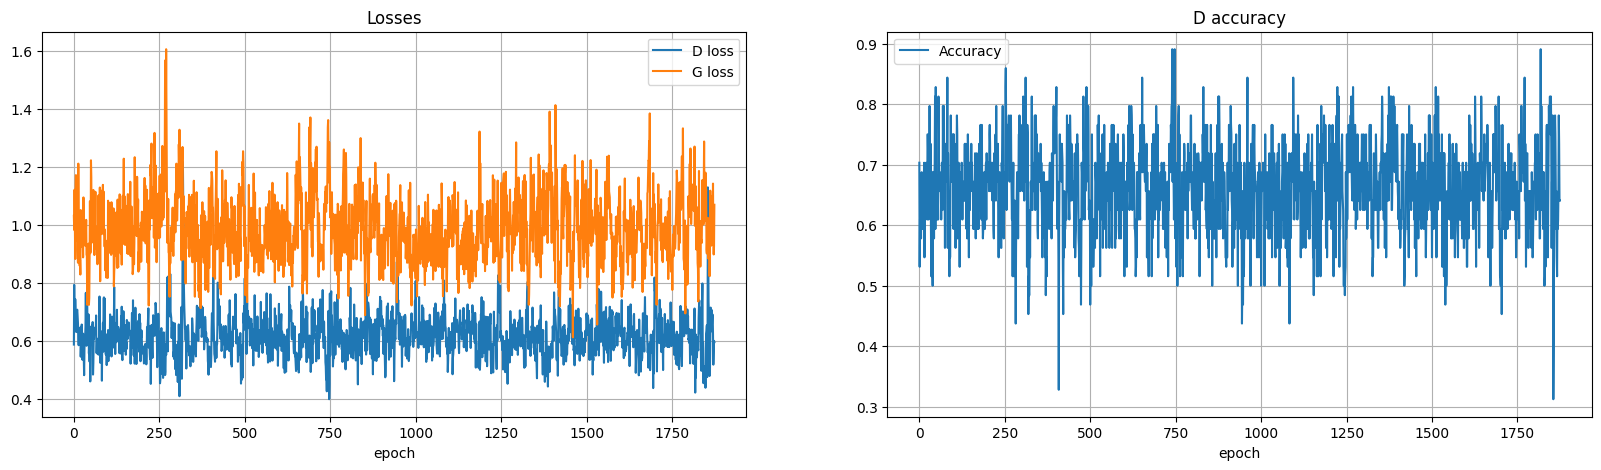

----EPOCH 1-----
0 [D loss: 0.6415,	 acc.: 67.19%]	[G loss: 1.0198]


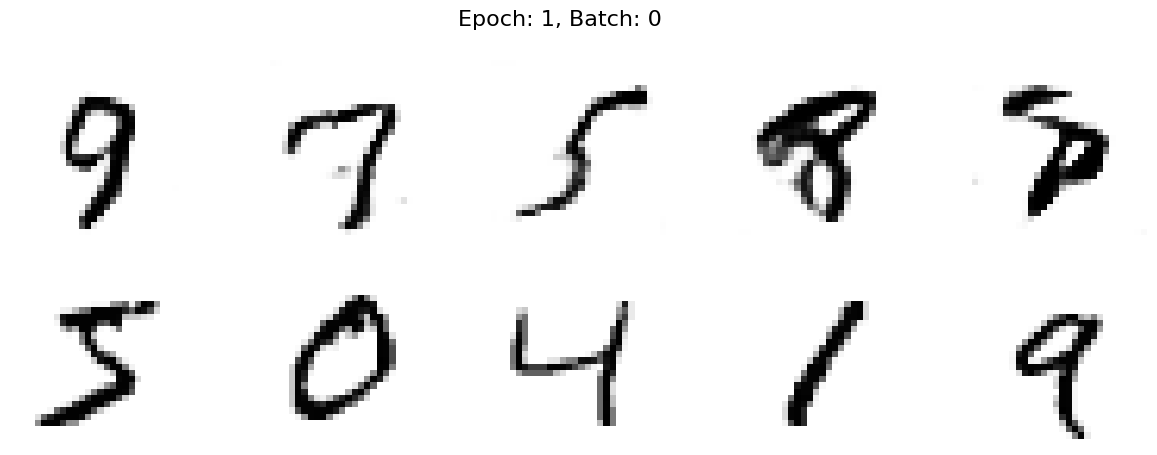

50 [D loss: 0.6918,	 acc.: 56.25%]	[G loss: 0.9714]
100 [D loss: 0.5808,	 acc.: 71.88%]	[G loss: 1.1375]
150 [D loss: 0.5677,	 acc.: 70.31%]	[G loss: 1.1235]
200 [D loss: 0.6173,	 acc.: 67.19%]	[G loss: 0.9642]
250 [D loss: 0.5484,	 acc.: 76.56%]	[G loss: 1.2648]
300 [D loss: 0.4846,	 acc.: 76.56%]	[G loss: 1.4515]
350 [D loss: 0.5745,	 acc.: 67.19%]	[G loss: 0.8637]
400 [D loss: 0.5159,	 acc.: 76.56%]	[G loss: 1.3142]
450 [D loss: 0.7018,	 acc.: 59.38%]	[G loss: 1.1003]
500 [D loss: 0.6738,	 acc.: 59.38%]	[G loss: 0.9062]


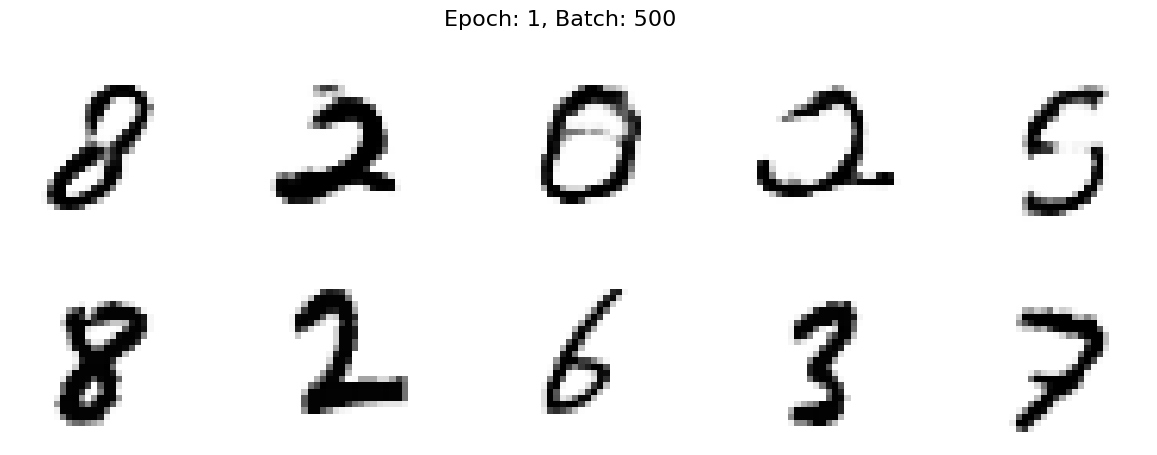

550 [D loss: 0.5278,	 acc.: 76.56%]	[G loss: 1.1423]
600 [D loss: 0.5814,	 acc.: 70.31%]	[G loss: 0.9862]
650 [D loss: 0.5943,	 acc.: 65.62%]	[G loss: 1.1650]
700 [D loss: 0.6342,	 acc.: 64.06%]	[G loss: 0.6952]
750 [D loss: 0.7647,	 acc.: 46.88%]	[G loss: 1.1554]
800 [D loss: 0.6504,	 acc.: 62.50%]	[G loss: 0.8875]
850 [D loss: 0.6250,	 acc.: 71.88%]	[G loss: 1.1463]
900 [D loss: 0.6111,	 acc.: 62.50%]	[G loss: 0.9803]
950 [D loss: 0.5657,	 acc.: 64.06%]	[G loss: 0.9769]
1000 [D loss: 0.7041,	 acc.: 59.38%]	[G loss: 1.0084]


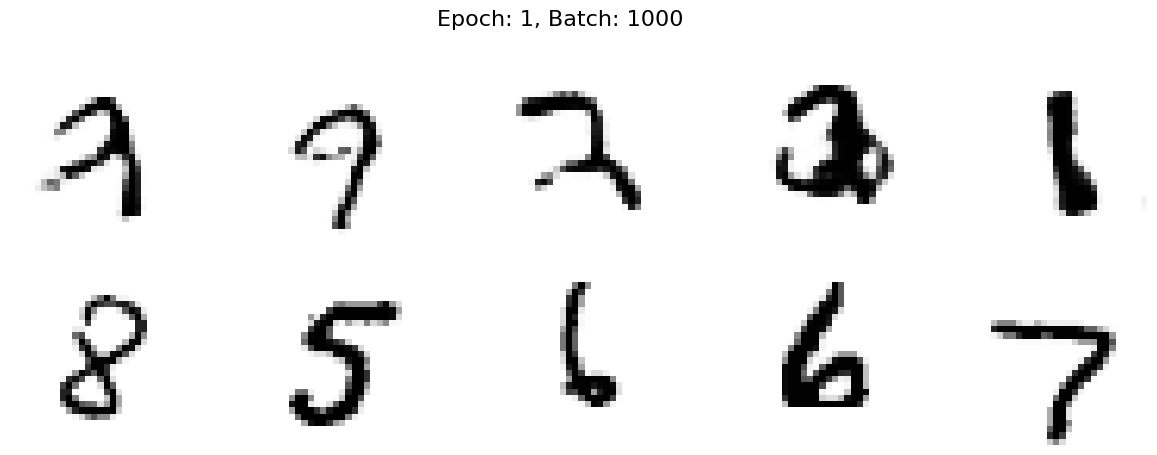

1050 [D loss: 0.5626,	 acc.: 75.00%]	[G loss: 0.9377]
1100 [D loss: 0.5971,	 acc.: 65.62%]	[G loss: 0.9279]
1150 [D loss: 0.5944,	 acc.: 73.44%]	[G loss: 0.8617]
1200 [D loss: 0.6080,	 acc.: 64.06%]	[G loss: 1.0319]
1250 [D loss: 0.5438,	 acc.: 73.44%]	[G loss: 1.2409]
1300 [D loss: 0.5905,	 acc.: 65.62%]	[G loss: 1.0699]
1350 [D loss: 0.5840,	 acc.: 67.19%]	[G loss: 0.9703]
1400 [D loss: 0.6398,	 acc.: 60.94%]	[G loss: 0.8213]
1450 [D loss: 0.6358,	 acc.: 57.81%]	[G loss: 0.9486]
1500 [D loss: 0.6186,	 acc.: 67.19%]	[G loss: 1.0599]


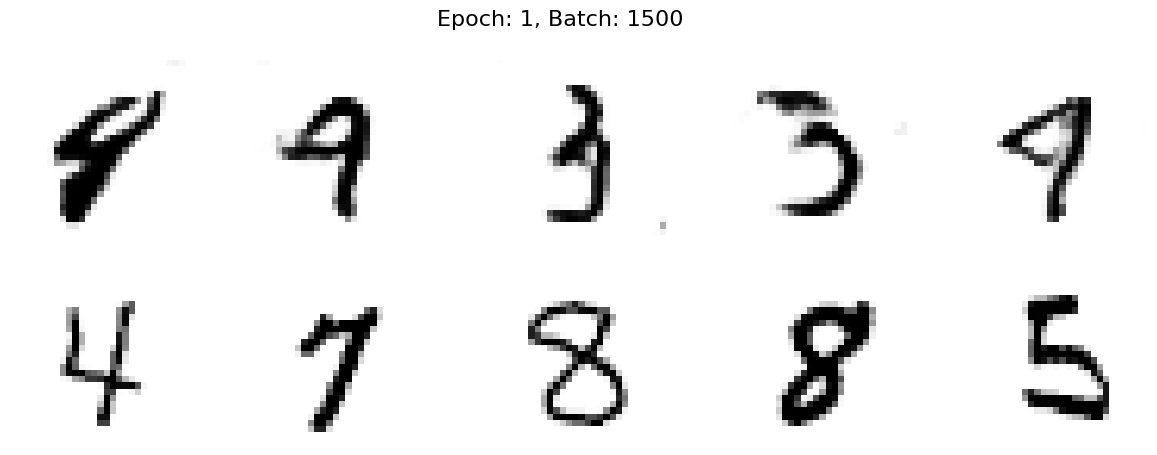

1550 [D loss: 0.5971,	 acc.: 70.31%]	[G loss: 0.8716]
1600 [D loss: 0.5916,	 acc.: 78.12%]	[G loss: 1.0505]
1650 [D loss: 0.6950,	 acc.: 60.94%]	[G loss: 0.9003]
1700 [D loss: 0.6229,	 acc.: 65.62%]	[G loss: 0.9761]
1750 [D loss: 0.5764,	 acc.: 64.06%]	[G loss: 0.9589]
1800 [D loss: 0.5792,	 acc.: 65.62%]	[G loss: 0.9688]
1850 [D loss: 0.4794,	 acc.: 76.56%]	[G loss: 0.9381]


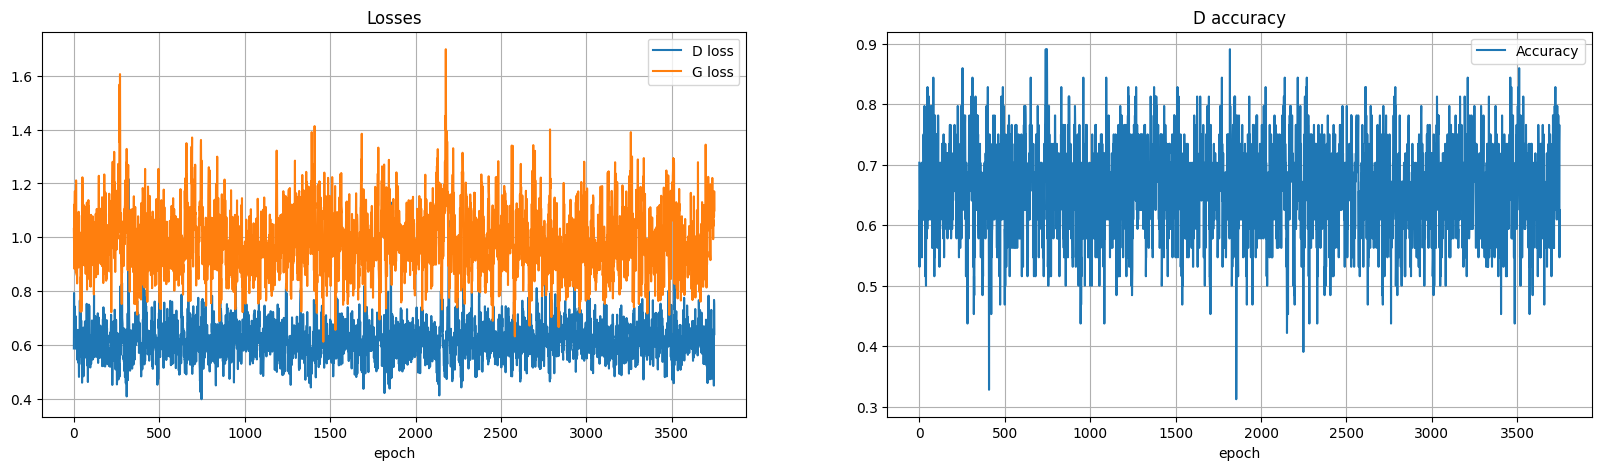

----EPOCH 2-----
0 [D loss: 0.8294,	 acc.: 48.44%]	[G loss: 0.9626]


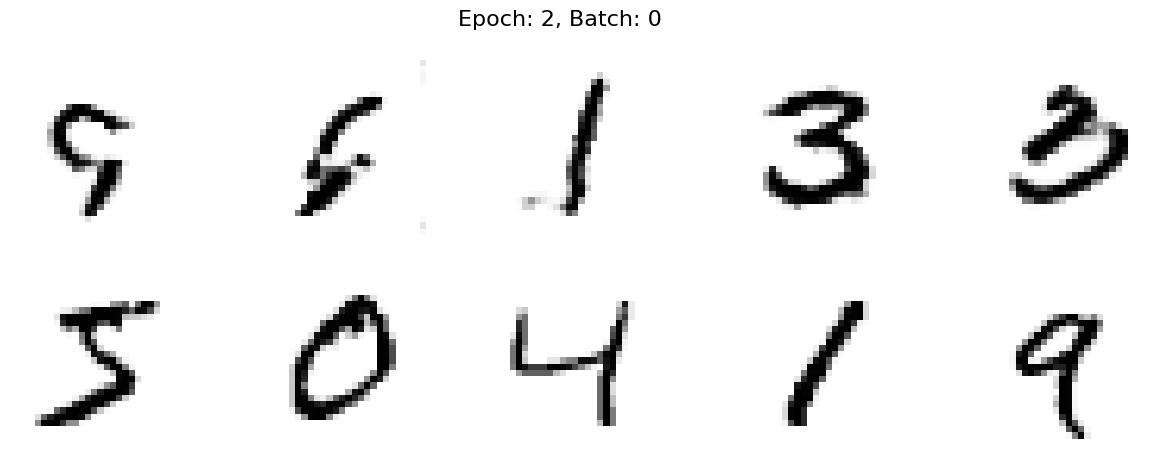

50 [D loss: 0.6332,	 acc.: 64.06%]	[G loss: 0.9281]
100 [D loss: 0.5850,	 acc.: 71.88%]	[G loss: 1.0094]
150 [D loss: 0.5805,	 acc.: 67.19%]	[G loss: 1.1055]
200 [D loss: 0.5847,	 acc.: 75.00%]	[G loss: 0.9715]
250 [D loss: 0.6151,	 acc.: 68.75%]	[G loss: 1.1171]
300 [D loss: 0.5035,	 acc.: 78.12%]	[G loss: 0.9691]
350 [D loss: 0.7736,	 acc.: 57.81%]	[G loss: 0.7920]
400 [D loss: 0.6699,	 acc.: 62.50%]	[G loss: 0.9224]
450 [D loss: 0.6443,	 acc.: 56.25%]	[G loss: 1.0811]
500 [D loss: 0.5744,	 acc.: 68.75%]	[G loss: 0.9031]


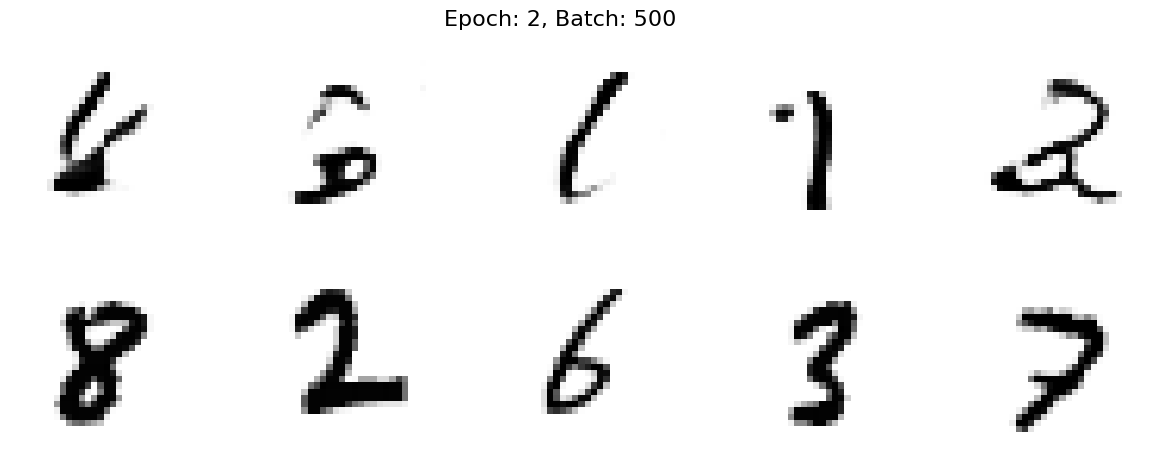

550 [D loss: 0.5400,	 acc.: 71.88%]	[G loss: 1.1827]
600 [D loss: 0.6100,	 acc.: 68.75%]	[G loss: 0.7734]
650 [D loss: 0.5837,	 acc.: 68.75%]	[G loss: 0.9592]
700 [D loss: 0.6141,	 acc.: 65.62%]	[G loss: 0.9498]
750 [D loss: 0.6054,	 acc.: 68.75%]	[G loss: 1.1281]
800 [D loss: 0.6056,	 acc.: 60.94%]	[G loss: 0.9894]
850 [D loss: 0.5875,	 acc.: 67.19%]	[G loss: 1.0549]
900 [D loss: 0.6405,	 acc.: 62.50%]	[G loss: 1.1748]
950 [D loss: 0.7075,	 acc.: 67.19%]	[G loss: 0.8465]
1000 [D loss: 0.6228,	 acc.: 65.62%]	[G loss: 0.8621]


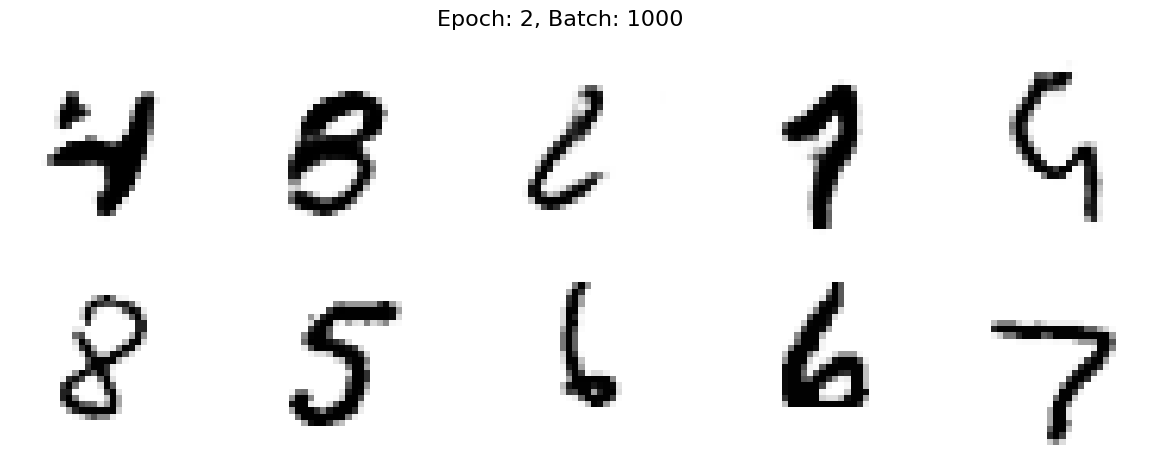

1050 [D loss: 0.5603,	 acc.: 75.00%]	[G loss: 1.1043]
1100 [D loss: 0.5890,	 acc.: 70.31%]	[G loss: 1.0375]
1150 [D loss: 0.6449,	 acc.: 59.38%]	[G loss: 0.8768]
1200 [D loss: 0.5831,	 acc.: 65.62%]	[G loss: 0.8882]
1250 [D loss: 0.6196,	 acc.: 64.06%]	[G loss: 0.9174]
1300 [D loss: 0.5558,	 acc.: 68.75%]	[G loss: 0.9651]
1350 [D loss: 0.6503,	 acc.: 57.81%]	[G loss: 0.8227]
1400 [D loss: 0.6115,	 acc.: 71.88%]	[G loss: 0.9009]
1450 [D loss: 0.5972,	 acc.: 67.19%]	[G loss: 0.9675]
1500 [D loss: 0.5233,	 acc.: 73.44%]	[G loss: 0.9962]


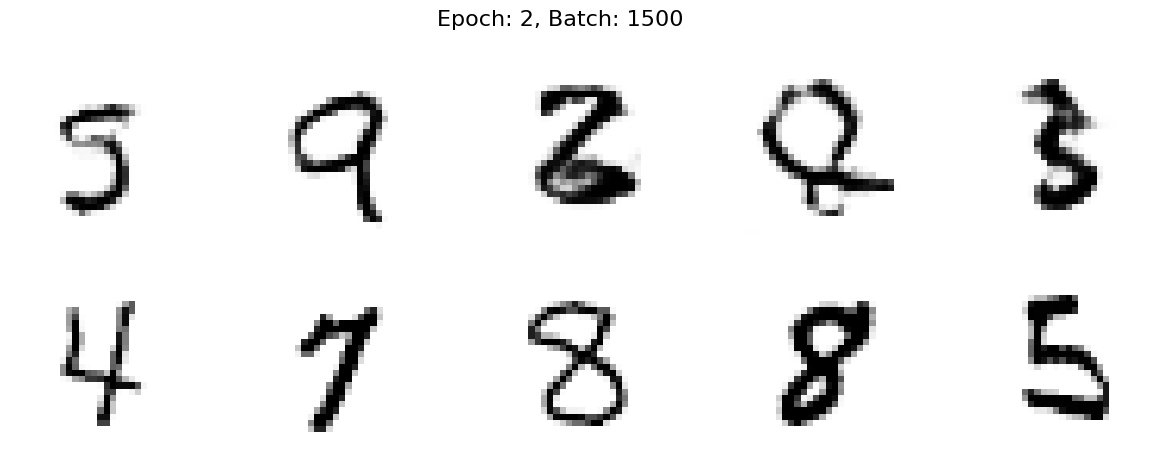

1550 [D loss: 0.6299,	 acc.: 60.94%]	[G loss: 1.1282]
1600 [D loss: 0.6201,	 acc.: 64.06%]	[G loss: 0.8604]
1650 [D loss: 0.5704,	 acc.: 70.31%]	[G loss: 1.1896]
1700 [D loss: 0.6674,	 acc.: 65.62%]	[G loss: 0.9507]
1750 [D loss: 0.5600,	 acc.: 76.56%]	[G loss: 1.1508]
1800 [D loss: 0.5565,	 acc.: 73.44%]	[G loss: 0.9693]
1850 [D loss: 0.5620,	 acc.: 73.44%]	[G loss: 1.1519]


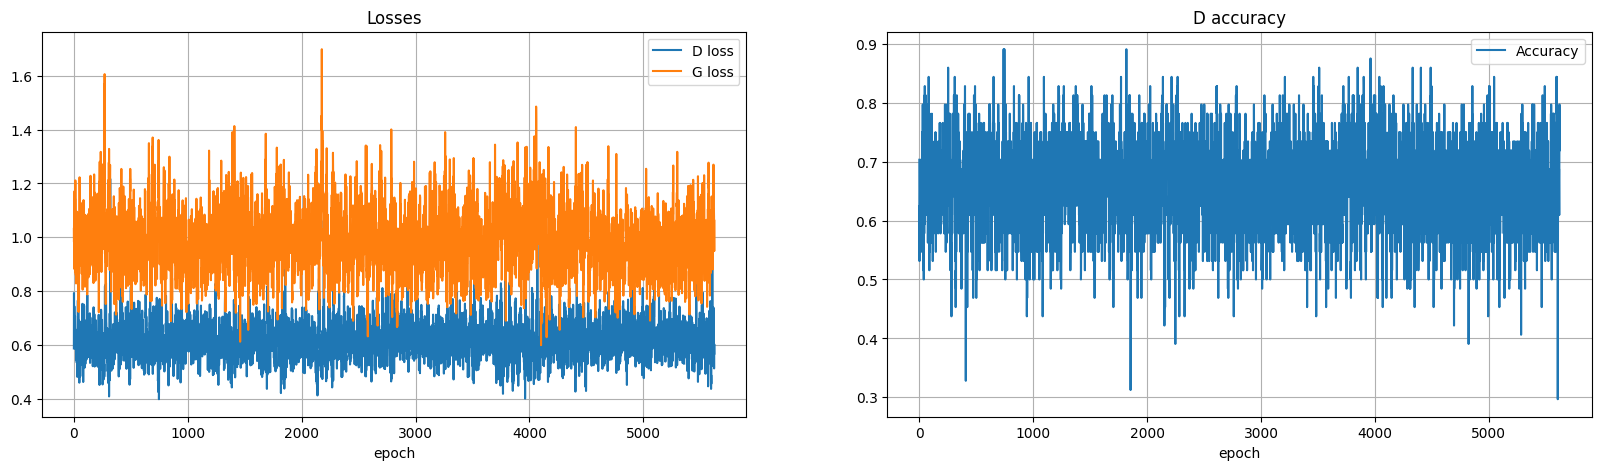

----EPOCH 3-----
0 [D loss: 0.6539,	 acc.: 59.38%]	[G loss: 0.9272]


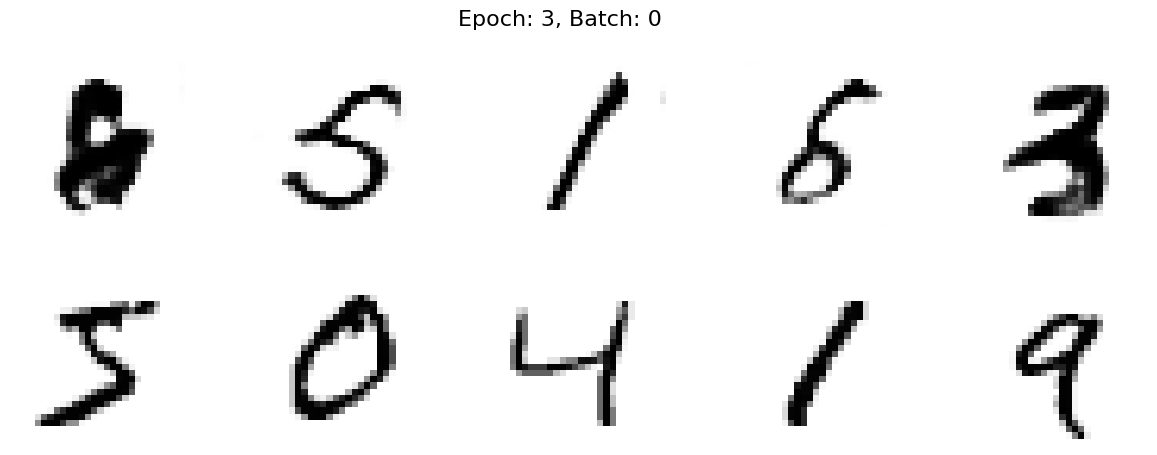

50 [D loss: 0.6351,	 acc.: 64.06%]	[G loss: 0.9967]
100 [D loss: 0.6078,	 acc.: 73.44%]	[G loss: 0.8256]
150 [D loss: 0.6182,	 acc.: 73.44%]	[G loss: 0.8222]
200 [D loss: 0.6930,	 acc.: 62.50%]	[G loss: 0.8017]
250 [D loss: 0.5327,	 acc.: 76.56%]	[G loss: 1.0699]
300 [D loss: 0.4529,	 acc.: 78.12%]	[G loss: 1.0134]
350 [D loss: 0.6337,	 acc.: 60.94%]	[G loss: 0.7921]
400 [D loss: 0.5826,	 acc.: 67.19%]	[G loss: 0.9964]
450 [D loss: 0.6699,	 acc.: 62.50%]	[G loss: 0.8877]
500 [D loss: 0.6839,	 acc.: 59.38%]	[G loss: 0.9954]


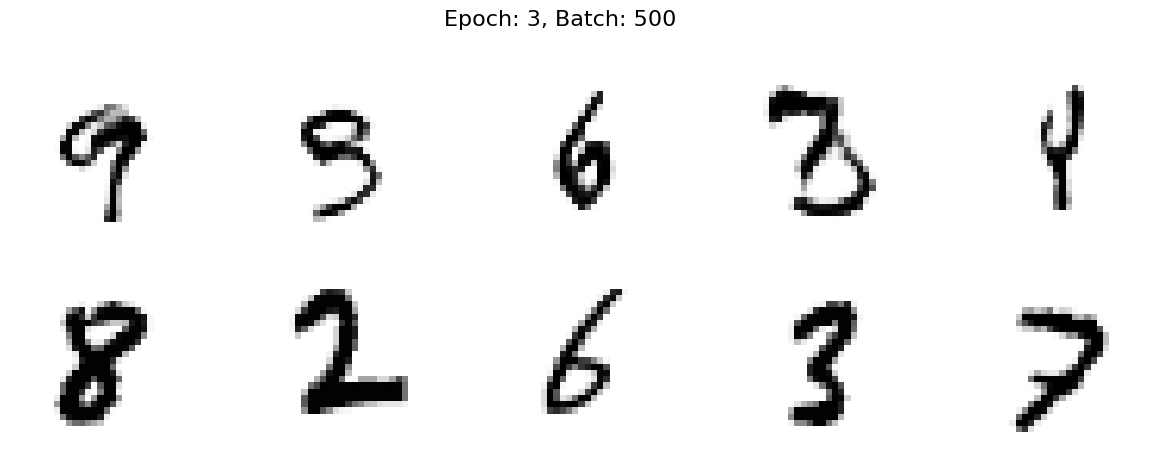

550 [D loss: 0.5305,	 acc.: 71.88%]	[G loss: 1.0148]
600 [D loss: 0.5186,	 acc.: 78.12%]	[G loss: 0.9377]
650 [D loss: 0.6150,	 acc.: 67.19%]	[G loss: 0.8957]
700 [D loss: 0.6314,	 acc.: 70.31%]	[G loss: 0.9547]
750 [D loss: 0.7268,	 acc.: 53.12%]	[G loss: 1.1595]
800 [D loss: 0.5915,	 acc.: 73.44%]	[G loss: 0.9694]
850 [D loss: 0.6175,	 acc.: 64.06%]	[G loss: 1.0303]
900 [D loss: 0.5621,	 acc.: 75.00%]	[G loss: 1.1168]
950 [D loss: 0.5776,	 acc.: 68.75%]	[G loss: 1.0693]
1000 [D loss: 0.6914,	 acc.: 57.81%]	[G loss: 0.8651]


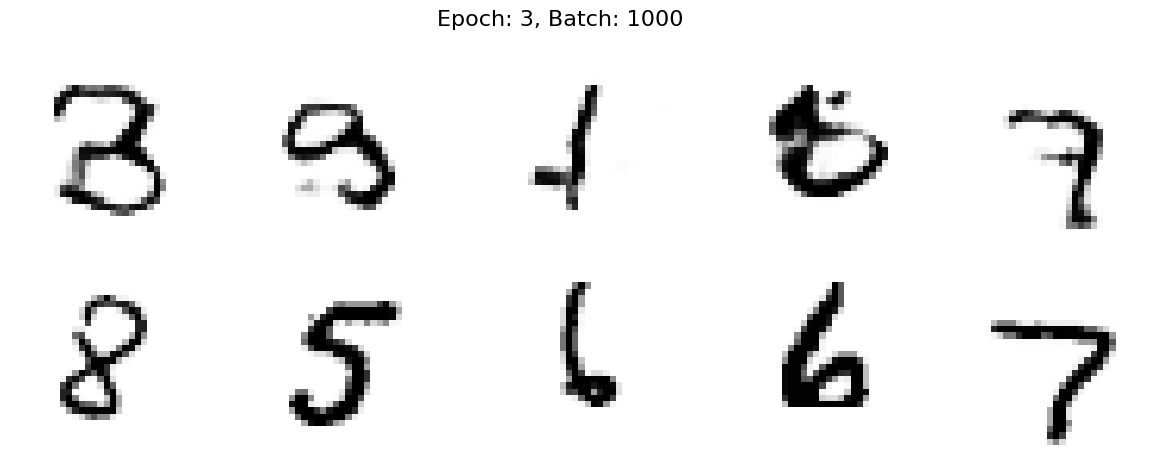

1050 [D loss: 0.6575,	 acc.: 65.62%]	[G loss: 1.1248]
1100 [D loss: 0.6126,	 acc.: 73.44%]	[G loss: 0.8165]
1150 [D loss: 0.6780,	 acc.: 57.81%]	[G loss: 0.9382]
1200 [D loss: 0.6705,	 acc.: 60.94%]	[G loss: 0.8010]
1250 [D loss: 0.6064,	 acc.: 65.62%]	[G loss: 1.0263]
1300 [D loss: 0.5926,	 acc.: 76.56%]	[G loss: 1.1990]
1350 [D loss: 0.5527,	 acc.: 70.31%]	[G loss: 1.0821]
1400 [D loss: 0.5074,	 acc.: 78.12%]	[G loss: 0.9524]
1450 [D loss: 0.5503,	 acc.: 70.31%]	[G loss: 0.9898]
1500 [D loss: 0.5874,	 acc.: 62.50%]	[G loss: 0.8465]


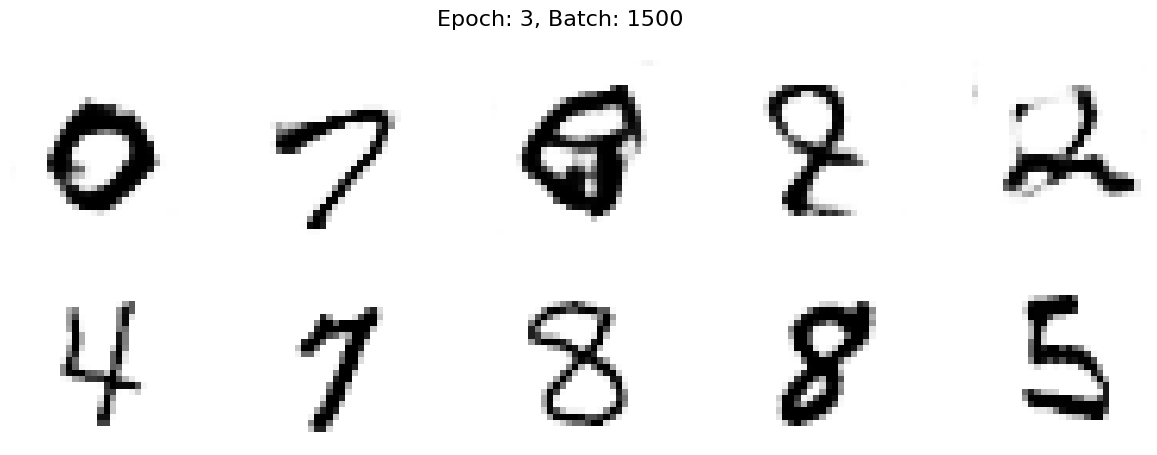

1550 [D loss: 0.6814,	 acc.: 59.38%]	[G loss: 1.2852]
1600 [D loss: 0.5811,	 acc.: 68.75%]	[G loss: 1.1368]
1650 [D loss: 0.6947,	 acc.: 67.19%]	[G loss: 0.8836]
1700 [D loss: 0.7009,	 acc.: 60.94%]	[G loss: 0.9689]
1750 [D loss: 0.5344,	 acc.: 75.00%]	[G loss: 0.9596]
1800 [D loss: 0.6747,	 acc.: 64.06%]	[G loss: 0.8688]
1850 [D loss: 0.5605,	 acc.: 73.44%]	[G loss: 1.0898]


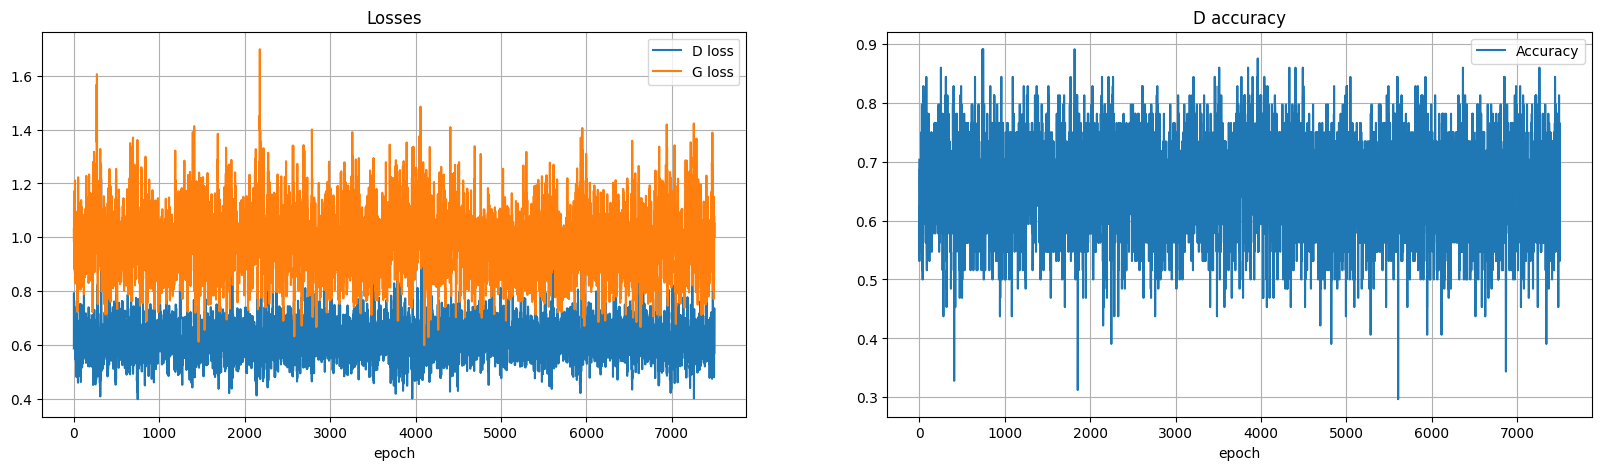

----EPOCH 4-----
0 [D loss: 0.6716,	 acc.: 59.38%]	[G loss: 0.9659]


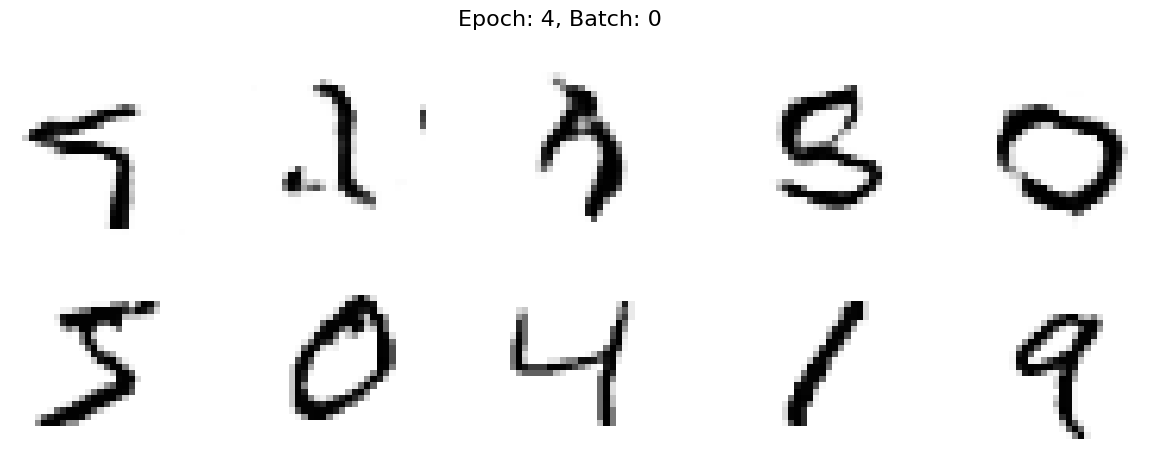

50 [D loss: 0.7027,	 acc.: 56.25%]	[G loss: 1.0036]
100 [D loss: 0.6585,	 acc.: 59.38%]	[G loss: 0.8966]
150 [D loss: 0.7641,	 acc.: 48.44%]	[G loss: 1.0046]
200 [D loss: 0.6456,	 acc.: 64.06%]	[G loss: 1.0620]
250 [D loss: 0.6582,	 acc.: 59.38%]	[G loss: 0.9458]
300 [D loss: 0.4883,	 acc.: 81.25%]	[G loss: 0.9947]
350 [D loss: 0.6667,	 acc.: 62.50%]	[G loss: 0.9274]
400 [D loss: 0.5987,	 acc.: 73.44%]	[G loss: 1.0945]
450 [D loss: 0.6262,	 acc.: 70.31%]	[G loss: 0.9262]
500 [D loss: 0.7473,	 acc.: 50.00%]	[G loss: 0.8690]


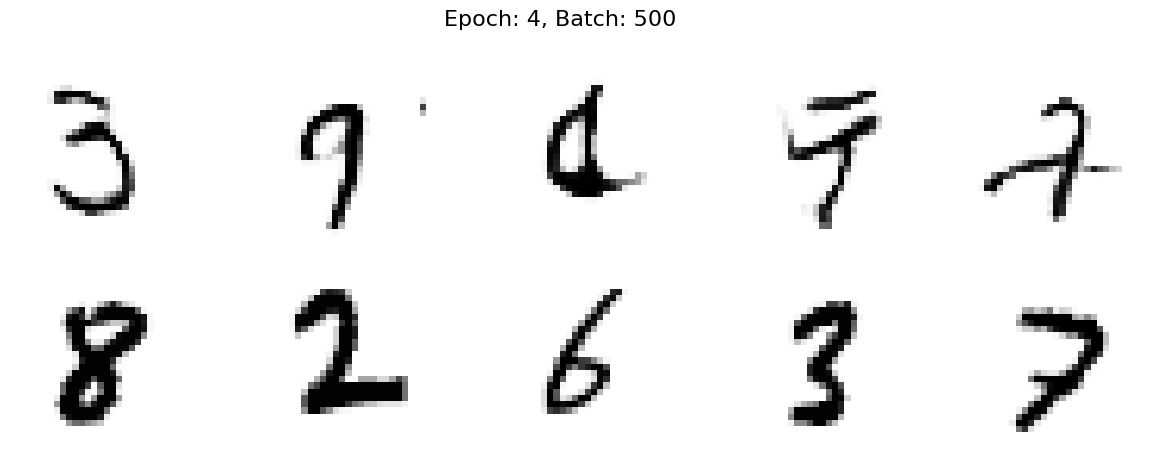

550 [D loss: 0.6076,	 acc.: 70.31%]	[G loss: 0.8542]
600 [D loss: 0.6547,	 acc.: 68.75%]	[G loss: 0.8648]
650 [D loss: 0.6243,	 acc.: 67.19%]	[G loss: 0.9189]
700 [D loss: 0.7354,	 acc.: 54.69%]	[G loss: 0.9697]
750 [D loss: 0.5998,	 acc.: 65.62%]	[G loss: 1.2516]
800 [D loss: 0.5738,	 acc.: 68.75%]	[G loss: 0.9828]
850 [D loss: 0.5948,	 acc.: 68.75%]	[G loss: 0.9211]
900 [D loss: 0.6618,	 acc.: 62.50%]	[G loss: 1.1756]
950 [D loss: 0.8082,	 acc.: 53.12%]	[G loss: 0.8923]
1000 [D loss: 0.6222,	 acc.: 68.75%]	[G loss: 0.9224]


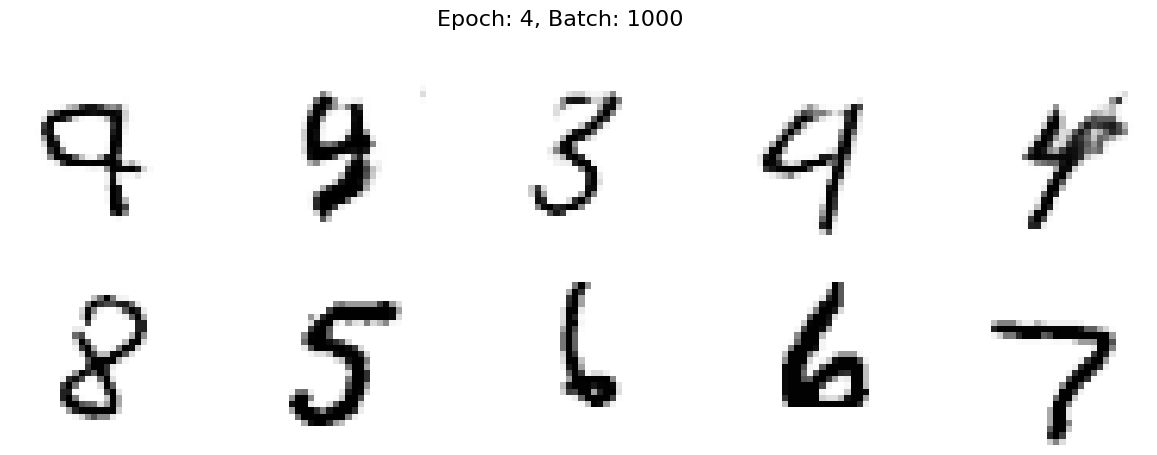

1050 [D loss: 0.4860,	 acc.: 79.69%]	[G loss: 1.0617]
1100 [D loss: 0.5836,	 acc.: 68.75%]	[G loss: 0.8272]
1150 [D loss: 0.6449,	 acc.: 60.94%]	[G loss: 0.8407]
1200 [D loss: 0.6283,	 acc.: 70.31%]	[G loss: 0.8595]
1250 [D loss: 0.6759,	 acc.: 56.25%]	[G loss: 1.0613]
1300 [D loss: 0.6638,	 acc.: 59.38%]	[G loss: 1.0065]
1350 [D loss: 0.5895,	 acc.: 70.31%]	[G loss: 0.8254]
1400 [D loss: 0.7326,	 acc.: 51.56%]	[G loss: 0.8786]
1450 [D loss: 0.6939,	 acc.: 62.50%]	[G loss: 0.9544]
1500 [D loss: 0.5931,	 acc.: 71.88%]	[G loss: 0.9118]


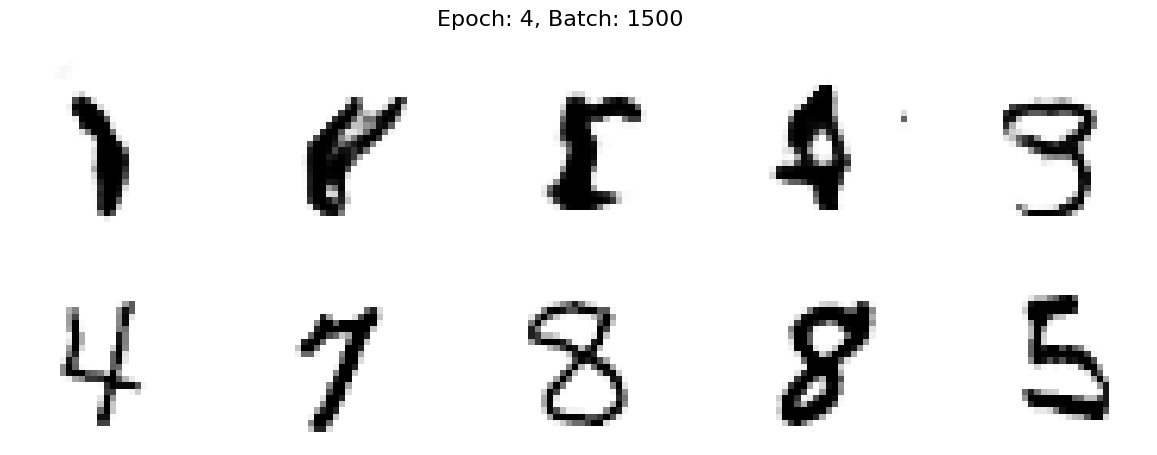

1550 [D loss: 0.6131,	 acc.: 65.62%]	[G loss: 1.0242]
1600 [D loss: 0.6202,	 acc.: 60.94%]	[G loss: 1.0259]
1650 [D loss: 0.6775,	 acc.: 62.50%]	[G loss: 0.9418]
1700 [D loss: 0.6723,	 acc.: 54.69%]	[G loss: 0.9140]
1750 [D loss: 0.5715,	 acc.: 75.00%]	[G loss: 0.8384]
1800 [D loss: 0.6215,	 acc.: 60.94%]	[G loss: 0.7994]
1850 [D loss: 0.6430,	 acc.: 59.38%]	[G loss: 0.9646]


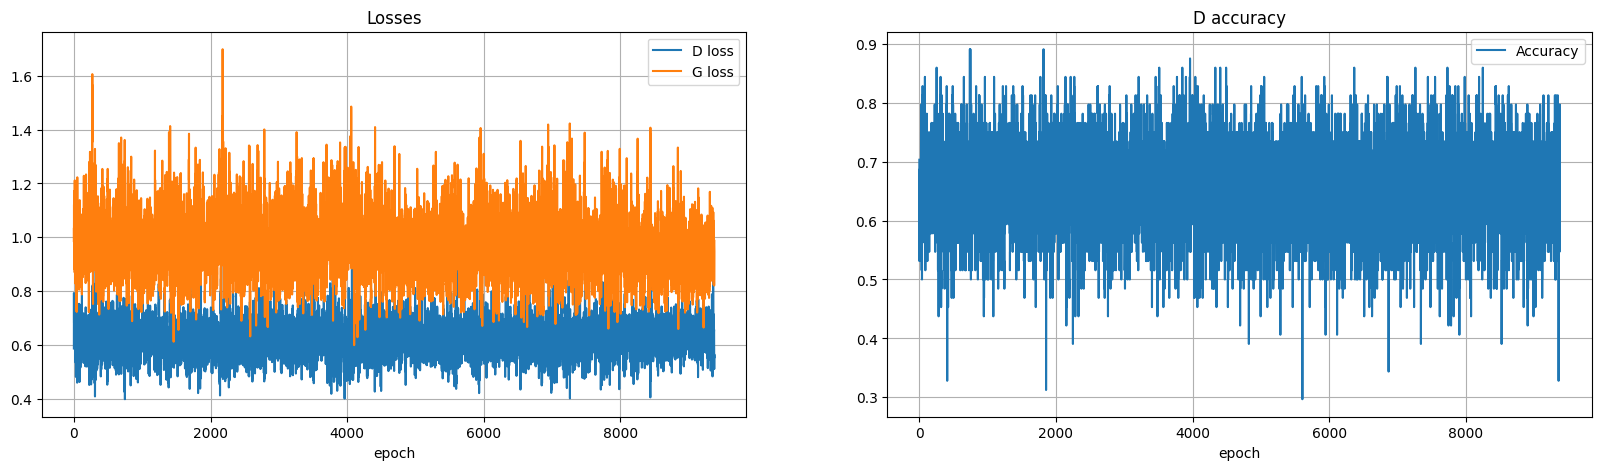

----EPOCH 5-----
0 [D loss: 0.5838,	 acc.: 62.50%]	[G loss: 0.8697]


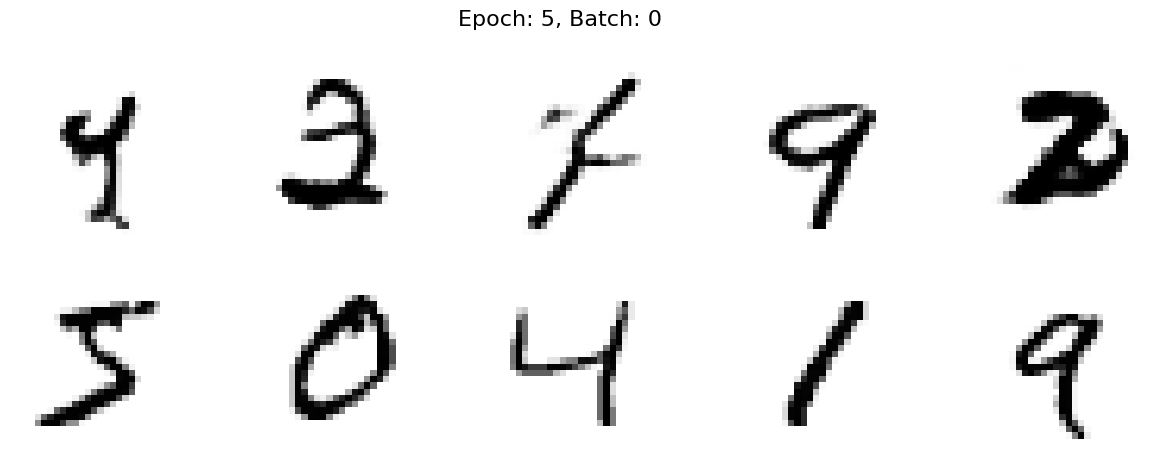

50 [D loss: 0.6298,	 acc.: 64.06%]	[G loss: 0.9866]
100 [D loss: 0.5378,	 acc.: 75.00%]	[G loss: 1.0650]
150 [D loss: 0.6810,	 acc.: 59.38%]	[G loss: 1.0552]
200 [D loss: 0.5608,	 acc.: 75.00%]	[G loss: 0.9169]
250 [D loss: 0.5768,	 acc.: 75.00%]	[G loss: 0.9229]
300 [D loss: 0.6028,	 acc.: 70.31%]	[G loss: 0.8948]
350 [D loss: 0.7686,	 acc.: 50.00%]	[G loss: 0.9776]
400 [D loss: 0.6839,	 acc.: 64.06%]	[G loss: 0.9756]
450 [D loss: 0.7125,	 acc.: 59.38%]	[G loss: 0.9502]
500 [D loss: 0.6786,	 acc.: 60.94%]	[G loss: 0.9552]


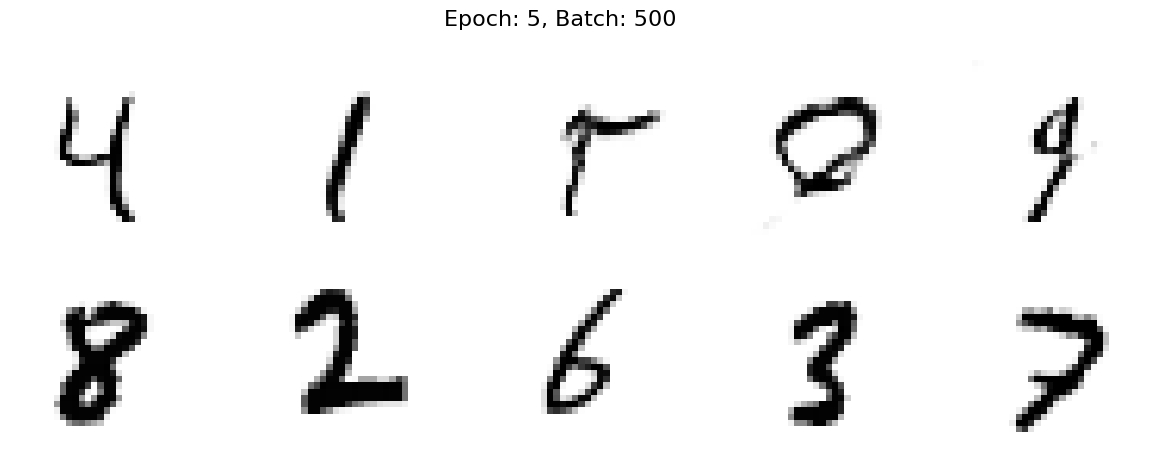

550 [D loss: 0.5971,	 acc.: 64.06%]	[G loss: 1.0943]
600 [D loss: 0.6396,	 acc.: 59.38%]	[G loss: 0.8352]
650 [D loss: 0.6796,	 acc.: 57.81%]	[G loss: 0.7769]
700 [D loss: 0.6923,	 acc.: 62.50%]	[G loss: 0.8316]
750 [D loss: 0.7346,	 acc.: 57.81%]	[G loss: 0.8509]
800 [D loss: 0.6540,	 acc.: 62.50%]	[G loss: 0.9004]
850 [D loss: 0.5896,	 acc.: 70.31%]	[G loss: 0.8998]
900 [D loss: 0.5706,	 acc.: 79.69%]	[G loss: 0.9620]
950 [D loss: 0.6001,	 acc.: 68.75%]	[G loss: 1.0588]
1000 [D loss: 0.6100,	 acc.: 70.31%]	[G loss: 1.0686]


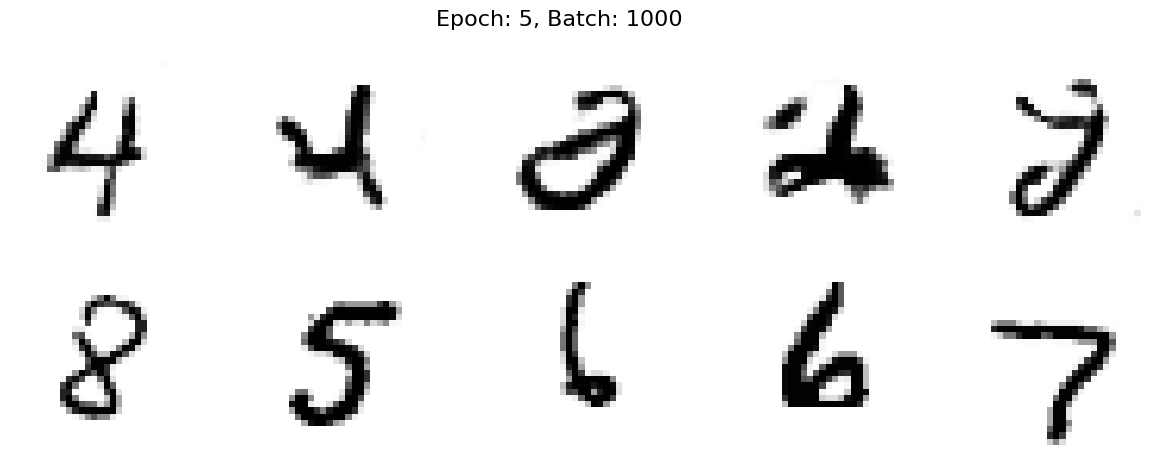

1050 [D loss: 0.5943,	 acc.: 68.75%]	[G loss: 1.0783]
1100 [D loss: 0.6179,	 acc.: 59.38%]	[G loss: 1.0075]
1150 [D loss: 0.5872,	 acc.: 68.75%]	[G loss: 1.0222]
1200 [D loss: 0.5574,	 acc.: 73.44%]	[G loss: 0.9962]
1250 [D loss: 0.6820,	 acc.: 59.38%]	[G loss: 0.7546]
1300 [D loss: 0.6076,	 acc.: 60.94%]	[G loss: 0.9156]
1350 [D loss: 0.6103,	 acc.: 75.00%]	[G loss: 0.9152]
1400 [D loss: 0.5140,	 acc.: 76.56%]	[G loss: 1.0270]
1450 [D loss: 0.5845,	 acc.: 62.50%]	[G loss: 1.0181]
1500 [D loss: 0.5957,	 acc.: 70.31%]	[G loss: 0.9523]


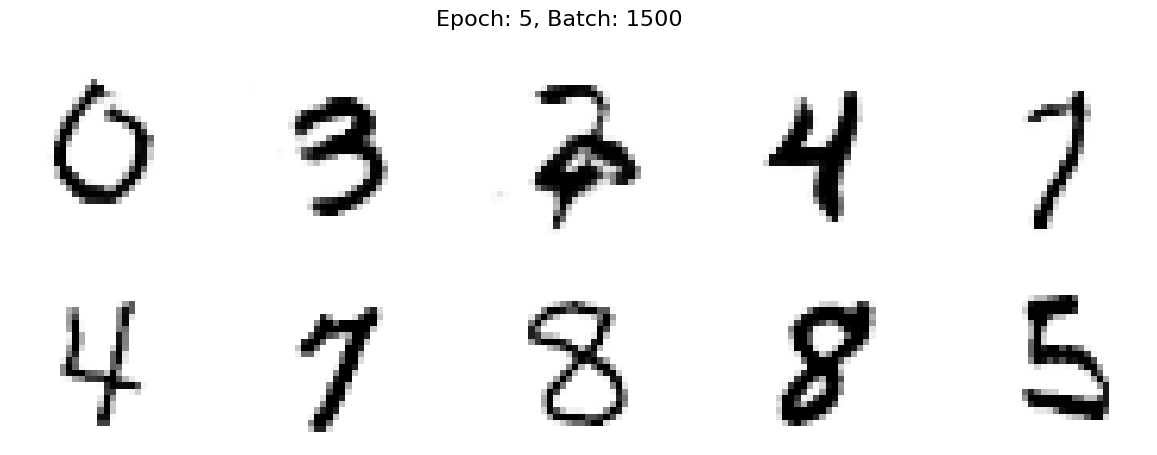

1550 [D loss: 0.6544,	 acc.: 60.94%]	[G loss: 1.1559]
1600 [D loss: 0.6239,	 acc.: 65.62%]	[G loss: 1.0641]
1650 [D loss: 0.6526,	 acc.: 65.62%]	[G loss: 0.8727]
1700 [D loss: 0.6881,	 acc.: 57.81%]	[G loss: 0.8278]
1750 [D loss: 0.5953,	 acc.: 70.31%]	[G loss: 1.0136]
1800 [D loss: 0.5300,	 acc.: 70.31%]	[G loss: 0.9857]
1850 [D loss: 0.5764,	 acc.: 76.56%]	[G loss: 1.1241]


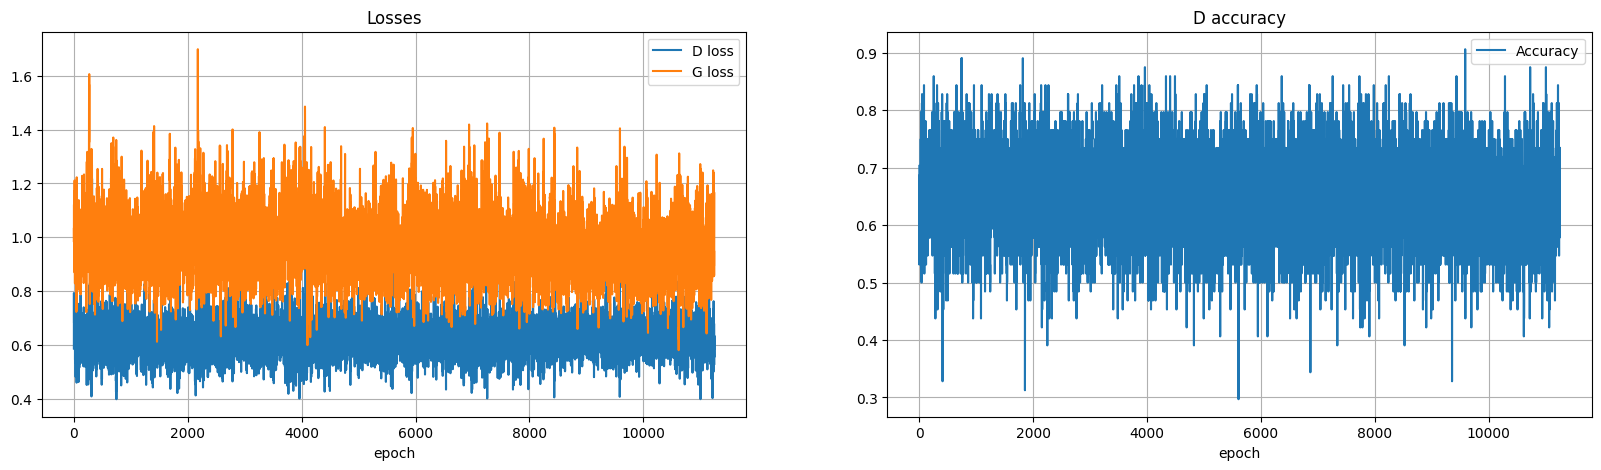

----EPOCH 6-----
0 [D loss: 0.7272,	 acc.: 62.50%]	[G loss: 1.1520]


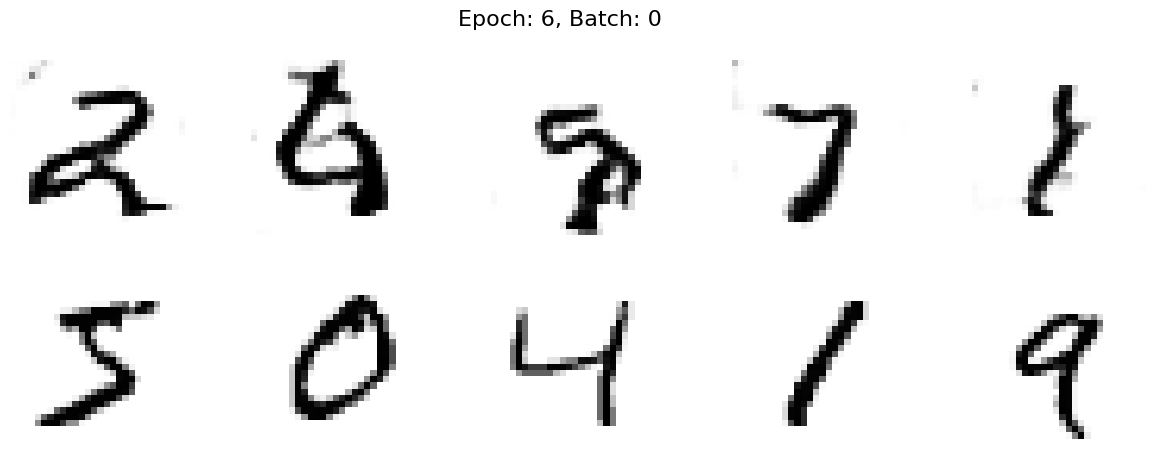

50 [D loss: 0.6673,	 acc.: 64.06%]	[G loss: 0.8903]
100 [D loss: 0.4866,	 acc.: 78.12%]	[G loss: 1.1348]
150 [D loss: 0.6857,	 acc.: 59.38%]	[G loss: 0.9708]
200 [D loss: 0.6260,	 acc.: 68.75%]	[G loss: 0.9247]
250 [D loss: 0.5843,	 acc.: 64.06%]	[G loss: 1.0557]
300 [D loss: 0.5497,	 acc.: 73.44%]	[G loss: 1.2170]
350 [D loss: 0.6087,	 acc.: 62.50%]	[G loss: 1.1223]
400 [D loss: 0.6566,	 acc.: 64.06%]	[G loss: 1.0795]
450 [D loss: 0.6412,	 acc.: 67.19%]	[G loss: 0.9778]
500 [D loss: 0.7072,	 acc.: 54.69%]	[G loss: 0.8396]


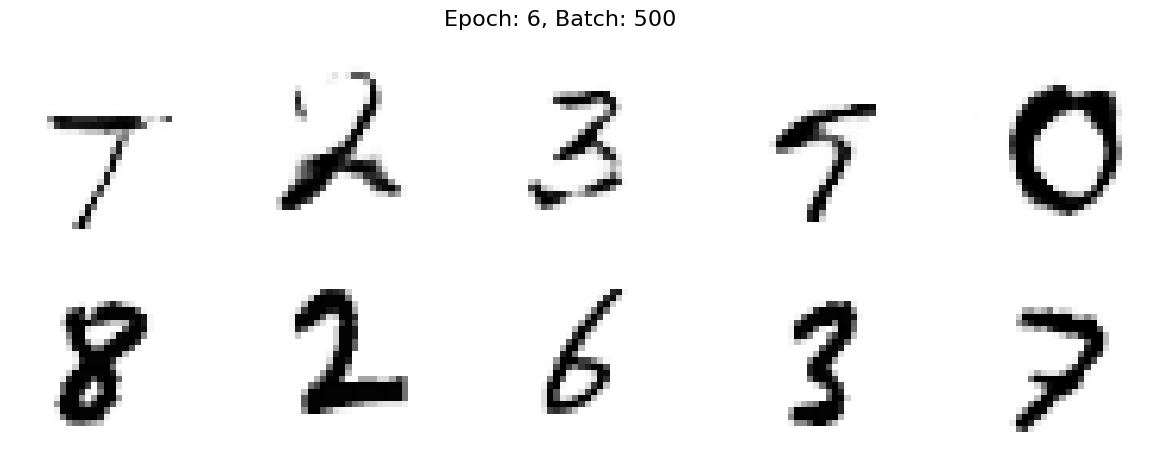

550 [D loss: 0.6710,	 acc.: 67.19%]	[G loss: 0.9050]
600 [D loss: 0.6280,	 acc.: 64.06%]	[G loss: 0.9169]
650 [D loss: 0.6054,	 acc.: 65.62%]	[G loss: 0.8756]
700 [D loss: 0.6246,	 acc.: 70.31%]	[G loss: 0.9256]
750 [D loss: 0.6933,	 acc.: 59.38%]	[G loss: 1.0736]
800 [D loss: 0.6132,	 acc.: 68.75%]	[G loss: 0.8771]
850 [D loss: 0.5883,	 acc.: 68.75%]	[G loss: 0.9845]
900 [D loss: 0.6003,	 acc.: 70.31%]	[G loss: 0.8392]
950 [D loss: 0.6679,	 acc.: 57.81%]	[G loss: 0.8460]
1000 [D loss: 0.6775,	 acc.: 62.50%]	[G loss: 0.8900]


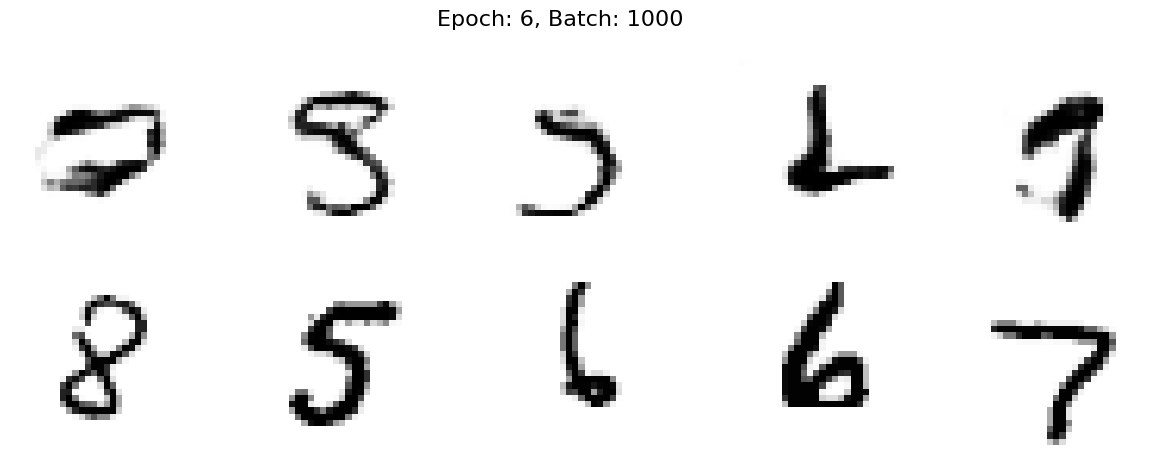

1050 [D loss: 0.6378,	 acc.: 65.62%]	[G loss: 0.9410]
1100 [D loss: 0.5828,	 acc.: 65.62%]	[G loss: 0.9557]
1150 [D loss: 0.6781,	 acc.: 56.25%]	[G loss: 1.0146]
1200 [D loss: 0.6497,	 acc.: 64.06%]	[G loss: 0.9289]
1250 [D loss: 0.6672,	 acc.: 54.69%]	[G loss: 0.8332]
1300 [D loss: 0.7583,	 acc.: 51.56%]	[G loss: 0.9334]
1350 [D loss: 0.6186,	 acc.: 68.75%]	[G loss: 0.7979]
1400 [D loss: 0.5918,	 acc.: 68.75%]	[G loss: 0.9621]
1450 [D loss: 0.5409,	 acc.: 73.44%]	[G loss: 1.3070]
1500 [D loss: 0.6249,	 acc.: 64.06%]	[G loss: 0.9686]


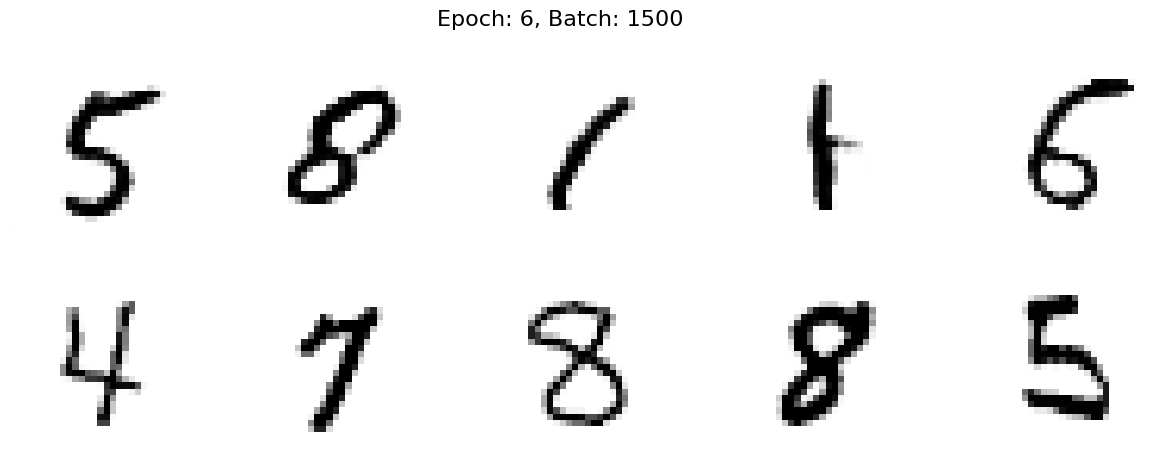

1550 [D loss: 0.6755,	 acc.: 57.81%]	[G loss: 0.9898]
1600 [D loss: 0.7098,	 acc.: 60.94%]	[G loss: 0.8652]
1650 [D loss: 0.7639,	 acc.: 56.25%]	[G loss: 0.9681]
1700 [D loss: 0.6590,	 acc.: 67.19%]	[G loss: 0.9861]
1750 [D loss: 0.6466,	 acc.: 67.19%]	[G loss: 0.9549]
1800 [D loss: 0.6127,	 acc.: 67.19%]	[G loss: 0.8765]
1850 [D loss: 0.6475,	 acc.: 64.06%]	[G loss: 1.0343]


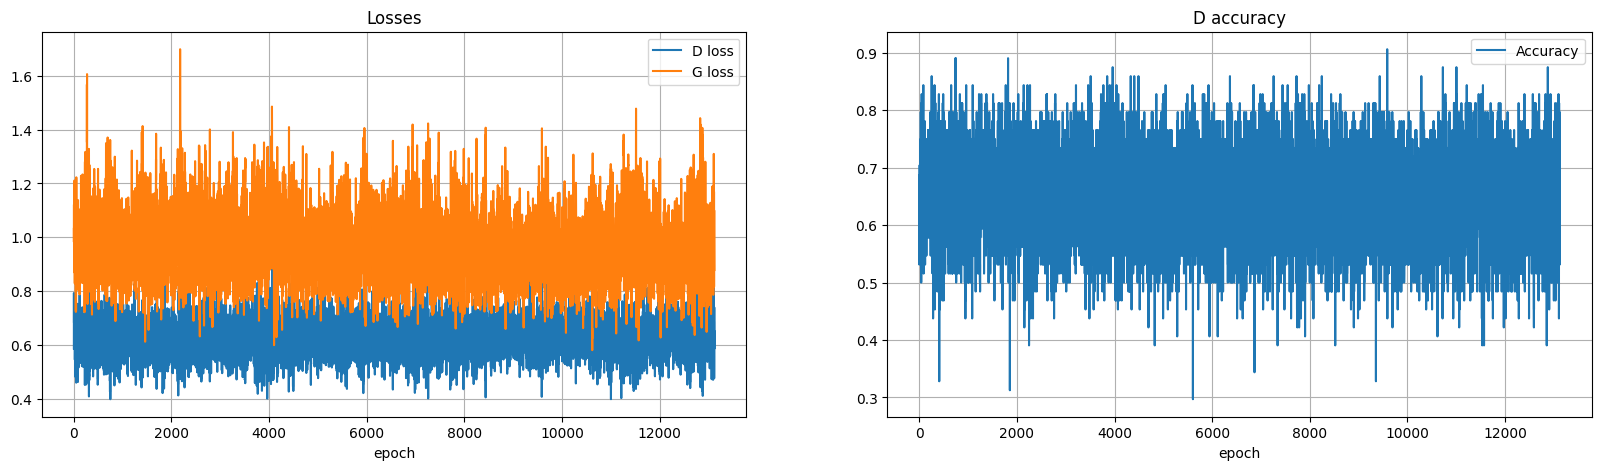

----EPOCH 7-----
0 [D loss: 0.6709,	 acc.: 62.50%]	[G loss: 0.9610]


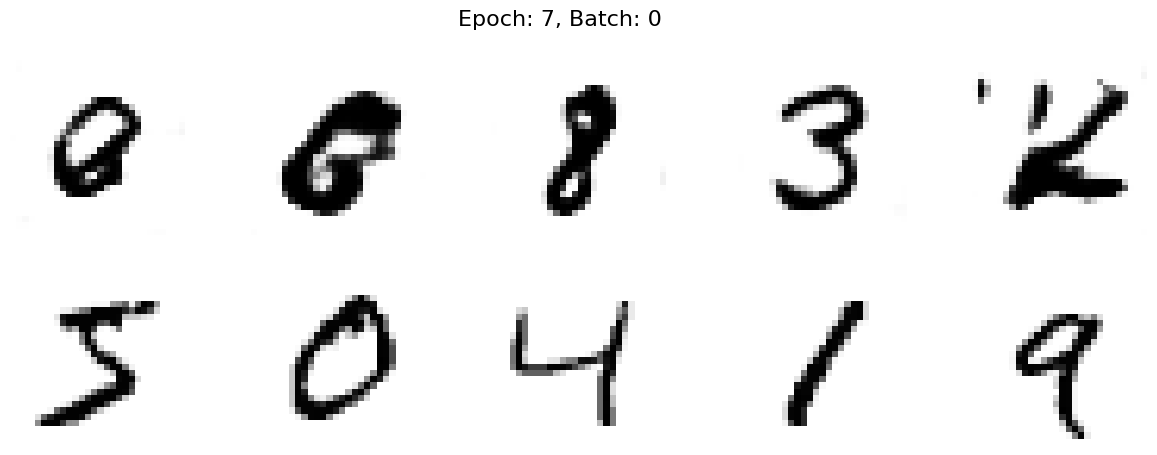

50 [D loss: 0.6237,	 acc.: 70.31%]	[G loss: 0.8622]
100 [D loss: 0.5965,	 acc.: 67.19%]	[G loss: 0.8396]
150 [D loss: 0.6868,	 acc.: 57.81%]	[G loss: 1.0434]
200 [D loss: 0.6120,	 acc.: 68.75%]	[G loss: 1.1303]
250 [D loss: 0.6197,	 acc.: 65.62%]	[G loss: 1.1515]
300 [D loss: 0.4656,	 acc.: 78.12%]	[G loss: 1.1568]
350 [D loss: 0.7580,	 acc.: 53.12%]	[G loss: 0.8604]
400 [D loss: 0.6833,	 acc.: 54.69%]	[G loss: 0.9898]
450 [D loss: 0.7586,	 acc.: 45.31%]	[G loss: 0.8277]
500 [D loss: 0.7330,	 acc.: 54.69%]	[G loss: 0.8036]


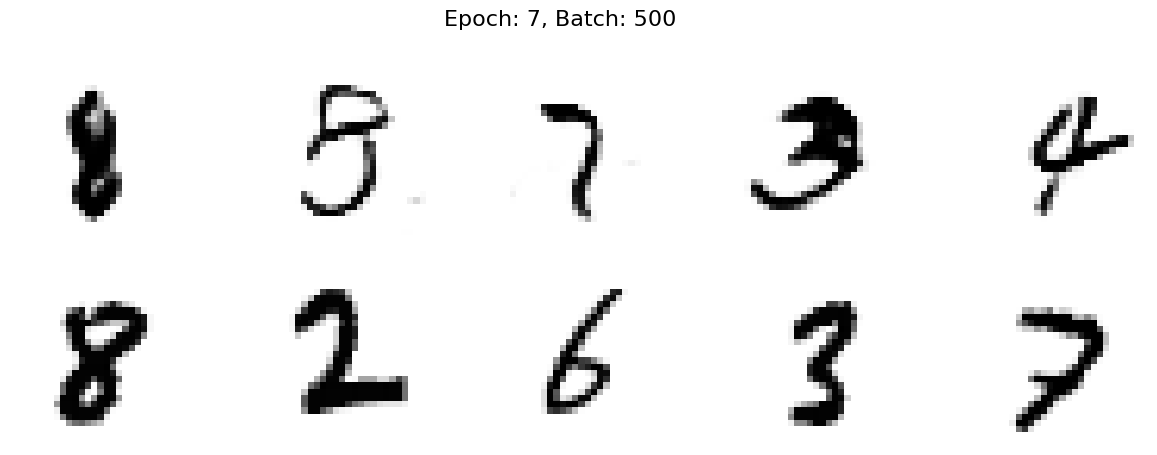

550 [D loss: 0.6124,	 acc.: 65.62%]	[G loss: 1.0421]
600 [D loss: 0.5420,	 acc.: 71.88%]	[G loss: 0.9656]
650 [D loss: 0.6490,	 acc.: 59.38%]	[G loss: 0.9492]
700 [D loss: 0.5981,	 acc.: 65.62%]	[G loss: 1.0938]
750 [D loss: 0.6715,	 acc.: 60.94%]	[G loss: 0.9201]
800 [D loss: 0.6150,	 acc.: 65.62%]	[G loss: 0.9142]
850 [D loss: 0.6491,	 acc.: 67.19%]	[G loss: 0.9200]
900 [D loss: 0.5783,	 acc.: 67.19%]	[G loss: 0.9985]
950 [D loss: 0.6037,	 acc.: 68.75%]	[G loss: 0.8520]
1000 [D loss: 0.6257,	 acc.: 60.94%]	[G loss: 0.8968]


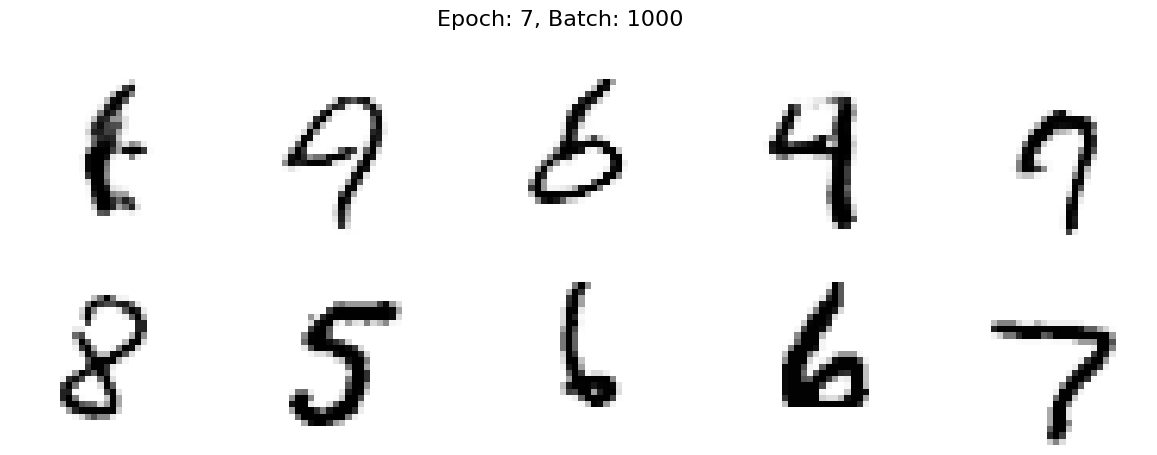

1050 [D loss: 0.5413,	 acc.: 70.31%]	[G loss: 1.0524]
1100 [D loss: 0.6068,	 acc.: 64.06%]	[G loss: 0.9380]
1150 [D loss: 0.7244,	 acc.: 57.81%]	[G loss: 0.9911]
1200 [D loss: 0.6192,	 acc.: 62.50%]	[G loss: 0.9569]
1250 [D loss: 0.5695,	 acc.: 71.88%]	[G loss: 0.8512]
1300 [D loss: 0.6157,	 acc.: 64.06%]	[G loss: 0.9249]
1350 [D loss: 0.6455,	 acc.: 62.50%]	[G loss: 0.9023]
1400 [D loss: 0.6104,	 acc.: 71.88%]	[G loss: 0.9284]
1450 [D loss: 0.5755,	 acc.: 75.00%]	[G loss: 1.1087]
1500 [D loss: 0.6779,	 acc.: 64.06%]	[G loss: 0.7593]


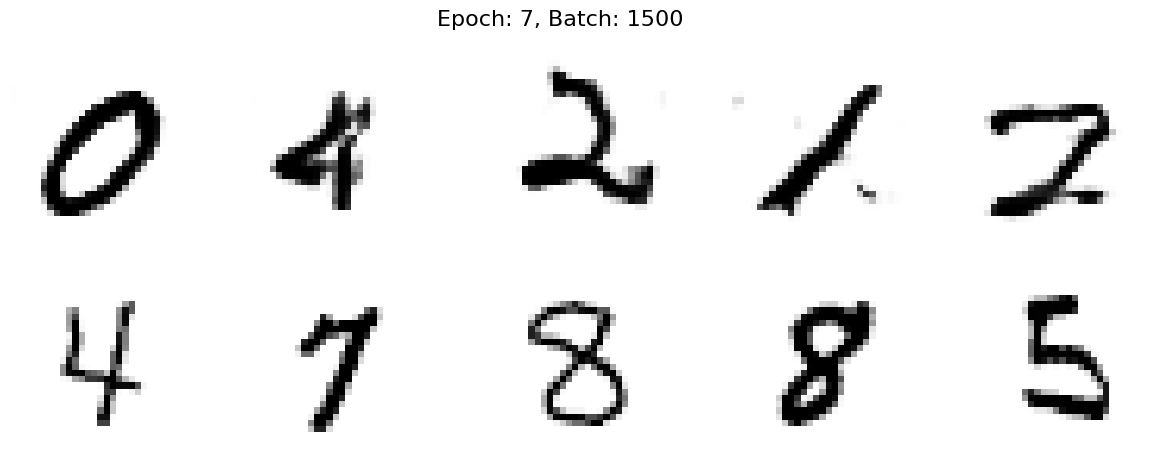

1550 [D loss: 0.6513,	 acc.: 59.38%]	[G loss: 1.0801]
1600 [D loss: 0.7559,	 acc.: 50.00%]	[G loss: 0.7970]
1650 [D loss: 0.7144,	 acc.: 60.94%]	[G loss: 0.8935]
1700 [D loss: 0.5862,	 acc.: 75.00%]	[G loss: 0.9575]
1750 [D loss: 0.6418,	 acc.: 59.38%]	[G loss: 0.8053]
1800 [D loss: 0.6284,	 acc.: 60.94%]	[G loss: 0.8549]
1850 [D loss: 0.6653,	 acc.: 64.06%]	[G loss: 0.9127]


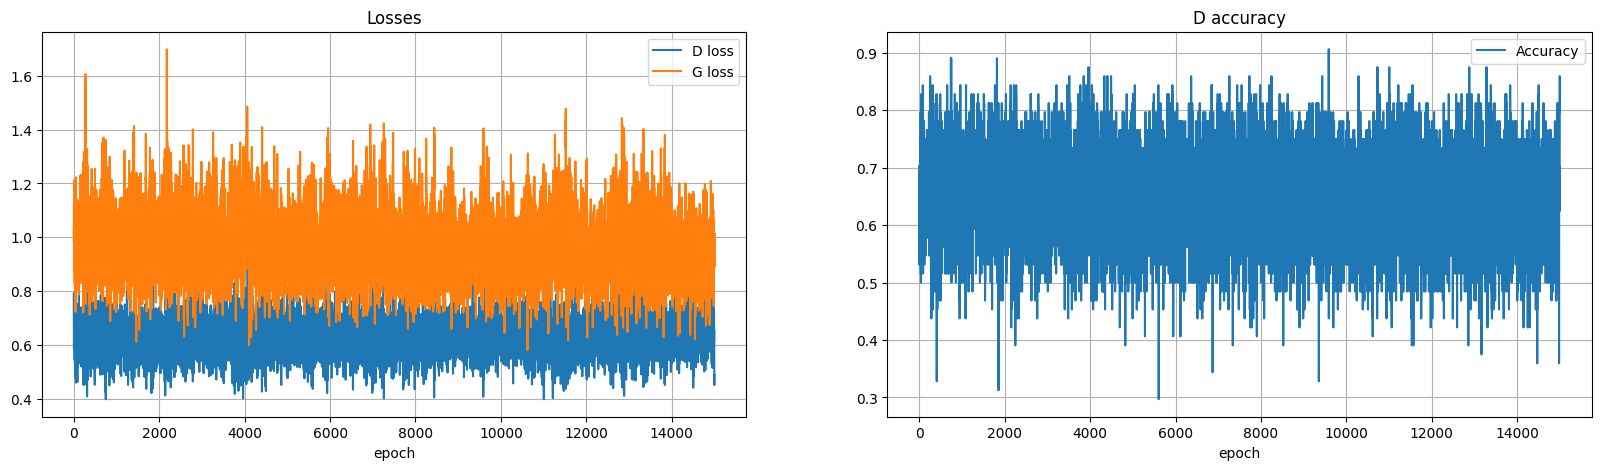

----EPOCH 8-----
0 [D loss: 0.6537,	 acc.: 60.94%]	[G loss: 1.0269]


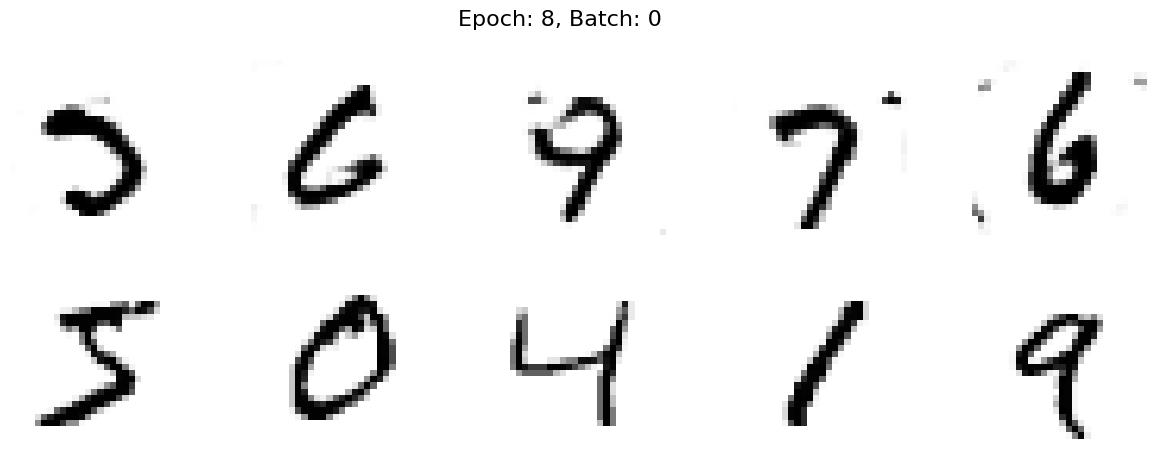

50 [D loss: 0.6222,	 acc.: 65.62%]	[G loss: 0.9863]
100 [D loss: 0.5649,	 acc.: 71.88%]	[G loss: 1.0344]
150 [D loss: 0.6807,	 acc.: 60.94%]	[G loss: 0.9404]
200 [D loss: 0.6363,	 acc.: 62.50%]	[G loss: 0.9235]
250 [D loss: 0.6343,	 acc.: 64.06%]	[G loss: 1.0655]
300 [D loss: 0.5130,	 acc.: 73.44%]	[G loss: 1.1623]
350 [D loss: 0.7254,	 acc.: 56.25%]	[G loss: 0.9473]
400 [D loss: 0.6689,	 acc.: 57.81%]	[G loss: 0.9022]
450 [D loss: 0.7278,	 acc.: 57.81%]	[G loss: 0.8359]
500 [D loss: 0.7003,	 acc.: 59.38%]	[G loss: 0.8804]


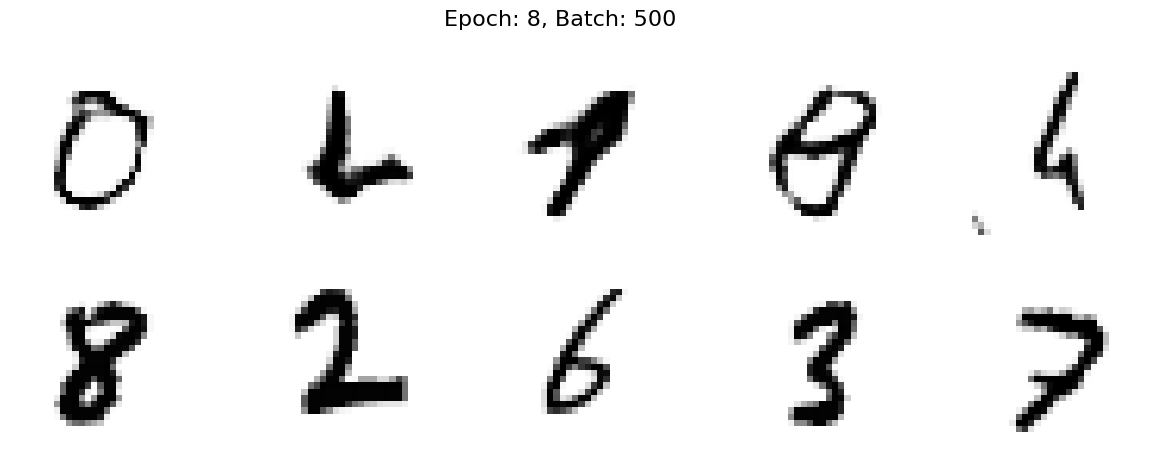

550 [D loss: 0.7134,	 acc.: 57.81%]	[G loss: 0.8785]
600 [D loss: 0.5109,	 acc.: 79.69%]	[G loss: 0.8914]
650 [D loss: 0.6093,	 acc.: 67.19%]	[G loss: 0.9670]
700 [D loss: 0.5725,	 acc.: 70.31%]	[G loss: 1.0074]
750 [D loss: 0.5855,	 acc.: 68.75%]	[G loss: 1.1773]
800 [D loss: 0.5966,	 acc.: 67.19%]	[G loss: 1.0495]
850 [D loss: 0.5998,	 acc.: 65.62%]	[G loss: 0.9682]
900 [D loss: 0.5591,	 acc.: 76.56%]	[G loss: 0.8629]
950 [D loss: 0.6919,	 acc.: 57.81%]	[G loss: 0.8681]
1000 [D loss: 0.6799,	 acc.: 50.00%]	[G loss: 0.8748]


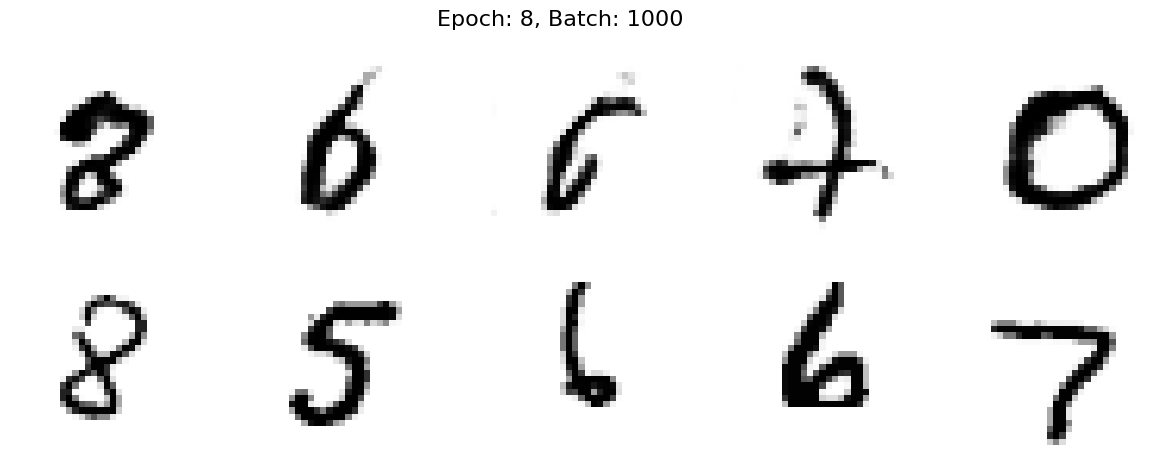

1050 [D loss: 0.6480,	 acc.: 62.50%]	[G loss: 0.9975]
1100 [D loss: 0.6515,	 acc.: 59.38%]	[G loss: 0.8828]
1150 [D loss: 0.7003,	 acc.: 54.69%]	[G loss: 0.9131]
1200 [D loss: 0.6081,	 acc.: 62.50%]	[G loss: 0.9395]
1250 [D loss: 0.6142,	 acc.: 67.19%]	[G loss: 0.8019]
1300 [D loss: 0.6321,	 acc.: 67.19%]	[G loss: 1.0211]
1350 [D loss: 0.5994,	 acc.: 65.62%]	[G loss: 0.7583]
1400 [D loss: 0.6788,	 acc.: 56.25%]	[G loss: 0.9090]
1450 [D loss: 0.6105,	 acc.: 60.94%]	[G loss: 0.8230]
1500 [D loss: 0.7033,	 acc.: 62.50%]	[G loss: 0.8165]


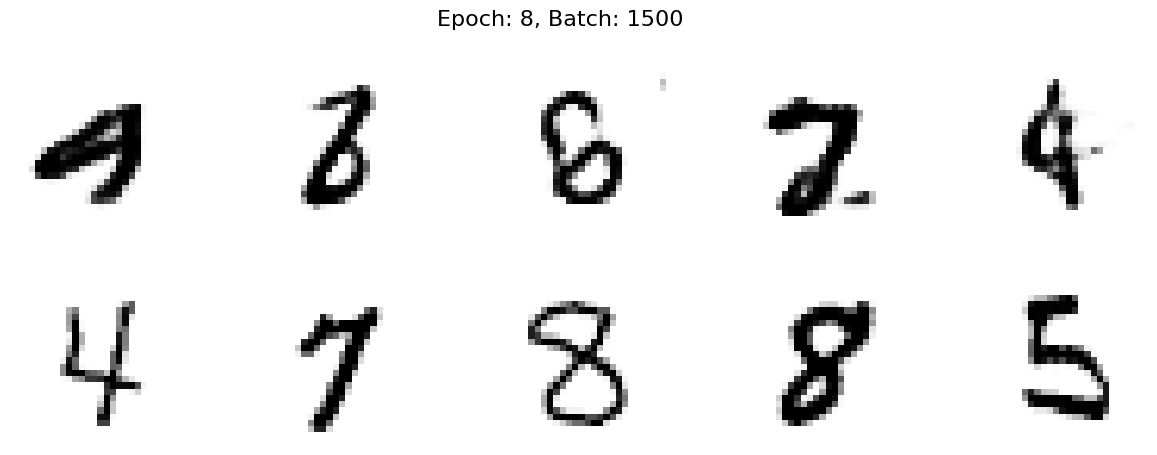

1550 [D loss: 0.6449,	 acc.: 60.94%]	[G loss: 0.9084]
1600 [D loss: 0.6845,	 acc.: 59.38%]	[G loss: 0.9153]
1650 [D loss: 0.6943,	 acc.: 53.12%]	[G loss: 0.7906]
1700 [D loss: 0.5953,	 acc.: 73.44%]	[G loss: 0.9109]
1750 [D loss: 0.6151,	 acc.: 67.19%]	[G loss: 0.9580]
1800 [D loss: 0.6162,	 acc.: 64.06%]	[G loss: 0.9602]
1850 [D loss: 0.5578,	 acc.: 71.88%]	[G loss: 0.8267]


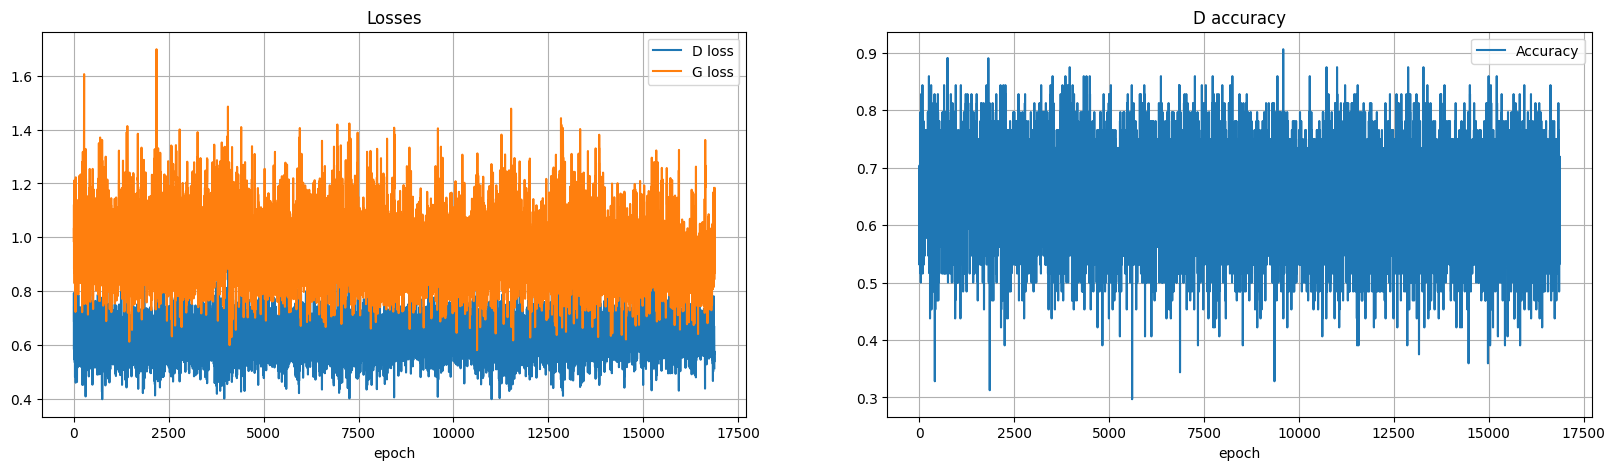

----EPOCH 9-----
0 [D loss: 0.6635,	 acc.: 65.62%]	[G loss: 1.1018]


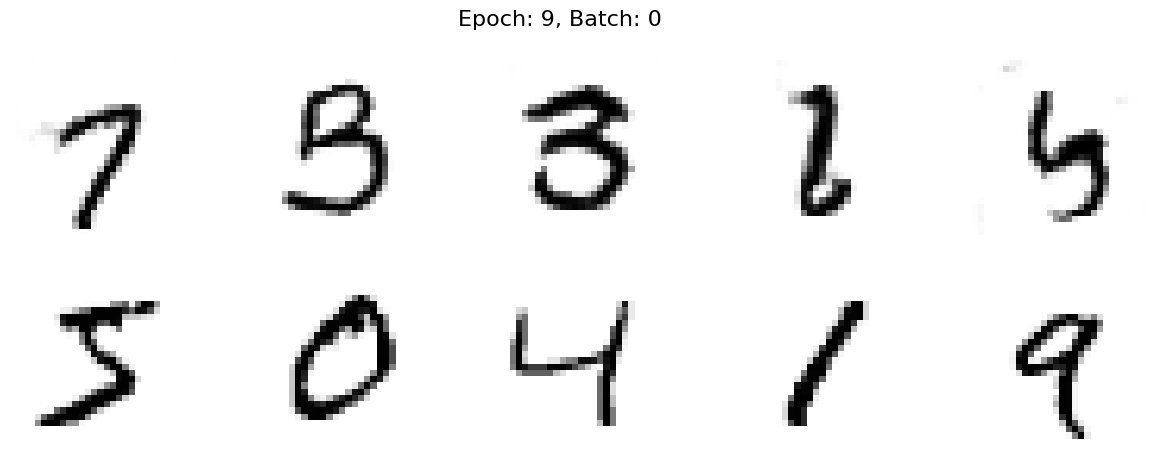

50 [D loss: 0.5622,	 acc.: 65.62%]	[G loss: 0.8038]
100 [D loss: 0.5329,	 acc.: 79.69%]	[G loss: 1.0502]
150 [D loss: 0.5845,	 acc.: 71.88%]	[G loss: 0.9107]
200 [D loss: 0.6370,	 acc.: 60.94%]	[G loss: 0.9732]
250 [D loss: 0.6968,	 acc.: 54.69%]	[G loss: 0.8205]
300 [D loss: 0.6822,	 acc.: 62.50%]	[G loss: 0.9000]
350 [D loss: 0.6872,	 acc.: 57.81%]	[G loss: 0.9236]
400 [D loss: 0.6688,	 acc.: 57.81%]	[G loss: 0.8710]
450 [D loss: 0.6694,	 acc.: 57.81%]	[G loss: 0.7503]
500 [D loss: 0.6458,	 acc.: 62.50%]	[G loss: 0.9273]


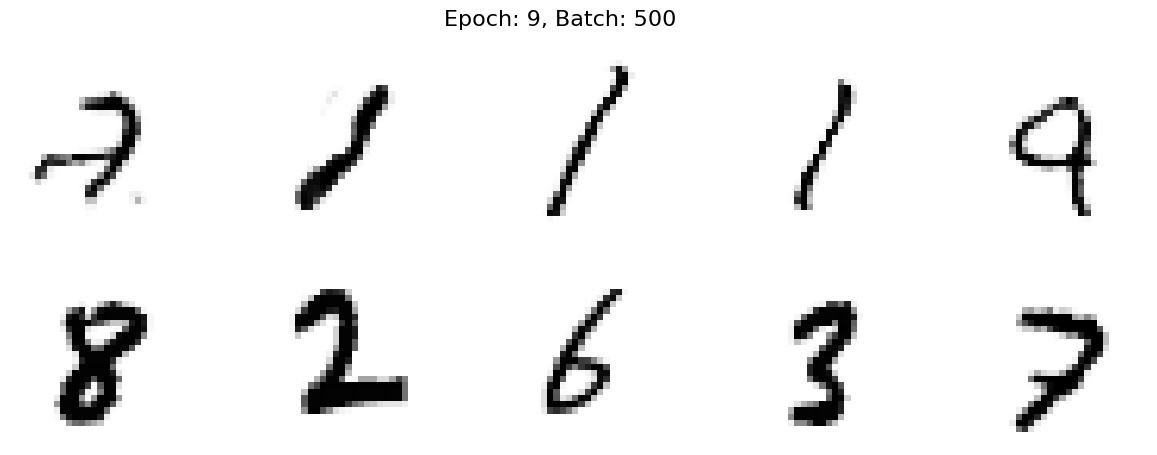

550 [D loss: 0.6210,	 acc.: 62.50%]	[G loss: 0.8203]
600 [D loss: 0.6718,	 acc.: 62.50%]	[G loss: 1.0265]
650 [D loss: 0.5452,	 acc.: 79.69%]	[G loss: 0.9099]
700 [D loss: 0.5809,	 acc.: 75.00%]	[G loss: 1.0840]
750 [D loss: 0.6893,	 acc.: 62.50%]	[G loss: 0.9489]
800 [D loss: 0.5780,	 acc.: 68.75%]	[G loss: 1.0447]
850 [D loss: 0.5800,	 acc.: 62.50%]	[G loss: 0.7320]
900 [D loss: 0.6415,	 acc.: 57.81%]	[G loss: 0.9741]
950 [D loss: 0.6507,	 acc.: 59.38%]	[G loss: 0.9010]
1000 [D loss: 0.7182,	 acc.: 57.81%]	[G loss: 0.9226]


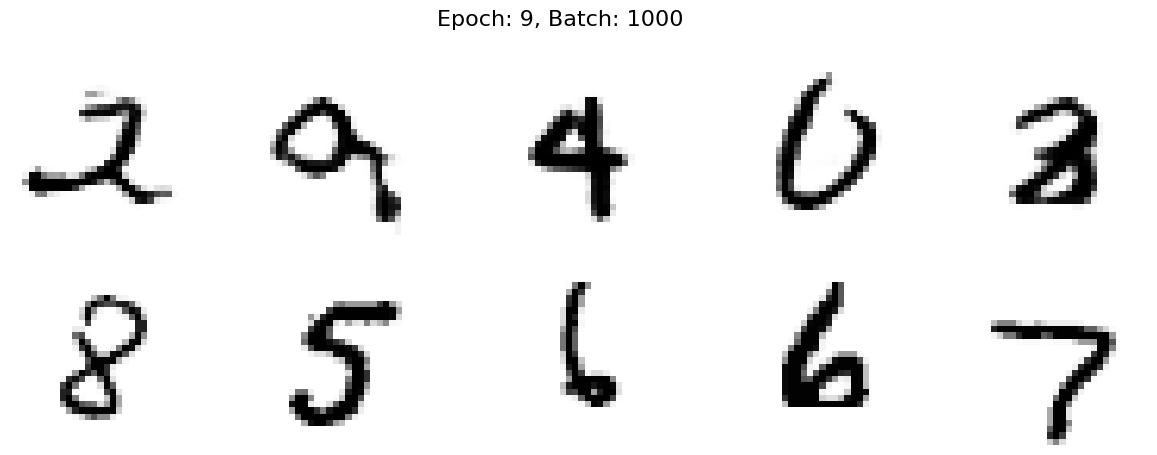

1050 [D loss: 0.6116,	 acc.: 65.62%]	[G loss: 0.8849]
1100 [D loss: 0.6019,	 acc.: 64.06%]	[G loss: 0.8848]
1150 [D loss: 0.7036,	 acc.: 54.69%]	[G loss: 0.9316]
1200 [D loss: 0.5916,	 acc.: 65.62%]	[G loss: 0.8335]
1250 [D loss: 0.6424,	 acc.: 70.31%]	[G loss: 0.7106]
1300 [D loss: 0.6687,	 acc.: 60.94%]	[G loss: 1.0199]
1350 [D loss: 0.6306,	 acc.: 60.94%]	[G loss: 0.9161]
1400 [D loss: 0.7388,	 acc.: 54.69%]	[G loss: 0.9396]
1450 [D loss: 0.6641,	 acc.: 60.94%]	[G loss: 1.0856]
1500 [D loss: 0.6057,	 acc.: 67.19%]	[G loss: 0.8780]


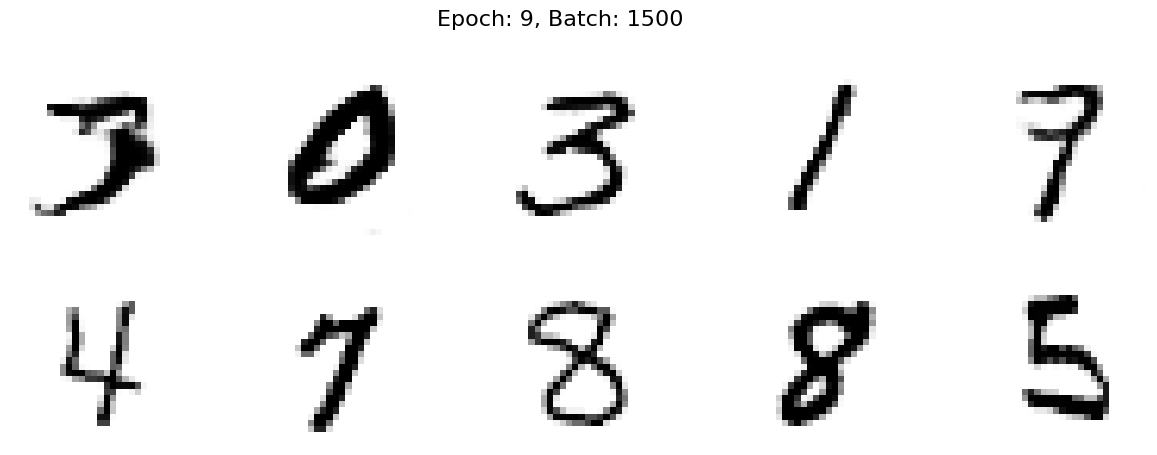

1550 [D loss: 0.6565,	 acc.: 62.50%]	[G loss: 1.0641]
1600 [D loss: 0.5700,	 acc.: 67.19%]	[G loss: 0.8434]
1650 [D loss: 0.6618,	 acc.: 62.50%]	[G loss: 0.6965]
1700 [D loss: 0.6333,	 acc.: 59.38%]	[G loss: 0.7220]
1750 [D loss: 0.6668,	 acc.: 56.25%]	[G loss: 0.8288]
1800 [D loss: 0.5562,	 acc.: 75.00%]	[G loss: 0.8664]
1850 [D loss: 0.5838,	 acc.: 71.88%]	[G loss: 0.9768]


In [ ]:
train(X_train, generator, discriminator, combined, epochs=10, batch_size=32, sample_interval=100)


### RESUPUESTA

Se puede comprobar que durante el primer entrenamiento el generador ha aprendido a crear imágenes con símbolos, algunos bastante parecidos a números y el discriminador tiene un acierto alrededor del 60%. Vamos a realizar un segundo entrenamiento a ver si consigue aumentar el número de símbolos parecidos a números.

El segundo entrenamiento los símbolos generados se parecen cada vez más a números. (No aparece la última gráfica porque me he quedado sin recursos)

---

Creado por **Guillermo Iglesias** (guillermo.iglesias@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">